In this project our main character will be compliance. Compliance = the rules are followed. Non-compliance = the rules are not followed. What rules? Rules can be different and they are set by the company we are doing the project for. We don't know them.

In [1977]:
# =============================
# Libraries
# =============================
import math
import random
import sqlite3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import shapiro, kruskal, skew, randint

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

from IPython.display import display

## **Dataset overview**

In [1979]:
# load the dataset
conn = sqlite3.connect("org_compliance_data.db")

In [1980]:
#list all the datasets in 'org_compliance_data.db'
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

                       name
0               departments
1  risk_summary_by_division
2     high_risk_departments
3           data_dictionary


In [1981]:
# Load tables into variables
departments = pd.read_sql_query("SELECT * FROM departments;", conn)
high_risk_departments = pd.read_sql_query("SELECT * FROM high_risk_departments;", conn)
risk_summary_by_division = pd.read_sql_query("SELECT * FROM risk_summary_by_division;", conn)
data_dictionary = pd.read_sql_query("SELECT * FROM data_dictionary;", conn)

In [1982]:
#create backup tables
departments_copy = departments.copy()
high_risk_departments_copy = high_risk_departments.copy()
risk_summary_by_division_copy = risk_summary_by_division.copy()

In [1983]:
# Show preview of each table
for name, df in {
    "departments": departments,
    "high_risk_departments": high_risk_departments,
    "risk_summary_by_division": risk_summary_by_division,
    "data_dictionary": data_dictionary
}.items():
    print(f"\n{'='*50}")
    print(f"Table: {name}")
    print("="*50)
    display(df.head(6))

print("'departments' table shape:", departments.shape)


Table: departments


dept_id                            dept_name           dept_category  \
0  DEPT-1620                      Core Compliance     Financial_Reporting   
1  DEPT-1133                   Digital Governance     Financial_Reporting   
2  DEPT-4917                          Central Hub  Operational_Compliance   
3  DEPT-6959           Compliance - Legacy Region     Financial_Reporting   
4  DEPT-4312               West Internal Controls     Financial_Reporting   
5  DEPT-3347  Business Integrity - Central Region     Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Operations             8.0        Remote     Large   
1  Corporate_HQ  Compliance             8.0         Urban     Large   
2          None        None             NaN          None      None   
3  Corporate_HQ     Support             8.0         Urban     Large   
4  Corporate_HQ  Operations             6.0         Urban     Small   
5  Corporate_HQ  Operations             6.0         Urban     Small   

  reporting_structure  manager_experience_level  ...  \
0         Centralized                       2.0  ...   
1         Centralized                       2.0  ...   
2                None                       NaN  ...   
3         Centralized                       4.0  ...   
4         Centralized                       1.0  ...   
5         Centralized                       2.0  ...   

   resource_availability_score external_interactions_frequency  \
0                          2.0                             3.0   
1                          4.0                             NaN   
2                          NaN                             NaN   
3                          3.0                             4.0   
4                          4.0                             2.0   
5                          4.0                             4.0   

  risk_exposure_operational risk_exposure_financial operational_health_index  \
0                       1.0                     NaN                      5.0   
1                       2.0                     2.0                      1.0   
2                       NaN                     NaN                      NaN   
3                       1.0                     1.0                      5.0   
4                       1.0                     1.0                      5.0   
5                       3.0                     5.0                      5.0   

   reporting_gaps_annual  audit_score_q1  audit_score_q2  \
0                    NaN            55.0            55.0   
1                   26.0             NaN            40.0   
2                    NaN             NaN             NaN   
3                    2.0            70.0            75.0   
4                    2.0            45.0            45.0   
5                    6.0            45.0            50.0   

   compliance_score_final  overall_risk_score  
0                    65.0                12.0  
1                     NaN                43.0  
2                     NaN                 NaN  
3                    85.0                11.0  
4                    45.0                11.0  
5                    50.0                53.0  

[6 rows x 37 columns]


Table: high_risk_departments


dept_id                            dept_name        dept_category  \
0  DEPT-1133                   Digital Governance  Financial_Reporting   
1  DEPT-4312               West Internal Controls  Financial_Reporting   
2  DEPT-3347  Business Integrity - Central Region  Financial_Reporting   
3  DEPT-2554                         Central Team  Financial_Reporting   
4  DEPT-3151             Compliance - East Region  Financial_Reporting   
5  DEPT-3953         Compliance - Emerging Region  Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Compliance             8.0         Urban     Large   
1  Corporate_HQ  Operations             6.0         Urban     Small   
2  Corporate_HQ  Operations             6.0         Urban     Small   
3  Corporate_HQ     Support             5.0         Urban     Small   
4  Corporate_HQ        None             8.0         Urban     Small   
5  Corporate_HQ     Support             6.0         Urban     Small   

  reporting_structure  manager_experience_level  ...  \
0         Centralized                       2.0  ...   
1         Centralized                       1.0  ...   
2         Centralized                       2.0  ...   
3          Autonomous                       3.0  ...   
4         Centralized                       3.0  ...   
5         Centralized                       2.0  ...   

   resource_availability_score external_interactions_frequency  \
0                          4.0                             NaN   
1                          4.0                             2.0   
2                          4.0                             4.0   
3                          3.0                             4.0   
4                          2.0                             4.0   
5                          3.0                             4.0   

  risk_exposure_operational risk_exposure_financial operational_health_index  \
0                       2.0                     2.0                      1.0   
1                       1.0                     1.0                      5.0   
2                       3.0                     5.0                      5.0   
3                       4.0                     4.0                      1.0   
4                       NaN                     4.0                      4.0   
5                       1.0                     2.0                      2.0   

   reporting_gaps_annual  audit_score_q1  audit_score_q2  \
0                   26.0             NaN            40.0   
1                    2.0            45.0            45.0   
2                    6.0            45.0            50.0   
3                    0.0            65.0            60.0   
4                   10.0            50.0            50.0   
5                    6.0            65.0            55.0   

   compliance_score_final  overall_risk_score  
0                     NaN                43.0  
1                    45.0                11.0  
2                    50.0                53.0  
3                    65.0                40.0  
4                    50.0                35.0  
5                    55.0                18.0  

[6 rows x 37 columns]


Table: risk_summary_by_division


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.245477             13.369017   
1  Regional_Operations             76.054167             13.777896   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.463636         428  
1       64.000000          27


Table: data_dictionary


table_name      field_name data_type  \
0  departments         dept_id    string   
1  departments       dept_name    string   
2  departments   dept_category    string   
3  departments        division    string   
4  departments       dept_type    string   
5  departments  dept_age_years   integer   

                                         description  
0                       Unique department identifier  
1                                    Department name  
2  Primary compliance category (Financial_Reporti...  
3  Organizational division (Corporate_HQ, Regiona...  
4  Department type (Operations, Support, Complian...  
5     Age of department in years since establishment

'departments' table shape: (709, 37)


In [1984]:
data_dictionary.head(39)

table_name                       field_name data_type  \
0   departments                          dept_id    string   
1   departments                        dept_name    string   
2   departments                    dept_category    string   
3   departments                         division    string   
4   departments                        dept_type    string   
5   departments                   dept_age_years   integer   
6   departments                    location_type    string   
7   departments                        team_size    string   
8   departments              reporting_structure    string   
9   departments         manager_experience_level   integer   
10  departments      supervisor_experience_level   integer   
11  departments                 primary_function    string   
12  departments               secondary_function    string   
13  departments                  creation_reason    string   
14  departments                   oversight_body    string   
15  departments               reporting_lag_days   integer   
16  departments         training_hours_quarterly   integer   
17  departments           violations_past_3years   integer   
18  departments            reporting_gaps_annual   integer   
19  departments          remediation_plan_active   integer   
20  departments                executive_support   integer   
21  departments              external_consulting   integer   
22  departments              engagement_programs   integer   
23  departments               onboarding_program   integer   
24  departments           improvement_commitment   integer   
25  departments                  digital_systems   integer   
26  departments            external_partnerships   integer   
27  departments    interdept_collaboration_score   integer   
28  departments      resource_availability_score   integer   
29  departments  external_interactions_frequency   integer   
30  departments        risk_exposure_operational   integer   
31  departments          risk_exposure_financial   integer   
32  departments         operational_health_index   integer   
33  departments               overall_risk_score     float   
34  departments                   audit_score_q1     float   
35  departments                   audit_score_q2     float   
36  departments           compliance_score_final     float   
37    _metadata                         project_    string   
38    _metadata                    academic_year    string   

                                          description  
0                        Unique department identifier  
1                                     Department name  
2   Primary compliance category (Financial_Reporti...  
3   Organizational division (Corporate_HQ, Regiona...  
4   Department type (Operations, Support, Complian...  
5      Age of department in years since establishment  
6   Geographic location type (Urban, Remote, Subur...  
7           Team size category (Small, Medium, Large)  
8   Reporting hierarchy (Centralized, Autonomous, ...  
9    Manager experience level (0=none to 4=extensive)  
10  Supervisor experience level (0=none to 4=exten...  
11                          Primary business function  
12                        Secondary business function  
13  Reason for department creation (Merger, Expans...  
14  Primary oversight entity (Internal_Audit, Exte...  
15       Average delay in compliance reporting (days)  
16              Compliance training hours per quarter  
17    Number of compliance violations in past 3 years  
18    Number of missed or incomplete reports annually  
19     Active remediation plan in place (0=No, 1=Yes)  
20  Executive leadership support confirmed (0=No, ...  
21  External compliance consultants engaged (0=No,...  
22  Employee engagement programs active (0=No, 1=Yes)  
23  Compliance onboarding program exists (0=No, 1=...  
24  Formal commitment to continuous improvement (0...  
25  Digital compliance management systems in use (...  
26  Active e

---
**We can see that there are 4 tables:**

1. `departments` (the main table describing departments)

2. `high_risk_departments` (subset of the 'departments' table describing only risky departments)

3. `risk_summary_by_division` (shows information about divisions, and divisions contain departments)

4. `data_dictionary` (explains variables)

>#### Full variable analysis
>
>There are variables that help us identify departments:
>- `dept_id` -> very important -> **keep**
>- `dept_name`: does not bring any useful information -> **drop**
>- `dept_category`:  rules for Financial_Reporting, Operational_Compliance, Risk_Management. Workers in one department deal with one of these three groups of rules. So potentially, it can be harder to deal with one of the groups than with the others, so the non-compliance level for these departments can be higher. -> **keep**
>- `division`: departments belong to either of two divisions. Important for understanding the bigger picture -> **keep**
>- `dept_type`: what the department does in general: Operations, Support, Compliance, Finance, Technology, Legal. Again, potentially, it can be more difficult to follow rules when dealing with, for example, operations so the non-compliance level will be higher for these departments. -> **keep**
>
>Variables that give us understanding of structure and context of the departments:
>
>- `dept_age_years`-> **keep**
>- `location_type`-> **keep**
>- `team_size` -> **keep**
>- `reporting_structure`: how compliance reports are organized (Centralized, Autonomous, Hybrid) -> **keep**
>- `manager_experience_level`-> **keep**
>- `supervisor_experience_level`-> **keep**
>- `primary_function`: what exactly a department does (IT support, Audit, Reporting, etc) first -> **keep**
>- `secondary_function`: what a department does after its primary function -> **drop**
>- `oversight_body`: who monitors the department(Internal_Audit, External_Auditor, Compliance_Officer, Board_Committee) - who checks that the rules are followed -> **keep**
>- `creation_reason` : does not bring any useful information -> **drop**
>
>Variables that give us information on how the compliance is being treated:
>
>- `reporting_lag_days`: average delay in compliance report, so high level may be correlated with non-compliance -> **keep**
>- `training_hours_quarterly`: how much compliance training (in hours) the department received -> **keep**
>- `violations_past_3years`: direct indicator of past violations in the department -> **keep**
>- `remediation_plan_active`: shows if there is an active plan to fix compliance issues. -> **keep**
>- `executive_support` -> **keep**
>- `external_consulting` -> **keep**
>- `engagement_programs`: whether there are active employee engagement programs -> **keep**
>- `onboarding_program` the department has a structured onboarding program for new employees about compliance rules -> **keep**
>- `improvement_commitment` -> **keep**
>- `digital_systems`: whether the department uses software/tools to manage compliance -> **keep**
>- `external_partnerships`: whether the department collaborates with external entities for compliance (like hiring external consultants) -> **keep**
>
>'Soft' indexes, like soft skills of departments:
>
>- `interdept_collaboration_score`: does this department collaborate with other departments? -> **keep**
>- `resource_availability_score`: how well it collaborates with other departments -> **keep**
>- `external_interactions_frequency`: how often the department interacts with external stakeholders (Frequent interactions may improve compliance awareness, but increase exposure if mismanaged) -> **keep**
>
> Risk and health:
>- `risk_exposure_operational`: how likely an operational miskate or failure can happen. For example, is the operation of this department is mostly manual then the likelihood of a mistake is higher than for departments with automated work. -> **keep**
>- `risk_exposure_financial`: potential financial impact of the department's actions. Finance department->5, IT->1 -> **keep**
>- `operational_health_index`: how well the department runs its processes -> **keep**
>- `reporting_gaps_annual`: missed or incomplete reports per year -> **keep**
>- `audit_score_q1`: how well the department passes the Q1 audit -> **keep**
>- `audit_score_q2`: how well the department passes the Q2 audit -> **keep**
>- `compliance_score_final`: Overall compliance rating for the year. PRIMARY TARGET -> **TARGET**
>- `overall_risk_score`: Weighted score combining operational, financial, and other risk factors. -> **keep**
---
There are many variables that could possibly affect the non-compliance. However, `reation_reason`, `secondary_function`, `dept_name` will bring more noise than information, therefore, should be dropped at the very early stages.

**What is non-compliance?**
As the dictionary table explains, there already exist **two main scores** assosiated with compliance and overall risk: `compliance_score` and the `overall_risk_score`. What is the difference between them?

**Hypothesis**
`compliance_score` is the overall compliance rating, so the compliance was already measures for the chosen department. `overall_risk_score` includes risks, but not only for non-compliance. Possibly also financial risk, operatrional risk, etc.

---

## **Before we started EDA...**

**we should do the following steps**

### **1. Change data types**

We have a lot of boolean variables that were stored as objects. We should change them to numeric to avoid pandas errors.

In [1990]:
bool_columns = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]

for col in bool_columns:
    departments[col] = pd.to_numeric(departments[col], errors='coerce')
    high_risk_departments[col] = pd.to_numeric(high_risk_departments[col], errors='coerce')

---
### **2. Drop immediately**
We drop immediately `creation_reason`, `secondary_function`, `dept_name` since they are not useful for our task. We delete them from both tables `departments` and `high_risk_departments`.

---

In [1992]:
cols_to_delete = [
    'dept_name',
    'secondary_function',
    'creation_reason',
    '_metadataproject_string',
    '_metadataacademic_year'
]

departments = departments.drop(columns=cols_to_delete, errors='ignore')
high_risk_departments = high_risk_departments.drop(columns=cols_to_delete, errors='ignore')
print("'departments' table shape:", departments.shape)

'departments' table shape: (709, 34)


---
### **3. Variable presence check**
Now we check that all departments in the `high_risk_departments` also present in `departments`.

---

In [1994]:
# Departments in high_risk_departments that are NOT in departments
missing_in_departments = high_risk_departments[~high_risk_departments['dept_id'].isin(departments['dept_id'])]

# Check results
print(f"Number of high-risk departments not present in main departments table: {len(missing_in_departments)}")

# Optional: show the dept_ids if any
if len(missing_in_departments) > 0:
    print("Dept IDs missing in main table:")
    display(missing_in_departments['dept_id'])
else:
    print("All high-risk departments are present in the main departments table.")

Number of high-risk departments not present in main departments table: 0
All high-risk departments are present in the main departments table.


---
Drop them since we can't restore their original view.

---

In [1996]:
high_risk_departments = high_risk_departments[
    high_risk_departments['dept_id'].isin(departments['dept_id'])
].copy()
missing_in_departments = high_risk_departments[~high_risk_departments['dept_id'].isin(departments['dept_id'])]
print(f"Number of high-risk departments not present in main departments table: {len(missing_in_departments)}")

Number of high-risk departments not present in main departments table: 0


### **4. Combine two main tables**

Now we can combine two most important tables: if a department is present in the high_risk_departments table, it will be flagged (present_in_high_risk_departments = 1). If not - present_in_high_risk_departments = 0

---

In [1999]:
# Add a flag column to departments
departments['present_in_high_risk_departments'] = departments['dept_id'].isin(high_risk_departments['dept_id']).astype(int)

# Check results
departments.head(3)

dept_id           dept_category      division   dept_type  \
0  DEPT-1620     Financial_Reporting  Corporate_HQ  Operations   
1  DEPT-1133     Financial_Reporting  Corporate_HQ  Compliance   
2  DEPT-4917  Operational_Compliance          None        None   

   dept_age_years location_type team_size reporting_structure  \
0             8.0        Remote     Large         Centralized   
1             8.0         Urban     Large         Centralized   
2             NaN          None      None                None   

   manager_experience_level  supervisor_experience_level  ...  \
0                       2.0                          2.0  ...   
1                       2.0                          2.0  ...   
2                       NaN                          NaN  ...   

  external_interactions_frequency risk_exposure_operational  \
0                             3.0                       1.0   
1                             NaN                       2.0   
2                             NaN                       NaN   

   risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
0                      NaN                       5.0                    NaN   
1                      2.0                       1.0                   26.0   
2                      NaN                       NaN                    NaN   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  \
0            55.0            55.0                    65.0                12.0   
1             NaN            40.0                     NaN                43.0   
2             NaN             NaN                     NaN                 NaN   

   present_in_high_risk_departments  
0                                 0  
1                                 1  
2                                 0  

[3 rows x 35 columns]

---
Then we check both `departments` and `high_risk_departments` tables for duplicates.

---

### **5. Duplicates check and handle**

#### **Duplicates:** `departments`

In [2003]:
# Checks if two columns share the same name
print(df.columns.duplicated().sum())

0


In [2004]:
# Check if any full row duplicates
print(f"Number of full-row duplicates: {departments.duplicated().sum()}")

Number of full-row duplicates: 1


In [2005]:
# Check for duplicates based on dept_id
print(f"Number of duplicate dept_id values: {departments['dept_id'].duplicated().sum()}")
# Identify all duplicate dept_id values
dup_dept_ids = departments[departments['dept_id'].duplicated(keep=False)]['dept_id'].unique()
print("Duplicate dept_ids:", dup_dept_ids)

Number of duplicate dept_id values: 27
Duplicate dept_ids: ['DEPT-1237' 'DEPT-9694' 'DEPT-7071' 'DEPT-2743' 'DEPT-8429' 'DEPT-9035'
 'DEPT-2792' 'DEPT-6883' 'DEPT-5023' 'DEPT-2377' 'DEPT-7646' 'DEPT-9204'
 'DEPT-2856' 'DEPT-8383' 'DEPT-8159' 'DEPT-9847' 'DEPT-9975' 'DEPT-2762'
 'DEPT-5849' 'DEPT-3845' 'DEPT-8168' 'DEPT-5828' 'DEPT-9396' 'DEPT-2612'
 'DEPT-6380' 'DEPT-6945']


---
There in one full row duplicate and 27 dept_id duplicates, including the one with everything duplicated. `dept_id` is a very important categorical variable for us, therefore we should drop all duplicates to be sure that each id is unique. But before we should check whether any of duplicates present in high risk departments table.

---

In [2007]:
# Print the number of repeating dept_ids that are in high_risk_departments
print(((departments['dept_id'].isin(dup_dept_ids)) &
         (departments['present_in_high_risk_departments'] == 1)).sum())

33


---
Because some dupliucates are 'risky' we should delete rows that were not considered risky. So we create a pattern:
among original values and their duplicates:
1. if present_in_high_risk_departments = 1, keep. if both unique value and its duplicate has present_in_high_risk_departments = 1 keep the first to appear.
2. if present_in_high_risk_departments = 0, keep first to appear.

---

In [2009]:
# Ensure the flag is numeric
departments['present_in_high_risk_departments'] = departments['present_in_high_risk_departments'].astype(int)

# Sort so that risky rows come first, original order preserved
departments.sort_values(
    by=['dept_id', 'present_in_high_risk_departments'],
    ascending=[True, False],
    inplace=True
)

# Keep only the first occurrence of each dept_id
departments.drop_duplicates(subset='dept_id', keep='first', inplace=True)

# Reset index
departments.reset_index(drop=True, inplace=True)

# Check results
print("Cleaned shape:", departments.shape)
print("Remaining dept_id duplicates:", departments['dept_id'].duplicated().sum())

Cleaned shape: (682, 35)
Remaining dept_id duplicates: 0


#### **Duplicates:** `high_risk_departments`

In [2011]:
# Check if any dept_id duplicates
print(f"Number of full-row duplicates: {high_risk_departments['dept_id'].duplicated().sum()}")

# Identify all duplicate dept_id values
dup_high_risk_id = high_risk_departments[high_risk_departments['dept_id'].duplicated(keep=False)]['dept_id'].unique()
print("Duplicate dept_ids:", dup_high_risk_id)

Number of full-row duplicates: 1
Duplicate dept_ids: ['DEPT-2612']


---
Since in the high_risk_table data was cleaned, it won't necessarily be identical to the original. Therefore, we should keep the dept_id that matches the original row more.

---

In [2013]:
# Identify duplicate dept_ids in high_risk_departments
dup_dept_ids = high_risk_departments['dept_id'][high_risk_departments['dept_id'].duplicated()].unique()

rows_to_keep = []

for dept_id in dup_dept_ids:
    # rows in high_risk_departments with this dept_id
    hr_rows = high_risk_departments[high_risk_departments['dept_id'] == dept_id]
    # corresponding row in departments
    dept_row = departments[departments['dept_id'] == dept_id].iloc[0]

    # calculate match count for each duplicate row
    match_scores = []
    for i, hr_row in hr_rows.iterrows():
        count = 0
        for col in hr_row.index:
            if col == 'dept_id':
                continue  # skip id
            if hr_row[col] == dept_row[col]:
                count += 1
        match_scores.append((i, count))

    # keep the row with the highest match count
    best_row_index = max(match_scores, key=lambda x: x[1])[0]
    rows_to_keep.append(best_row_index)

# Keep only the best duplicate rows plus all non-duplicate dept_ids
high_risk_departments = pd.concat([
    high_risk_departments[~high_risk_departments['dept_id'].isin(dup_dept_ids)],
    high_risk_departments.loc[rows_to_keep]
])

# Reset index
high_risk_departments.reset_index(drop=True, inplace=True)

# Check duplicates
print("Remaining dept_id duplicates:", high_risk_departments['dept_id'].duplicated().sum())

Remaining dept_id duplicates: 0


# **EDA**

### **1. Shape**

In [2016]:
print("'departments' table shape:", departments.shape)

'departments' table shape: (682, 35)


In [2017]:
print("\nColumn types:\n", departments.dtypes)


Column types:
 dept_id                              object
dept_category                        object
division                             object
dept_type                            object
dept_age_years                      float64
location_type                        object
team_size                            object
reporting_structure                  object
manager_experience_level            float64
supervisor_experience_level         float64
primary_function                     object
oversight_body                       object
reporting_lag_days                  float64
training_hours_quarterly            float64
violations_past_3years              float64
remediation_plan_active             float64
executive_support                   float64
external_consulting                 float64
engagement_programs                 float64
onboarding_program                  float64
improvement_commitment              float64
digital_systems                     float64
external_partner

---
Split data into numerical, boolean, and categorical variables.

---

In [2019]:
# mostly strings or IDs describing a department:
categorical_cols = [
    'dept_id', 'dept_category', 'division', 'dept_type',
    'location_type', 'team_size', 'reporting_structure', 'primary_function',
     'oversight_body'
]

numerical_cols = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2',
    'compliance_score_final'
]
# integers representing yes/no flags, they can be treated either as categorical or numerical, depending on analysis
bool_cols = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]

### **2. Outliers check**

#### **Numerical variables**

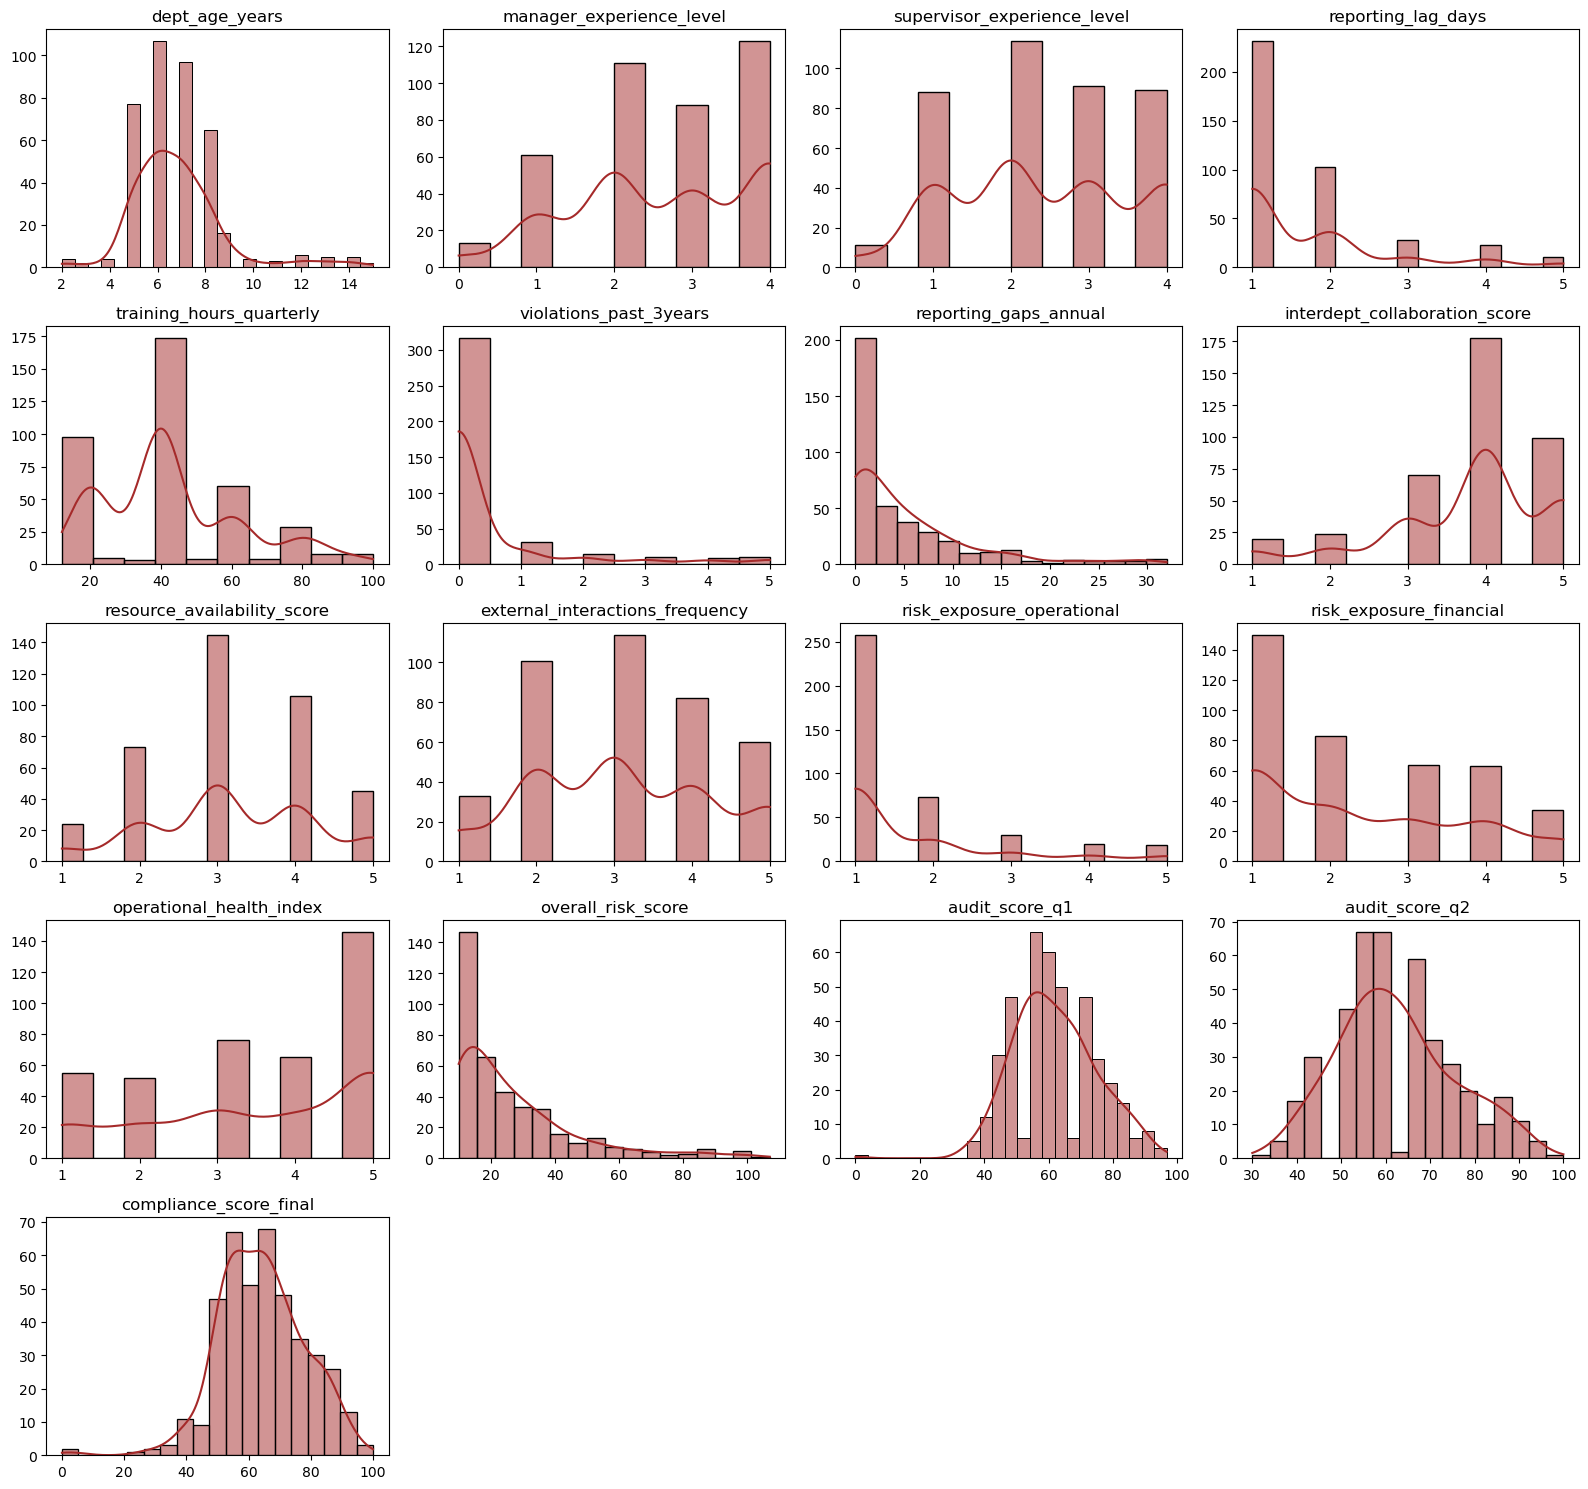

In [2022]:
n_cols = 4  # number of plots per row
n_rows = math.ceil(len(numerical_cols) / n_cols)

plt.figure(figsize=(4 * n_cols, 3 * n_rows))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(departments[col].dropna(), kde=True, color='brown')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

---
There exist a few clear outliers we want to remove from the dataset:
- In audit_score_q1 a few observations are equal to 0 which is almost impossible -> these should be set to NaN.
- There is overall_risk_score > 100, which is very unlikely, so these should be also set to NaN.
- In the compliance_score_final, compliance for some observations was very close to 0, however, lies within the appropriate range [0,100]. Therefore, we can't remove these values. But they will be clearly interesting for the later analysis as extremely non compliant, so we should flag them.

For scale variables there are no continueous values.

However, before we set outliers to NaN, we should first explore these variables closer to prove the point.

---

**audit_score_q1**

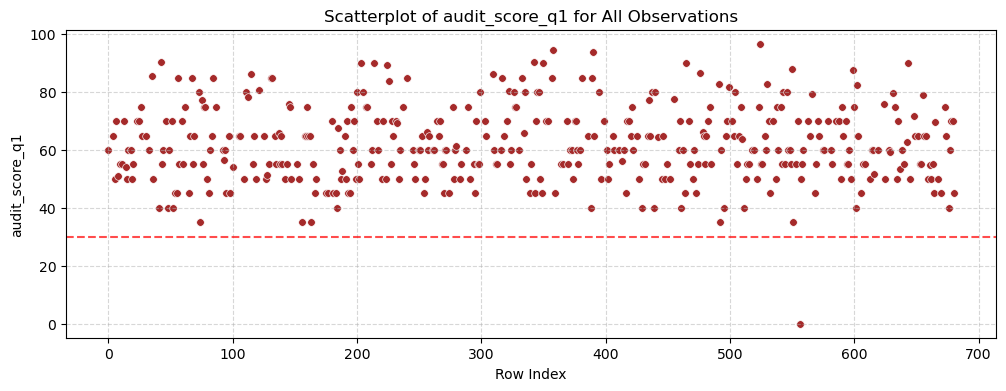

In [2025]:
# Scatterplot of audit_score_q1
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['audit_score_q1'],
    color='brown',
    s=30
)

plt.xlabel("Row Index")
plt.ylabel("audit_score_q1")
plt.title("Scatterplot of audit_score_q1 for All Observations")
plt.axhline(30, color='red', linestyle='--', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Outlier confirmed and is clearly < 30. We set it to NaN.

---

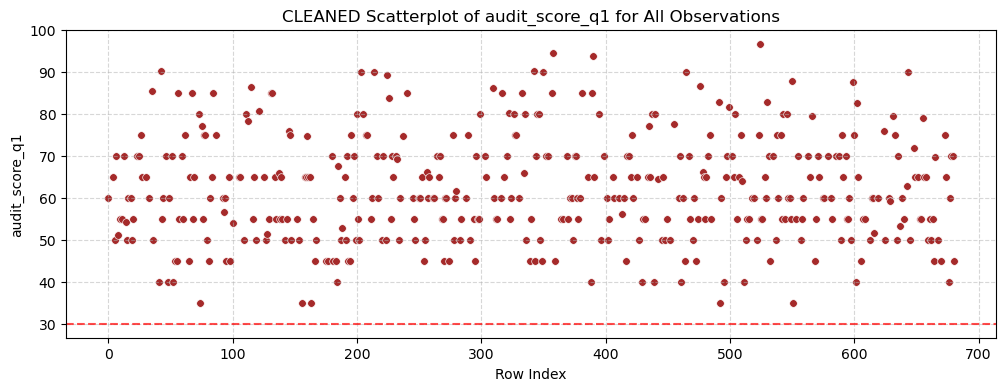

In [2027]:
outlier_mask = departments['audit_score_q1'] < 30

departments.loc[outlier_mask, 'audit_score_q1'] = np.nan

# controll check
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['audit_score_q1'],
    color='brown',
    s=30
)

plt.xlabel("Row Index")
plt.ylabel("audit_score_q1")
plt.title("CLEANED Scatterplot of audit_score_q1 for All Observations")
plt.axhline(30, color='red', linestyle='--', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**overall_risk_score**

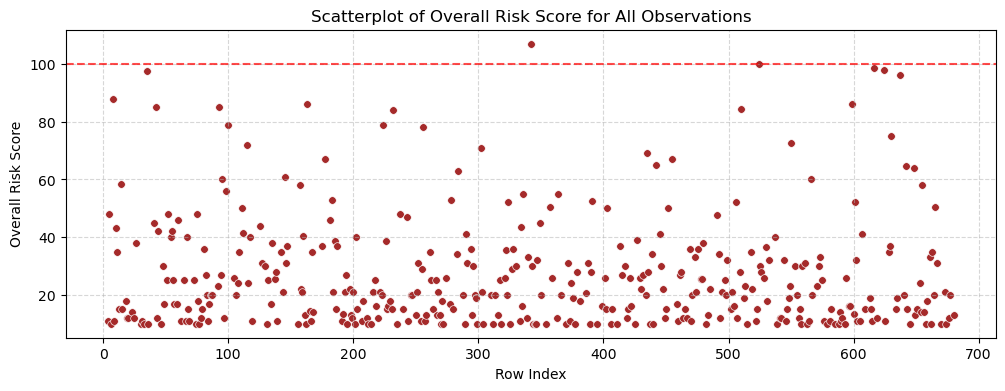

In [2029]:
# Scatterplot of overall_risk_score
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['overall_risk_score'],
    color='brown',
    s=30
)

plt.xlabel("Row Index")
plt.ylabel("Overall Risk Score")
plt.title("Scatterplot of Overall Risk Score for All Observations")
plt.axhline(100, color='red', linestyle='--', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Outlier confirmed and is clearly > 100. We set it to NaN.

---

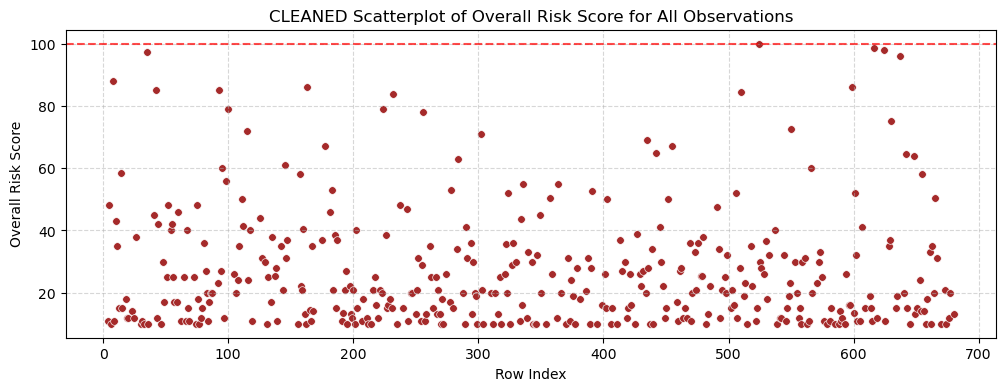

In [2031]:
# Set extreme high values (>100) to NaN for overall_risk_score
departments.loc[departments['overall_risk_score'] > 100, 'overall_risk_score'] = np.nan
# controll check
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['overall_risk_score'],
    color='brown',
    s=30
)

plt.xlabel("Row Index")
plt.ylabel("Overall Risk Score")
plt.title("CLEANED Scatterplot of Overall Risk Score for All Observations")
plt.axhline(100, color='red', linestyle='--', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**compliance_score_final**

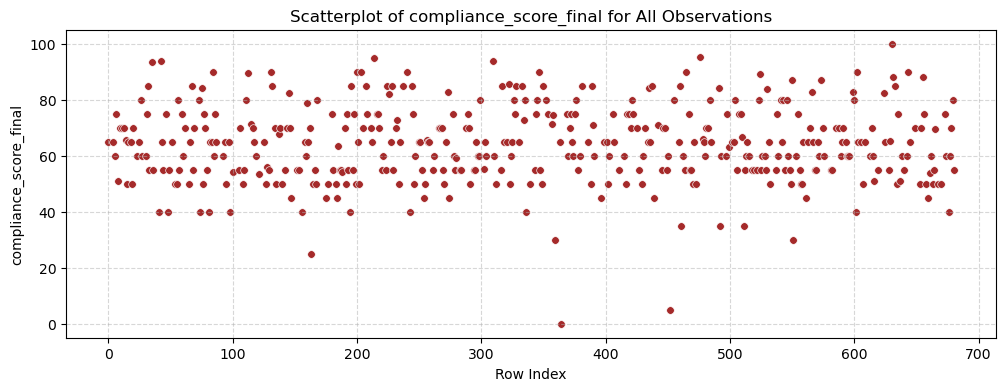

In [2033]:
# Scatterplot of overall_risk_score
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['compliance_score_final'],
    color='brown',
    s=30  # marker size
)

plt.xlabel("Row Index")
plt.ylabel("compliance_score_final")
plt.title("Scatterplot of compliance_score_final for All Observations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Two values are clearly smaller than 20. We flag them.

---

In [2035]:
# Flag extremely low compliance (<=20)
departments['extreme_non_compliance'] = (departments['compliance_score_final'] <= 20).astype(int)

#### **Boolean variables**

For boolean variables, twe check for continious variables.

---

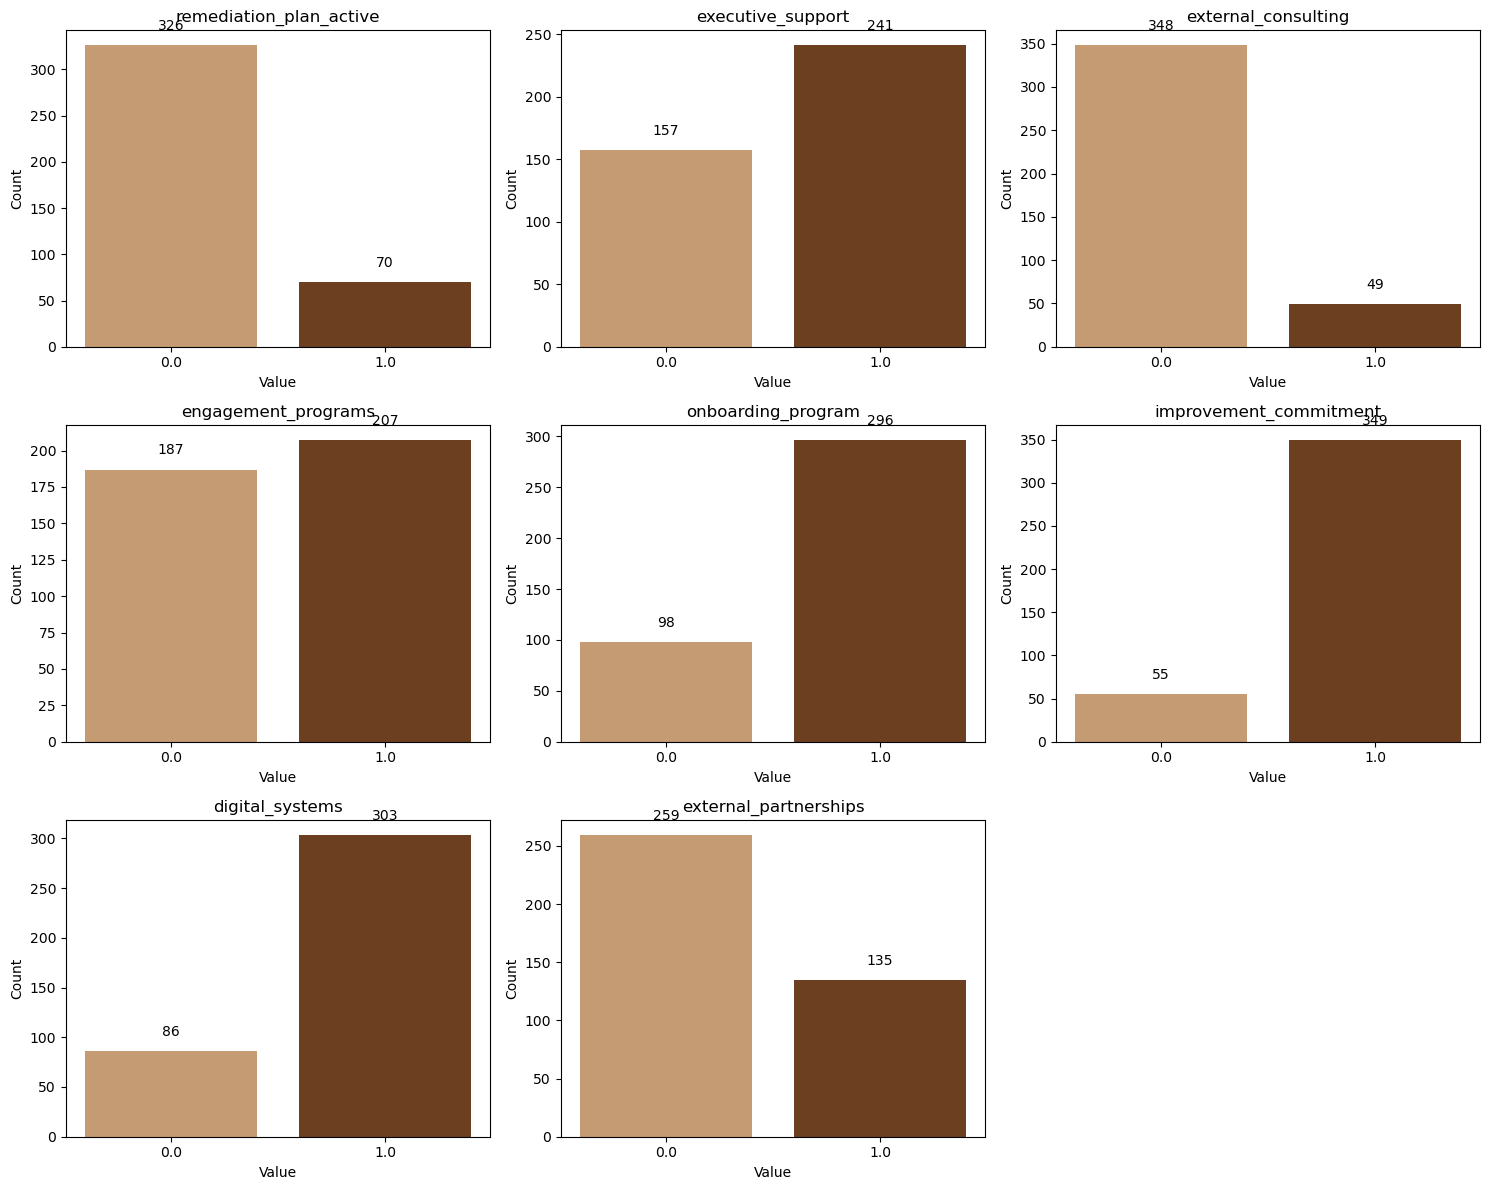

In [2038]:
# List of boolean columns
bool_cols_for_outliers = [col for col in bool_cols]

# Figure layout
n_cols = 3
n_rows = (len(bool_cols_for_outliers) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # flatten in case of multiple rows

for i, col in enumerate(bool_cols_for_outliers):
    counts = departments[col].value_counts().sort_index()
    axes[i].bar(counts.index.astype(str), counts.values, color=["#c49b72", "#6b3f1f"])
    axes[i].set_title(col)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("Value")
    for j, val in enumerate(counts.values):
        axes[i].text(j, val + 0.05 * max(counts.values), str(val), ha='center')

# Hide empty subplots
for i in range(len(bool_cols_for_outliers), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

---
For boolean variables there are no continueous values.

---

#### **Categorical columns**

For categorical variables, we check frequence outliers.

---

In [2042]:
# Exclude dept_id
categorical_cols_no_id = [c for c in categorical_cols if c != "dept_id"]

cat_dist_list = []

for col in categorical_cols_no_id:
    counts = departments[col].value_counts()
    perc = departments[col].value_counts(normalize=True) * 100

    tmp = pd.DataFrame({
        "feature": col,
        "category": counts.index,
        "count": counts.values,
        "share_%": perc.round(1).values
    })

    cat_dist_list.append(tmp)

cat_distribution = pd.concat(cat_dist_list, ignore_index=True)

# Compact summary: how many categories + smallest / largest share for each feature
cat_summary = (
    cat_distribution
    .groupby("feature")
    .agg(
        n_categories=("category", "nunique"),
        min_share=("share_%", "min"),
        max_share=("share_%", "max"),
    )
    .round(1)
    .reset_index()
)

cat_summary


feature  n_categories  min_share  max_share
0        dept_category             3        3.5       58.9
1            dept_type             6        2.8       50.1
2             division             2        6.2       93.8
3        location_type             4        3.0       74.7
4       oversight_body             4        2.0       67.7
5     primary_function             7        2.5       34.5
6  reporting_structure             3        3.8       80.7
7            team_size             3        4.8       65.6

---
Even the smallest categories are not small enough to combine them with some other categories so we don't modify anything at this stage.

---

### **Summary statistics**

In [2045]:
# Summary statistics for numerical_col
distribution_summary = departments[numerical_cols].describe().T  # transpose for readability

distribution_summary = distribution_summary.round(2)
distribution_summary

count   mean    std   min   25%   50%   75%  \
dept_age_years                   397.0   6.83   1.94   2.0   6.0   7.0   8.0   
manager_experience_level         396.0   2.62   1.17   0.0   2.0   3.0   4.0   
supervisor_experience_level      393.0   2.40   1.15   0.0   1.0   2.0   3.0   
reporting_lag_days               397.0   1.69   1.02   1.0   1.0   1.0   2.0   
training_hours_quarterly         393.0  43.26  19.79  12.0  21.0  40.0  60.0   
violations_past_3years           392.0   0.45   1.13   0.0   0.0   0.0   0.0   
reporting_gaps_annual            398.0   5.14   6.56   0.0   0.0   2.0   8.0   
interdept_collaboration_score    391.0   3.80   1.05   1.0   3.0   4.0   5.0   
resource_availability_score      393.0   3.19   1.06   1.0   3.0   3.0   4.0   
external_interactions_frequency  390.0   3.09   1.19   1.0   2.0   3.0   4.0   
risk_exposure_operational        399.0   1.66   1.10   1.0   1.0   1.0   2.0   
risk_exposure_financial          394.0   2.36   1.35   1.0   1.0   2.0   3.0   
operational_health_index         394.0   3.49   1.45   1.0   2.0   4.0   5.0   
overall_risk_score               393.0  26.69  18.91  10.0  12.0  20.0  34.0   
audit_score_q1                   413.0  62.10  12.63  35.0  55.0  60.0  70.0   
audit_score_q2                   420.0  62.36  13.35  30.0  55.0  60.0  70.0   
compliance_score_final           416.0  64.11  13.74   0.0  55.0  65.0  75.0   

                                   max  
dept_age_years                    15.0  
manager_experience_level           4.0  
supervisor_experience_level        4.0  
reporting_lag_days                 5.0  
training_hours_quarterly         100.0  
violations_past_3years             5.0  
reporting_gaps_annual             32.0  
interdept_collaboration_score      5.0  
resource_availability_score        5.0  
external_interactions_frequency    5.0  
risk_exposure_operational          5.0  
risk_exposure_financial            5.0  
operational_health_index           5.0  
overall_risk_score               100.0  
audit_score_q1                    96.7  
audit_score_q2                   100.0  
compliance_score_final           100.0

---
From this summary we derive three very important features:
- compliance_score_final ranges from 0 to 100, with the 25th percentile at 55. This means the bottom 25% of departments score 55 or lower — clearly below typical compliance levels. As we need to define non-compliance, we set non-compliance = compliance_score_final <= 55, focusing on the departments most at risk. **Low Compliance: 0 - 55, Moderate Compliance: 55–75, High Compliance: 75-100**.
- for overall_risk_score, we are most interested in finding very high scores rather than very low. Following the same logic as for the compliance_score_final, we obtain **Low Risk: 10 – 20** (up to median), **Moderate Risk: 21 – 34** (median to 75th percentile) which are departments that may need attention but are not immediately critical, **High Risk: 35 – 100** (above 75th percentile), which are departments likely to have compliance issues, operational exposure, or financial risks.

These classifications will be used further for modeling.

---

### **Logical Inconsistencies**

We have already checked in the Outliers check section that all values lay within the appropriate range. If they did not, we set them to NaN. Now we will check our dataset for the following logical inconsistency:
- Audit scores are absent, but compliance score exists.

---

In [2049]:
is_final_score_missing = departments['compliance_score_final'].isna()

# Audits are present (i.e., EITHER Q1 score is NOT NaN OR Q2 score is NOT NaN)
is_audit_present = departments['audit_score_q1'].notna() | departments['audit_score_q2'].notna()

inconsistent_scores = departments[is_final_score_missing & is_audit_present]

print("--- Cross-Column Validation Check ---")
print(f"Number of inconsistencies (Final Score Missing BUT Audit Data Present): {len(inconsistent_scores)}")

if len(inconsistent_scores) > 0:
    print("Inconsistent Dept IDs (First 5):")
    # Using .head() to only show the first few IDs
    print(inconsistent_scores['dept_id'].head().tolist())

--- Cross-Column Validation Check ---
Number of inconsistencies (Final Score Missing BUT Audit Data Present): 22
Inconsistent Dept IDs (First 5):
['DEPT-1133', 'DEPT-1752', 'DEPT-2279', 'DEPT-2792', 'DEPT-2995']


---
We will check if any of these ids are part of the high_risk_departments table, and if they are, we cannot drop them, otherwise we will drop these rows.

---

In [2051]:
# Check which inconsistent departments are considered high risk
inconsistent_scores_high_risk = inconsistent_scores[inconsistent_scores['present_in_high_risk_departments'] == 1]

print(f"Number of inconsistent departments flagged as high risk: {len(inconsistent_scores_high_risk)}")

if len(inconsistent_scores_high_risk) > 0:
    print("Dept IDs of inconsistent departments flagged as high risk:")
    display(inconsistent_scores_high_risk['dept_id'])
else:
    print("No inconsistent departments are flagged as high risk.")

Number of inconsistent departments flagged as high risk: 8
Dept IDs of inconsistent departments flagged as high risk:


10     DEPT-1133
52     DEPT-1752
93     DEPT-2279
157    DEPT-2995
342    DEPT-5329
377    DEPT-5849
535    DEPT-8087
648    DEPT-9653
Name: dept_id, dtype: object

---
Here we can see that we have 8 of these ID's which are added in the high_risk_departemnts table, so we will flag the 8 and drop the rest 14

---

In [2053]:
# Flag the 8 inconsistent departments that are in high_risk_departments
departments['audit_scores_missing'] = 0
departments.loc[inconsistent_scores_high_risk.index, 'audit_scores_missing'] = 1

# Drop the remaining inconsistent rows that are NOT in high_risk_departments
to_drop = inconsistent_scores.index.difference(inconsistent_scores_high_risk.index)
departments.drop(index=to_drop, inplace=True)

# Reset index
departments.reset_index(drop=True, inplace=True)

# Quick check
print(f"Remaining inconsistent rows: {(departments['compliance_score_final'].isna() &
                                        (departments['audit_score_q1'].notna() |
                                         departments['audit_score_q2'].notna())).sum()}")
print("Flagged audit_scores_missing:")
display(departments[departments['audit_scores_missing'] == 1]['dept_id'])

Remaining inconsistent rows: 8
Flagged audit_scores_missing:


10     DEPT-1133
52     DEPT-1752
93     DEPT-2279
156    DEPT-2995
337    DEPT-5329
371    DEPT-5849
524    DEPT-8087
635    DEPT-9653
Name: dept_id, dtype: object

### **Missing Values**

#### **Overview**

In [2056]:
# Count missing values per column
missing_counts = departments.isnull().sum()
missing_percent = (missing_counts / len(departments) * 100).round(2)

missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
}).sort_values(by='missing_percent', ascending=False)

display(missing_summary)

missing_count  missing_percent
external_interactions_frequency             292            43.71
digital_systems                             291            43.56
interdept_collaboration_score               290            43.41
overall_risk_score                          289            43.26
oversight_body                              288            43.11
resource_availability_score                 288            43.11
violations_past_3years                      288            43.11
engagement_programs                         288            43.11
onboarding_program                          287            42.96
operational_health_index                    287            42.96
risk_exposure_financial                     287            42.96
external_partnerships                       287            42.96
training_hours_quarterly                    287            42.96
supervisor_experience_level                 287            42.96
team_size                                   286            42.81
location_type                               285            42.66
external_consulting                         285            42.66
remediation_plan_active                     285            42.66
manager_experience_level                    284            42.51
reporting_lag_days                          284            42.51
dept_type                                   284            42.51
reporting_gaps_annual                       284            42.51
executive_support                           283            42.37
dept_age_years                              283            42.37
reporting_structure                         283            42.37
risk_exposure_operational                   281            42.07
primary_function                            279            41.77
improvement_commitment                      276            41.32
audit_score_q1                              269            40.27
audit_score_q2                              261            39.07
compliance_score_final                      252            37.72
division                                    244            36.53
extreme_non_compliance                        0             0.00
present_in_high_risk_departments              0             0.00
dept_id                                       0             0.00
dept_category                                 0             0.00
audit_scores_missing                          0             0.00

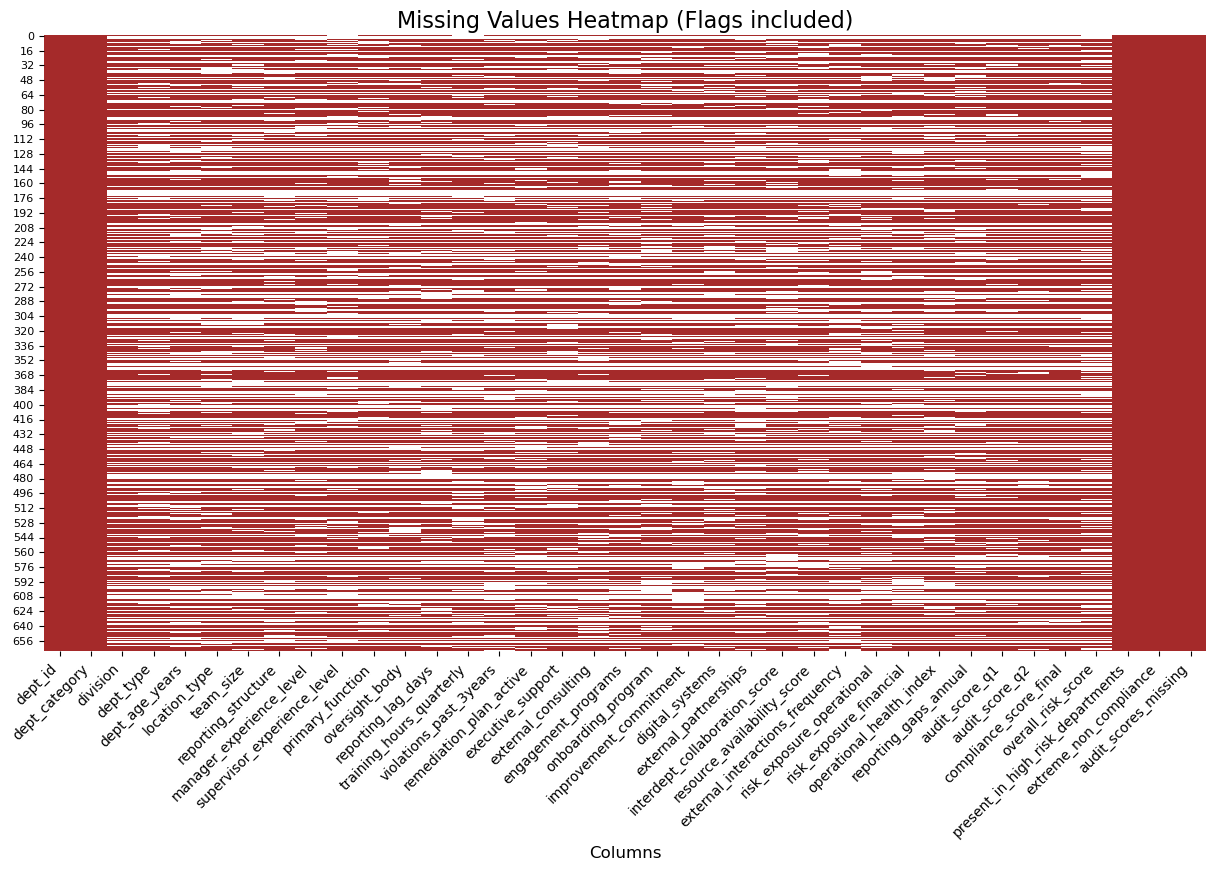

In [2057]:
plt.figure(figsize=(15,8))

sns.heatmap(
    departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap (Flags included)', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

---
In `departments` there is substantial missing data in the dataset (around 36–43% per column).

However, our key categorical identifier variables — dept_id, and dept_category — contain no missing values.

Because these columns are complete, we can reliably group the dataset by these identifiers to examine whether the missingness in other variables is associated with specific departments or department categories to see if missing data is random or systematically related to certain groups of observations.

---

#### **Missingness by dept_category**

In [2060]:
#columns to exclude
analytic_cols = departments.columns.difference(['dept_id', 'dept_category', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing' ])

missing_by_category = departments.groupby('dept_category')[analytic_cols].apply(
    lambda x: x.isnull().sum(),
    include_groups=False
)
display(missing_by_category)

grouped = departments.groupby('dept_category', dropna=False)
total_cells = grouped.size() * departments.shape[1]
missing_cells = grouped[analytic_cols].apply(lambda g: g.isna().sum().sum(), include_groups=False)
missing_rate = (missing_cells / total_cells) * 100

print("--- Overall Data Integrity Rate by Category ---")
print(missing_rate.round(2))

audit_score_q1  audit_score_q2  \
dept_category                                            
Financial_Reporting                 21              15   
Operational_Compliance             246             244   
Risk_Management                      2               2   

                        compliance_score_final  dept_age_years  dept_type  \
dept_category                                                               
Financial_Reporting                          3              34         35   
Operational_Compliance                     245             244        245   
Risk_Management                              4               5          4   

                        digital_systems  division  engagement_programs  \
dept_category                                                            
Financial_Reporting                  41         0                   40   
Operational_Compliance              245       244                  247   
Risk_Management                       5         0                    1   

                        executive_support  external_consulting  ...  \
dept_category                                                   ...   
Financial_Reporting                    38                   39  ...   
Operational_Compliance                244                  244  ...   
Risk_Management                         1                    2  ...   

                        reporting_gaps_annual  reporting_lag_days  \
dept_category                                                       
Financial_Reporting                        37                  39   
Operational_Compliance                    245                 244   
Risk_Management                             2                   1   

                        reporting_structure  resource_availability_score  \
dept_category                                                              
Financial_Reporting                      37                           39   
Operational_Compliance                  245                          245   
Risk_Management                           1                            4   

                        risk_exposure_financial  risk_exposure_operational  \
dept_category                                                                
Financial_Reporting                          37                         32   
Operational_Compliance                      245                        246   
Risk_Management                               5                          3   

                        supervisor_experience_level  team_size  \
dept_category                                                    
Financial_Reporting                              42         38   
Operational_Compliance                          244        246   
Risk_Management                                   1          2   

                        training_hours_quarterly  violations_past_3years  
dept_category                                                             
Financial_Reporting                           39                      42  
Operational_Compliance                       245                     245  
Risk_Management                                3                       1  

[3 rows x 32 columns]

--- Overall Data Integrity Rate by Category ---
dept_category
Financial_Reporting        7.74
Operational_Compliance    82.74
Risk_Management            8.56
dtype: float64


---
**Here we see a pattern:** most data is missing for 'Operational_Compliance'. Then data is almost equally missing for 'Financial_Reporting' and 'Risk_Management' category. These are the categories of rules that departments have to deal with. Therefore, when departments deal with 'Operational_Compliance' rules, the data becomes missing. Why? What is the correlation between the data being missing and this type of rules?

We will find the answer later in the next section.

---

#### **Missingness by division**

'division' has the least percent of missing values (37%) out of all columns with missing values, therefore, we can check the missingness by division too.

---

In [2064]:
# Columns to exclude
analytic_cols = departments.columns.difference(['dept_id', 'dept_category', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing' ])

missing_by_division = departments.groupby('division')[analytic_cols].apply(lambda x: x.isna().sum())
display(missing_by_division)
grouped_data = departments.groupby('division', dropna=False)
total_cells_per_division = grouped_data.size() * len(analytic_cols)
total_missing_per_division = grouped_data[analytic_cols].apply(lambda x: x.isna().sum().sum())

# Missing rate per division (%)
overall_missing_rate = (total_missing_per_division / total_cells_per_division) * 100

print("--- Overall Data Integrity Rate by Division  ---")
final_rates = overall_missing_rate.round(2)
display(final_rates)

audit_score_q1  audit_score_q2  compliance_score_final  \
division                                                                      
Corporate_HQ                     22              14                       6   
Regional_Operations               3               3                       2   

                     dept_age_years  dept_type  digital_systems  division  \
division                                                                    
Corporate_HQ                     35         36               43         0   
Regional_Operations               4          4                4         0   

                     engagement_programs  executive_support  \
division                                                      
Corporate_HQ                          43                 39   
Regional_Operations                    1                  0   

                     external_consulting  ...  reporting_gaps_annual  \
division                                  ...                          
Corporate_HQ                          39  ...                     36   
Regional_Operations                    2  ...                      4   

                     reporting_lag_days  reporting_structure  \
division                                                       
Corporate_HQ                         39                   35   
Regional_Operations                   1                    4   

                     resource_availability_score  risk_exposure_financial  \
division                                                                    
Corporate_HQ                                  41                       38   
Regional_Operations                            3                        5   

                     risk_exposure_operational  supervisor_experience_level  \
division                                                                      
Corporate_HQ                                34                           41   
Regional_Operations                          3                            2   

                     team_size  training_hours_quarterly  \
division                                                   
Corporate_HQ                40                        41   
Regional_Operations          2                         2   

                     violations_past_3years  
division                                     
Corporate_HQ                             41  
Regional_Operations                       3  

[2 rows x 32 columns]

--- Overall Data Integrity Rate by Division  ---


division
Corporate_HQ             8.90
Regional_Operations      9.86
NaN                    100.00
dtype: float64

---
Here we see another pattern: 'Corporate_HQ' division, according to the first table, misses far more values than Regional_Operations. However, it is an illusion arising from the fact that a lot of departments (428) belong to the Corpoprate_HQ and only 27 departments belong to the Regional Operations division (from divisions table). In fact, the percentage of missing values in these two divisions is almost the same (around 9%).

What's more interesting, the missing division information (NaN) has an extremely high percent of missing data (100%). This is the strong proof that if the division information is missing -> everything else (exept for the 'dept_id', 'dept_category') is missing. Therefore, these rows, where division is missing, are useless:
- non-usable for modeling
- non-recoverable (too much missing data)

Therefore, we shoul drop them. But before, we want to find out another interesting detail: do all missing rows belong to the Operational_Compliance category?

---

In [2066]:
# Rows where division is missing
missing_division_rows = departments[departments['division'].isna()]

total_missing_division = missing_division_rows.shape[0]

# Number of rows with missing division that belong to Operational_Compliance
missing_div_opcompliance = (missing_division_rows['dept_category'] == 'Operational_Compliance').sum()

print(f"Total rows with missing division: {total_missing_division}")
print(f"Rows with missing division and category 'Operational_Compliance': {missing_div_opcompliance}")

Total rows with missing division: 244
Rows with missing division and category 'Operational_Compliance': 244


---
The hypothesis is confirmed: there is a perfect overlap: **missing division -> missing data -> Operational_Compliance** category.

But are there any departments which deal with Operational_Compliance rules which actually submitted their data?

---

In [2068]:
# Exclude the constant columns
exclude_cols = ['dept_id', 'dept_category', 'division']
analytic_cols = departments.columns.difference(exclude_cols)

# Mask for Operational_Compliance category
mask_op_compliance = departments['dept_category'] == 'Operational_Compliance'

# Check rows with AT LEAST ONE non-missing value in analytical columns
op_compliance_not_missing = departments.loc[mask_op_compliance, analytic_cols].dropna(how='all')

print(f"Number of Operational_Compliance rows with at least some data: {op_compliance_not_missing.shape[0]}")

Number of Operational_Compliance rows with at least some data: 256


---
Yes, there are 12 such departments. So the question now is: Why did these 12 departments manage to submit their data while the others did not?

Unfortunately, we cannot answer this question with the current dataset. Even if we analyze these 12 departments, we cannot compare them to the departments with missing values, because all the analytical columns are missing for the others. Only the dept_id ispresent, but this does not provide any meaningful information for analysis.

We have the last thing to check before we drop these departments with missing values: Does any of them belong to the table 'high_risk_departments'? This is meaningful, because the table 'high_risk_departments' shows departments already marked as risky and if any of the departments that we are going to drop will appear in this table, we can lose an important detail in analysing what makes departments risky. Maybe lack of values makes departments risky - we don't know yet.

---

In [2070]:
# Select departments with missing division
missing_division_rows = departments[departments['division'].isna()]

# Find which of these departments are in high_risk_departments
matching_high_risk = high_risk_departments[
    high_risk_departments['dept_id'].isin(missing_division_rows['dept_id'])
]

# Display the departments as they are in the departments table
if not matching_high_risk.empty:
    print("Departments with missing division in the departments table:")
    display(missing_division_rows[
        missing_division_rows['dept_id'].isin(matching_high_risk['dept_id'])
    ])

    print("Same departments in the high_risk_departments table:")
    display(matching_high_risk)
else:
    print("No departments with missing division are in high_risk_departments.")

Departments with missing division in the departments table:


dept_id           dept_category division dept_type  dept_age_years  \
102  DEPT-2377  Operational_Compliance     None      None             NaN   
315  DEPT-5023  Operational_Compliance     None      None             NaN   

    location_type team_size reporting_structure  manager_experience_level  \
102          None      None                None                       NaN   
315          None      None                None                       NaN   

     supervisor_experience_level  ... risk_exposure_financial  \
102                          NaN  ...                     NaN   
315                          NaN  ...                     NaN   

    operational_health_index  reporting_gaps_annual  audit_score_q1  \
102                      NaN                    NaN             NaN   
315                      NaN                    NaN             NaN   

     audit_score_q2  compliance_score_final  overall_risk_score  \
102             NaN                     NaN                 NaN   
315             NaN                     NaN                 NaN   

     present_in_high_risk_departments  extreme_non_compliance  \
102                                 1                       0   
315                                 1                       0   

     audit_scores_missing  
102                     0  
315                     0  

[2 rows x 37 columns]

Same departments in the high_risk_departments table:


dept_id        dept_category      division dept_type  dept_age_years  \
50  DEPT-5023  Financial_Reporting  Corporate_HQ   Support             6.0   
58  DEPT-2377  Financial_Reporting  Corporate_HQ      None             NaN   

   location_type team_size reporting_structure  manager_experience_level  \
50         Urban     Large         Centralized                       1.0   
58         Urban     Small          Autonomous                       4.0   

    supervisor_experience_level  ... resource_availability_score  \
50                          1.0  ...                         5.0   
58                          4.0  ...                         1.0   

   external_interactions_frequency  risk_exposure_operational  \
50                             5.0                        5.0   
58                             3.0                        3.0   

    risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
50                      5.0                       5.0                    0.0   
58                      5.0                       5.0                    6.0   

    audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  
50            50.0            50.0                    80.0                50.0  
58            45.0            45.0                    50.0                43.0  

[2 rows x 34 columns]

---
This comparison provided us with a great insight:

We can drop the rows with missing division information AND even those present in the high_risk_departments. Why? Because of the following reasoning:

1. Do all departments with missing values appear in the high_risk_departments? - No. So having all missing values is not equal to being risky.
2. Do missing overall_risk_score AND compliance_score_final make a department risky? - No (from conclusion 1).
3. Did these departments appear as risky because of the manual imputation? - Yes. So we initially didn't know anything about these departments and we know that the full missing data does not make a department risky. Therefore, all values for these departments were imputed with values that MADE them risky -> they appear as risky by accident.
4. Therefore, we should drop all departments with missing division.

To make sure that data missingness is not correlated with risk, we check correlation between missing values and compliance or risk

---

#### **Correlation between missing values and compliance or risk**

---
> The last thing about missing values we need to find before moving on to handling them: Is there any correlation between the missing values and the compliance or risk? Because if there is, then something about the missing data can affect the compliance or risk and we want to know what before handling missing values. Perhaps the number of missing values negatively correlates with the compliance and positively correlates with risk.
>
---

In [2074]:
# Fraction of missing values per row
row_missing_rate = departments[analytic_cols].isna().mean(axis=1)

compliance_col = 'compliance_score_final'
risk_col = 'overall_risk_score'

correlation_compliance = row_missing_rate.corr(departments[compliance_col])
correlation_risk = row_missing_rate.corr(departments[risk_col])

print(f"Correlation between missingness and compliance_score:final: {correlation_compliance:.3f}")
print(f"Correlation between missingness and overall_risk_score: {correlation_risk:.3f}")

Correlation between missingness and compliance_score:final: 0.035
Correlation between missingness and overall_risk_score: 0.019


---
Correlation with compliance (0.35) → very low, meaning the amount of missing data does not systematically affect compliance scores.


Correlation with risk (0.019) → essentially zero, so missing data is not predictive of risk either.

In other words, based on this dataset:

Departments with more missing values are not inherently riskier.
Missingness seems to be mostly structural (like Operational_Compliance departments not submitting data), not related to the outcome variables.

Therefore, we should drop all rows with missing division.

---

In [2076]:
# Identify department IDs with missing division
missing_div_dept_ids = departments.loc[departments['division'].isna(), 'dept_id']

# Drop from departments
departments = departments[~departments['dept_id'].isin(missing_div_dept_ids)].copy()

# Drop from high_risk_departments
high_risk_clean = high_risk_departments[
    ~high_risk_departments['dept_id'].isin(missing_div_dept_ids)
].copy()

print(f"Dropped {len(missing_div_dept_ids)} departments with missing division.")

Dropped 244 departments with missing division.


In [2077]:
departments.shape

(424, 37)

In [2078]:
high_risk_departments.shape

(200, 34)

#### **high_risk_departments** table

---
So far we analysed missing values in the `departments` table. Now we can look at two other improtant tables: `high_risk_departments` and `risk_summary_by_departments`

---

In [2081]:
num_rows, num_columns = high_risk_departments.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")
high_risk_departments.head()

Number of rows: 200
Number of columns: 34


dept_id        dept_category      division   dept_type  dept_age_years  \
0  DEPT-1133  Financial_Reporting  Corporate_HQ  Compliance             8.0   
1  DEPT-4312  Financial_Reporting  Corporate_HQ  Operations             6.0   
2  DEPT-3347  Financial_Reporting  Corporate_HQ  Operations             6.0   
3  DEPT-2554  Financial_Reporting  Corporate_HQ     Support             5.0   
4  DEPT-3151  Financial_Reporting  Corporate_HQ        None             8.0   

  location_type team_size reporting_structure  manager_experience_level  \
0         Urban     Large         Centralized                       2.0   
1         Urban     Small         Centralized                       1.0   
2         Urban     Small         Centralized                       2.0   
3         Urban     Small          Autonomous                       3.0   
4         Urban     Small         Centralized                       3.0   

   supervisor_experience_level  ... resource_availability_score  \
0                          2.0  ...                         4.0   
1                          NaN  ...                         4.0   
2                          1.0  ...                         4.0   
3                          3.0  ...                         3.0   
4                          3.0  ...                         2.0   

  external_interactions_frequency  risk_exposure_operational  \
0                             NaN                        2.0   
1                             2.0                        1.0   
2                             4.0                        3.0   
3                             4.0                        4.0   
4                             4.0                        NaN   

   risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
0                      2.0                       1.0                   26.0   
1                      1.0                       5.0                    2.0   
2                      5.0                       5.0                    6.0   
3                      4.0                       1.0                    0.0   
4                      4.0                       4.0                   10.0   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  
0             NaN            40.0                     NaN                43.0  
1            45.0            45.0                    45.0                11.0  
2            45.0            50.0                    50.0                53.0  
3            65.0            60.0                    65.0                40.0  
4            50.0            50.0                    50.0                35.0  

[5 rows x 34 columns]

In [2082]:
# Missing values per column
missing_high_risk = high_risk_departments.isna().sum()

# Missing percentage
missing_high_risk_percent = (missing_high_risk / high_risk_departments.shape[0]) * 100

# Create DataFrame
missing_df = pd.DataFrame({
    'missing_count': missing_high_risk,
    'missing_percent': missing_high_risk_percent
}).sort_values('missing_percent', ascending=False)

display(missing_df)

missing_count  missing_percent
dept_age_years                              28             14.0
violations_past_3years                      28             14.0
oversight_body                              25             12.5
digital_systems                             23             11.5
team_size                                   22             11.0
external_interactions_frequency             22             11.0
onboarding_program                          22             11.0
training_hours_quarterly                    21             10.5
dept_type                                   21             10.5
location_type                               21             10.5
manager_experience_level                    21             10.5
interdept_collaboration_score               21             10.5
engagement_programs                         20             10.0
overall_risk_score                          20             10.0
reporting_lag_days                          20             10.0
reporting_structure                         20             10.0
remediation_plan_active                     19              9.5
supervisor_experience_level                 19              9.5
risk_exposure_operational                   18              9.0
operational_health_index                    18              9.0
executive_support                           17              8.5
risk_exposure_financial                     17              8.5
resource_availability_score                 16              8.0
external_consulting                         16              8.0
primary_function                            16              8.0
external_partnerships                       15              7.5
reporting_gaps_annual                       14              7.0
improvement_commitment                      12              6.0
audit_score_q1                              11              5.5
audit_score_q2                               8              4.0
compliance_score_final                       7              3.5
dept_category                                0              0.0
division                                     0              0.0
dept_id                                      0              0.0

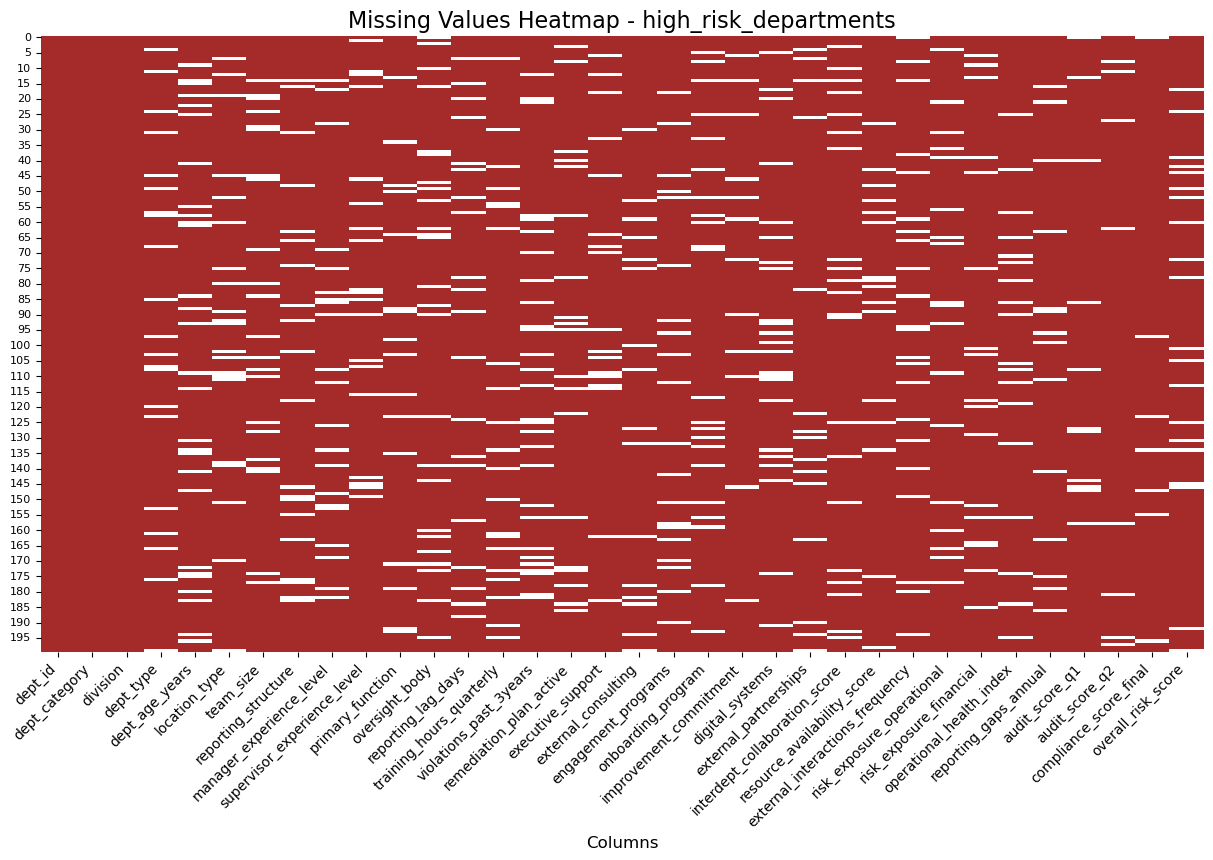

In [2083]:
plt.figure(figsize=(15, 8))
sns.heatmap(
    high_risk_departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)
plt.title(f'Missing Values Heatmap - high_risk_departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

---
This table was already cleaned, there is much less missing data (around 10-14%).

---

### **Handling missing data**

Now we are going to compare two potential imputation procedures:

**Procedure 1**: We impute missing values in departments table with those present in high_risk_departments table. Other missing values we impute with median (numerical) and mode (categorical + boolean). The same method we apply to the high_risk_departments. Compare how similar the rows in high_risk_departments are to those in departments.

**Procedure 2**: We impute missing values with median (numerical) and mode (categorical + boolean) in both tables and compare how similar the rows in high_risk_departments are to those in departments.

To compare Procedures:

1. Compute statistics from the risk_summary_by_division table for both methods and see which keeps the original data patterns.
2. Look at numerical values distribution. Compare with the original table. Adopt the procedure that better keeps original data patterns.


---

In [2087]:
# creating copies of departments and high_risk_departments tables
departments_copy_for_missing_imputation_1 = departments.copy()
high_risk_copy_for_missing_imputation_1 = high_risk_departments.copy()
departments_copy_for_missing_imputation_2 = departments.copy()
high_risk_copy_for_missing_imputation_2 = high_risk_departments.copy()

In [2088]:
# Columns to exclude from imputation
exclude_cols = ['dept_id', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing']

# Identify numerical and categorical columns
numerical_cols_copy = [c for c in numerical_cols if c not in exclude_cols] + bool_cols
categorical_cols_copy = [c for c in categorical_cols if c not in exclude_cols + ['dept_id']]

In [2089]:
# -----------------------------
# Procedure 1: Impute using high-risk reference
# -----------------------------

# Step 1: Impute departments_copy_for_missing_imputation_1 from high_risk_copy_for_missing_imputation_1
for idx, row in departments_copy_for_missing_imputation_1.iterrows():
    dept_id = row['dept_id']
    if dept_id in high_risk_copy_for_missing_imputation_1['dept_id'].values:
        hr_row = high_risk_copy_for_missing_imputation_1.loc[
            high_risk_copy_for_missing_imputation_1['dept_id'] == dept_id
        ].iloc[0]
        for col in numerical_cols_copy + categorical_cols_copy:
            if pd.isna(row[col]) and not pd.isna(hr_row[col]):
                departments_copy_for_missing_imputation_1.loc[idx, col] = hr_row[col]  # use .loc

# Step 2: Fill remaining missing values with median/mode
# Numerical → median
for col in numerical_cols_copy:
    median_val = departments_copy_for_missing_imputation_1[col].median()
    departments_copy_for_missing_imputation_1[col] = departments_copy_for_missing_imputation_1[col].fillna(median_val)
    high_risk_copy_for_missing_imputation_1[col] = high_risk_copy_for_missing_imputation_1[col].fillna(median_val)

# Categorical/Boolean → mode
for col in categorical_cols_copy:
    mode_val = departments_copy_for_missing_imputation_1[col].mode()[0]
    departments_copy_for_missing_imputation_1[col] = departments_copy_for_missing_imputation_1[col].fillna(mode_val)
    high_risk_copy_for_missing_imputation_1[col] = high_risk_copy_for_missing_imputation_1[col].fillna(mode_val)

# -----------------------------
# Step 3: Compare similarity
# -----------------------------
def row_similarity(row1, row2, cols):
    matches = sum(row1[c] == row2[c] for c in cols)
    return matches / len(cols) * 100

similarities = []
for idx, hr_row in high_risk_copy_for_missing_imputation_1.iterrows():
    dept_id = hr_row['dept_id']
    if dept_id in departments_copy_for_missing_imputation_1['dept_id'].values:
        dep_row = departments_copy_for_missing_imputation_1.loc[
            departments_copy_for_missing_imputation_1['dept_id'] == dept_id
        ].iloc[0]
        sim = row_similarity(hr_row, dep_row, numerical_cols_copy + categorical_cols_copy)
        similarities.append({'dept_id': dept_id, 'similarity_percent': sim})

similarity_df_1 = pd.DataFrame(similarities).sort_values(by='similarity_percent', ascending=False)
similarity_df_1.head(2)

dept_id  similarity_percent
0   DEPT-1133               100.0
97  DEPT-1856               100.0

In [2090]:
# -----------------------------
# Procedure 2: Impute using median/mode only
# -----------------------------

# Step 1: Fill missing values with median/mode in both tables

# Numerical → median
for col in numerical_cols_copy:
    median_val = departments_copy_for_missing_imputation_2[col].median()
    departments_copy_for_missing_imputation_2[col] = departments_copy_for_missing_imputation_2[col].fillna(median_val)
    high_risk_copy_for_missing_imputation_2[col] = high_risk_copy_for_missing_imputation_2[col].fillna(median_val)

# Categorical/Boolean → mode
for col in categorical_cols_copy:
    mode_val = departments_copy_for_missing_imputation_2[col].mode()[0]
    departments_copy_for_missing_imputation_2[col] = departments_copy_for_missing_imputation_2[col].fillna(mode_val)
    high_risk_copy_for_missing_imputation_2[col] = high_risk_copy_for_missing_imputation_2[col].fillna(mode_val)

# -----------------------------
# Step 2: Compare similarity
# -----------------------------
similarities_2 = []
for idx, hr_row in high_risk_copy_for_missing_imputation_2.iterrows():
    dept_id = hr_row['dept_id']
    if dept_id in departments_copy_for_missing_imputation_2['dept_id'].values:
        dep_row = departments_copy_for_missing_imputation_2.loc[
            departments_copy_for_missing_imputation_2['dept_id'] == dept_id
        ].iloc[0]
        sim = row_similarity(hr_row, dep_row, numerical_cols_copy + categorical_cols_copy)
        similarities_2.append({'dept_id': dept_id, 'similarity_percent': sim})

similarity_df_2 = pd.DataFrame(similarities_2).sort_values(by='similarity_percent', ascending=False)
similarity_df_2.head(2)

dept_id  similarity_percent
0   DEPT-1133               100.0
97  DEPT-1856               100.0

In [2091]:
# compute statistics like in the risk_summary_by_division table
def division_stats(df):
    return df.groupby('division').agg(
        avg_compliance_score=('compliance_score_final', 'mean'),
        std_compliance_score=('compliance_score_final', 'std'),
        min_compliance_score=('compliance_score_final', 'min'),
        max_compliance_score=('compliance_score_final', 'max'),
        total_violations=('violations_past_3years', 'sum'),
        avg_risk_score=('overall_risk_score', 'mean'),
        dept_count=('dept_id', 'count')
    ).reset_index()

In [2092]:
# Procedure 1
proc1_stats = division_stats(departments_copy_for_missing_imputation_1)

# Procedure 2
proc2_stats = division_stats(departments_copy_for_missing_imputation_2)

In [2093]:
# Display tables one after another
print("=== Original Divisions Table ===")
display(risk_summary_by_division)

print("\n=== Procedure 1 Division Stats ===")
display(proc1_stats)

print("\n=== Procedure 2 Division Stats ===")
display(proc2_stats)

=== Original Divisions Table ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.245477             13.369017   
1  Regional_Operations             76.054167             13.777896   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.463636         428  
1       64.000000          27


=== Procedure 1 Division Stats ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.372864             13.314393   
1  Regional_Operations             75.203846             13.552401   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.374372         398  
1       60.076923          26


=== Procedure 2 Division Stats ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.397990             13.307987   
1  Regional_Operations             75.203846             13.552401   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.374372         398  
1       56.769231          26

---
No huge differences appear and both methods can be used. Procedure 1 only preserves better avg_risk_score for Regional_Operations (60/64 vs 57/64).

---

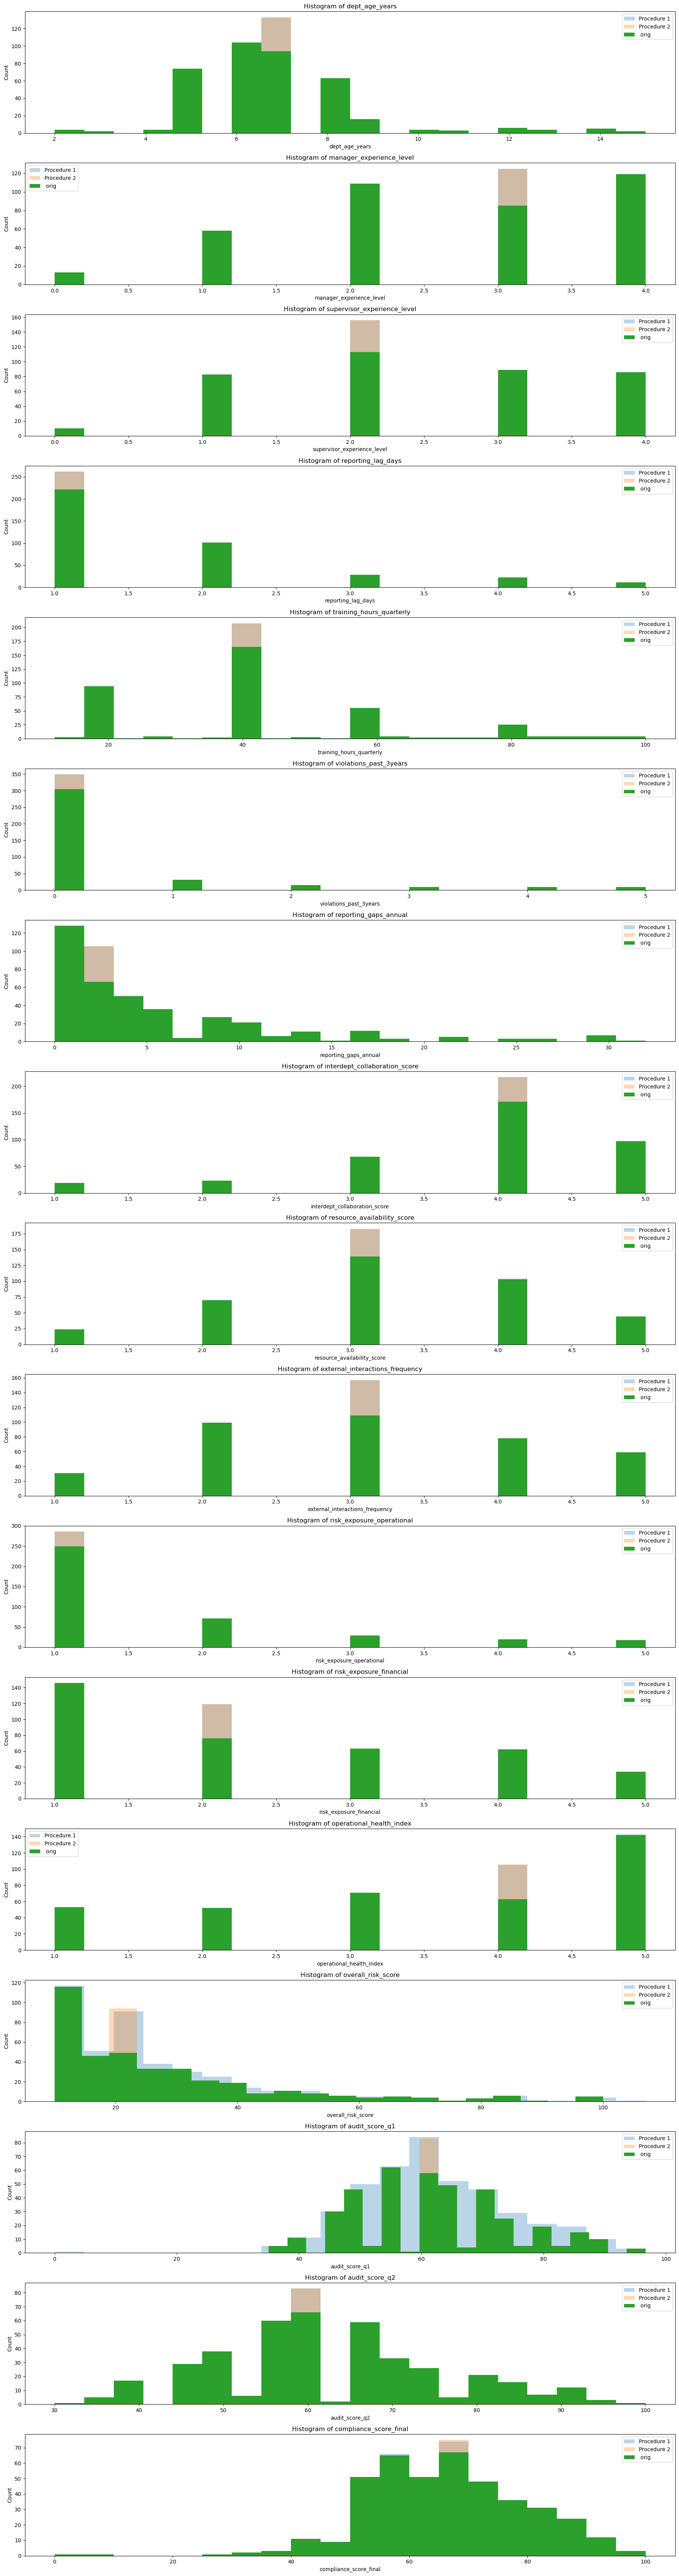

In [2095]:
#compate distributions

# Columns to compare
numerical_cols_for_hist = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2',
    'compliance_score_final'
]

# Set up the figure
plt.figure(figsize=(18, len(numerical_cols_for_hist)*4))

for i, col in enumerate(numerical_cols_for_hist, 1):
    plt.subplot(len(numerical_cols_for_hist), 1, i)
    plt.hist(departments_copy_for_missing_imputation_1[col], bins=20, alpha=0.3, label='Procedure 1')
    plt.hist(departments_copy_for_missing_imputation_2[col], bins=20, alpha=0.3, label='Procedure 2')
    plt.hist(departments[col], bins=20, alpha=1, label=' orig')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

---
Although the division-level statistics between the two procedures are similar, the distributions of individual numerical variables show that Procedure 2 preserves the original data patterns more accurately. Therefore, Procedure 2 should be adopted for final imputation.

---

#### **Adopting Procedure 2**

In [2098]:
departments = departments_copy_for_missing_imputation_2.copy()
high_risk_departments = high_risk_copy_for_missing_imputation_2.copy()
risk_summary_by_division_new = proc2_stats

In [2099]:
departments.shape

(424, 37)

In [2100]:
departments.head(5)

dept_id        dept_category             division   dept_type  \
0  DEPT-1003  Financial_Reporting         Corporate_HQ     Support   
4  DEPT-1066  Financial_Reporting         Corporate_HQ     Support   
5  DEPT-1070  Financial_Reporting         Corporate_HQ  Operations   
6  DEPT-1089  Financial_Reporting         Corporate_HQ     Support   
8  DEPT-1096  Financial_Reporting  Regional_Operations     Finance   

   dept_age_years  location_type team_size reporting_structure  \
0             8.0          Urban     Large         Centralized   
4             5.0          Urban     Large         Centralized   
5             6.0          Urban     Small         Centralized   
6             7.0          Urban     Small          Autonomous   
8             7.0  International     Large         Centralized   

   manager_experience_level  supervisor_experience_level  ...  \
0                       1.0                          2.0  ...   
4                       3.0                          4.0  ...   
5                       3.0                          2.0  ...   
6                       4.0                          4.0  ...   
8                       1.0                          0.0  ...   

  risk_exposure_financial operational_health_index  reporting_gaps_annual  \
0                     1.0                      4.0                    0.0   
4                     1.0                      5.0                    2.0   
5                     5.0                      3.0                   16.0   
6                     1.0                      4.0                    0.0   
8                     4.0                      2.0                    2.0   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  \
0            60.0            65.0                    65.0                21.0   
4            65.0            65.0                    65.0                11.0   
5            50.0            55.0                    60.0                48.0   
6            70.0            75.0                    75.0                10.0   
8            51.1            51.0                    51.0                88.0   

   present_in_high_risk_departments  extreme_non_compliance  \
0                                 0                       0   
4                                 0                       0   
5                                 1                       0   
6                                 0                       0   
8                                 1                       0   

   audit_scores_missing  
0                     0  
4                     0  
5                     0  
6                     0  
8                     0  

[5 rows x 37 columns]

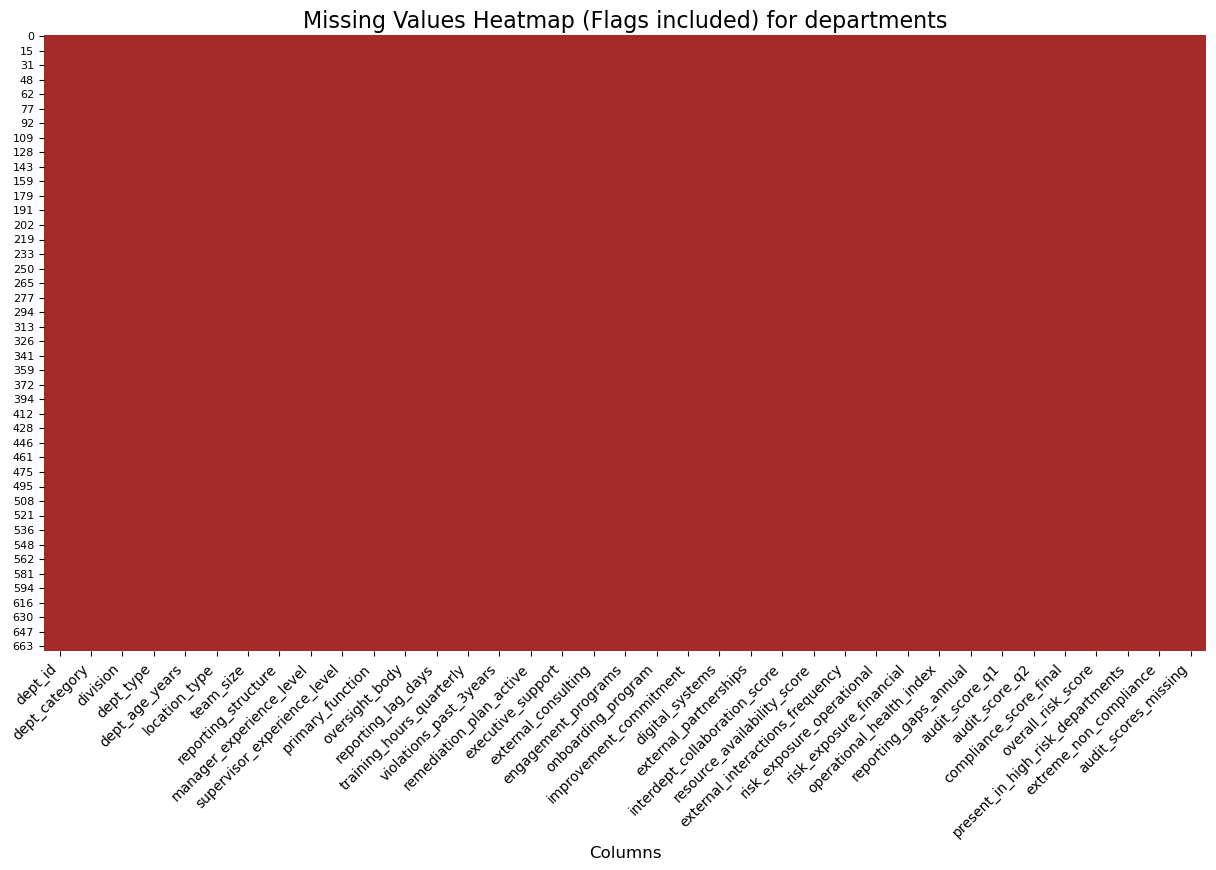

In [2101]:
plt.figure(figsize=(15,8))

sns.heatmap(
    departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap (Flags included) for departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

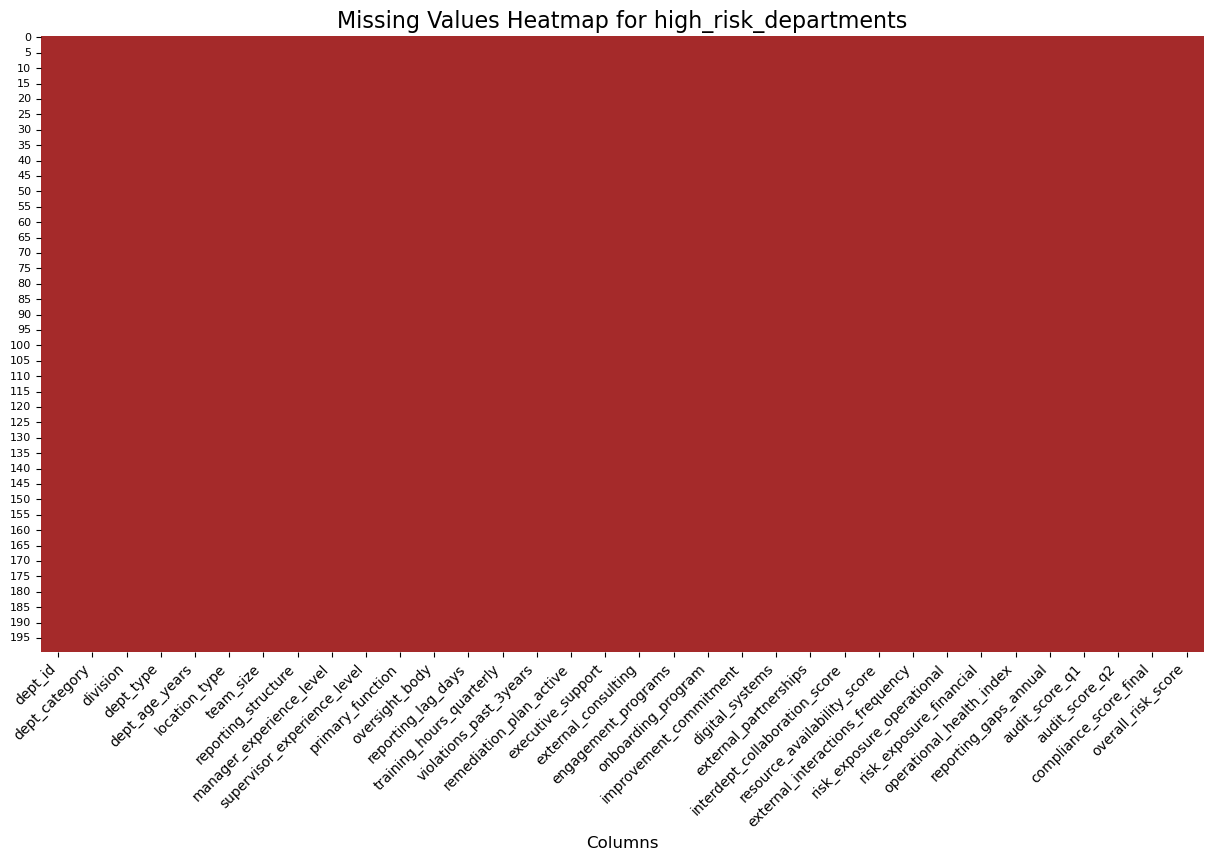

In [2102]:
plt.figure(figsize=(15,8))

sns.heatmap(
    high_risk_departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap for high_risk_departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

In [2103]:
df_analysis = departments.copy()
target_col = 'present_in_high_risk_departments'

print("--- 1. PREPARING DATA FOR ANALYSIS ---")
# Ensure the flag is an integer (0 or 1) just in case it's a float
df_analysis[target_col] = df_analysis[target_col].astype(int)

print(f"Total Departments: {len(df_analysis)}")
print(f"High Risk Count:   {df_analysis[target_col].sum()}")
print(f"Normal Count:      {len(df_analysis) - df_analysis[target_col].sum()}")

#we analyse the mean gap, menaing what makes teh higher risk and what make sthe normal deprtments
print("\n--- 2. DRIVER IDENTIFICATION (Mean Gap) ---")
# Calculate the average of every column for Normal (0) vs Risk (1)
numeric_cols = df_analysis.select_dtypes(include=['number']).columns

# Group by the EXISTING flag 'present_in_high_risk_departments'
comparison = df_analysis.groupby(target_col)[numeric_cols].mean().T
comparison.columns = ['Normal_Avg', 'Risk_Avg']

# Calculate the % Difference to find the biggest drivers
comparison['Diff_%'] = ((comparison['Risk_Avg'] - comparison['Normal_Avg']) / comparison['Normal_Avg']) * 100
comparison = comparison.sort_values(by='Diff_%', key=abs, ascending=False)

# Show the top 10 variables that are DIFFERENT in high-risk departments
# Note: The first row will likely be the target variable itself (Inf difference), ignore that one.
print(comparison.head(10))

# we decide the exact risk threshold using the decision tree rule
print("\n--- decision tree rules (Finding the 'Scores') ---")
from sklearn.tree import DecisionTreeClassifier, export_text

# Select features to test 
# CRITICAL: We MUST exclude 'dept_id' and the target 'present_in_high_risk_departments'
# If we don't exclude the target, the model will just say "If Risk=1, then Risk=1" (Cheating)
exclude = ['dept_id', target_col] 
feature_cols = [c for c in numeric_cols if c not in exclude]

X_tree = df_analysis[feature_cols].fillna(0) # Quick fill for analysis only
y_tree = df_analysis[target_col]             # Use existing flag as Target

# Train a shallow tree to get readable rules
dt = DecisionTreeClassifier(max_depth=2, random_state=42)
dt.fit(X_tree, y_tree)

# Print the rules
print(export_text(dt, feature_names=list(feature_cols)))

--- 1. PREPARING DATA FOR ANALYSIS ---
Total Departments: 424
High Risk Count:   198
Normal Count:      226

--- 2. DRIVER IDENTIFICATION (Mean Gap) ---
                                  Normal_Avg   Risk_Avg       Diff_%
audit_scores_missing                0.000000   0.040404          inf
present_in_high_risk_departments    0.000000   1.000000          inf
extreme_non_compliance              0.000000   0.010101          inf
violations_past_3years              0.022124   0.868687  3826.464646
remediation_plan_active             0.097345   0.237374   143.847567
overall_risk_score                 18.519912  35.310606    90.662931
reporting_gaps_annual               3.469027   6.545455    88.682746
external_consulting                 0.084071   0.146465    74.215843
risk_exposure_operational           1.247788   2.035354    63.116985
external_partnerships               0.252212   0.358586    42.176147

--- decision tree rules (Finding the 'Scores') ---
|--- compliance_score_final <= 59.90

---
#### consluions
> Hence we can see that based on the deifned threhold by the decision tree we can see that the main variables which are indicating non-compliance are 'violations_past_3years', 'remediation_plan_active', 'overall_risk_score', 'reporting_gaps_annual', 'external_consulting', 'risk_exposure_operational'
---

---
> we will now create a new yable with only departments which have comliance score over 59.9 in order to compare further complince_score_final
>
---

In [2105]:
# Create a new table for Compliant Departments (Score > 59.9)
non_compliant_departments = departments[departments['compliance_score_final'] < 59.9].copy()

# Check the results
print(f"Original Count:  {len(departments)}")
print(f"Compliant Count: {len(compliant_departments)}")
print(f"Dropped (Risky): {len(departments) - len(compliant_departments)}")

# Preview the safe departments
print(non_compliant_departments[['dept_id', 'compliance_score_final']].head())

Original Count:  424
Compliant Count: 280
Dropped (Risky): 144
      dept_id  compliance_score_final
8   DEPT-1096                    51.0
15  DEPT-1183                    50.0
19  DEPT-1235                    50.0
33  DEPT-1439                    55.0
36  DEPT-1472                    55.0


In [2106]:
# ==============================================================================
# DRIVER ANALYSIS: BELOW THRESHOLD (< 59.9) vs. ABOVE THRESHOLD
# ==============================================================================

# 1. SETUP: Use the full dataset
df_analysis = departments.copy()

# --- KEY CHANGE: Define Risk based on YOUR Threshold ---
# 1 = "Non-Compliant" (Score <= 59.9)
# 0 = "Compliant" (Score > 59.9)
threshold = 59.9
df_analysis['is_below_threshold'] = (df_analysis['compliance_score_final'] <= threshold).astype(int)

target_col = 'is_below_threshold'

print(f"--- Analysis based on Compliance Threshold: {threshold} ---")
print(f"Total Departments:     {len(df_analysis)}")
print(f"Below Threshold (Risky): {df_analysis[target_col].sum()}")
print(f"Above Threshold (Safe):  {len(df_analysis) - df_analysis[target_col].sum()}")

# ==============================================================================
# 2. MEAN GAP ANALYSIS (What drives the score down?)
# ==============================================================================
print("\n--- 2. MEAN GAP: Comparing Non-Compliant vs. Compliant ---")

# 1. Get all numeric columns
all_numeric_cols = df_analysis.select_dtypes(include=['number']).columns.tolist()

# 2. Define what to ignore (IDs, the Target itself, and the Score itself!)
# We exclude 'compliance_score_final' because we used it to define the groups.
# If we keep it, it will just show a huge difference, which is obvious.
ignore_cols = ['dept_id', target_col, 'compliance_score_final']
focus_cols = [c for c in all_numeric_cols if c not in ignore_cols]

# 3. Group and Compare
comparison = df_analysis.groupby(target_col)[focus_cols].mean().T
comparison.columns = ['Avg_Safe', 'Avg_Risky'] # 0 is Safe, 1 is Risky

# 4. Calculate % Difference
comparison['Diff_%'] = ((comparison['Avg_Risky'] - comparison['Avg_Safe']) / comparison['Avg_Safe']) * 100
comparison['Absolute_Diff'] = comparison['Avg_Risky'] - comparison['Avg_Safe']

# Sort by impact
comparison = comparison.sort_values(by='Diff_%', key=abs, ascending=False)

# Display Top 15 Drivers
print(comparison.head(15))

--- Analysis based on Compliance Threshold: 59.9 ---
Total Departments:     424
Below Threshold (Risky): 144
Above Threshold (Safe):  280

--- 2. MEAN GAP: Comparing Non-Compliant vs. Compliant ---
                                   Avg_Safe  Avg_Risky      Diff_%  \
extreme_non_compliance             0.000000   0.013889         inf   
present_in_high_risk_departments   0.192857   1.000000  418.518519   
audit_scores_missing               0.028571   0.000000 -100.000000   
remediation_plan_active            0.139286   0.208333   49.572650   
violations_past_3years             0.375000   0.500000   33.333333   
audit_score_q2                    68.833571  49.646528  -27.874543   
audit_score_q1                    67.514286  51.312500  -23.997567   
engagement_programs                0.617857   0.493056  -20.199101   
training_hours_quarterly          45.228571  38.173611  -15.598459   
overall_risk_score                25.083929  28.843750   14.988966   
supervisor_experience_level     

## **Standardize numerical variables**

In [352]:
df = departments.copy()

In [353]:
# Define feature groups
continuous_counts = [
    'dept_age_years', 'reporting_lag_days', 'training_hours_quarterly',
    'violations_past_3years', 'reporting_gaps_annual'
]

float_scores = [ 'audit_score_q1', 'audit_score_q2']

ordinal_scores = [
    'manager_experience_level', 'supervisor_experience_level',
    'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational',
    'risk_exposure_financial', 'operational_health_index'
]

binary_features = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]


In [354]:
# Handle skewness for counts
skew_threshold = 0.75
skewed_counts = departments[continuous_counts].apply(lambda x: skew(x.dropna()))
skewed_counts = skewed_counts[abs(skewed_counts) > skew_threshold].index.tolist()

print("Skewed count features:", skewed_counts)

for col in skewed_counts:
    # log1p works for zeros
    departments[col] = np.log1p(departments[col])

Skewed count features: ['dept_age_years', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'reporting_gaps_annual']


In [355]:
# Standardize continuous and ordinal features
to_standardize = continuous_counts + float_scores + ordinal_scores
scaler = StandardScaler()
departments[to_standardize] = scaler.fit_transform(departments[to_standardize])

print("\nStandardization complete. Preview:")
departments.head(3)


Standardization complete. Preview:


dept_id        dept_category      division   dept_type  dept_age_years  \
0  DEPT-1003  Financial_Reporting  Corporate_HQ     Support        0.733198   
4  DEPT-1066  Financial_Reporting  Corporate_HQ     Support       -1.089808   
5  DEPT-1070  Financial_Reporting  Corporate_HQ  Operations       -0.396733   

  location_type team_size reporting_structure  manager_experience_level  \
0         Urban     Large         Centralized                 -1.486610   
4         Urban     Large         Centralized                  0.306627   
5         Urban     Small         Centralized                  0.306627   

   supervisor_experience_level  ... risk_exposure_financial  \
0                    -0.344146  ...               -1.029951   
4                     1.502915  ...               -1.029951   
5                    -0.344146  ...                2.050820   

  operational_health_index  reporting_gaps_annual  audit_score_q1  \
0                 0.327411              -1.266665       -0.163561   
4                 1.050442              -0.177868        0.242945   
5                -0.395621               1.541237       -0.976575   

   audit_score_q2  compliance_score_final  overall_risk_score  \
0        0.204688                    65.0                21.0   
4        0.204688                    65.0                11.0   
5       -0.558281                    60.0                48.0   

   present_in_high_risk_departments  extreme_non_compliance  \
0                                 0                       0   
4                                 0                       0   
5                                 1                       0   

   audit_scores_missing  
0                     0  
4                     0  
5                     0  

[3 rows x 37 columns]

## **Encoding**

We will begin with encoding of our categroical variables, in order to be able to work wiht them in trainin our ML model:

These following variables will be encoded using one-hot (dummy variable) encoding since we have no inherent order, and the varivbales do not have so many categories, so in this case OHE is the most effecive.

- dept_category
- division
- dept_type
- location_type
- team_size
- reporting_structure
- primary_function
- oversight_body

---

In [358]:
departments_copy_for_encoding = departments.copy()
departments_not_encoded = departments.copy()

In [359]:
#we list the variable swhich shall bve encoded as said before
categorical_cols_to_encode = [
    'dept_category', 'division', 'dept_type',
    'location_type', 'team_size', 'reporting_structure', 'primary_function',
     'oversight_body'
]

In [360]:
# store safely the 'dept_id' column separately since we are creatign a new data farnme wiht the categorical varibales
department_ids = departments['dept_id']

# then we drop the 'dept_id' from the working dataframe so it is not encoded, since the pd.get_dummies will be encoding all catheorical variables included in the original dataframe
departments_working = departments.drop(columns=['dept_id'])

In [361]:
# then here we perform one-H´hot encoding using the pd.get_dummies function as we know
departments_encoded = pd.get_dummies(
    departments_working,
    columns=categorical_cols_to_encode,
    #drop the first dummy variable to avoide the dummy variable trap
    drop_first=True,
    dtype=int
)

In [362]:
# finally insert the original dept_id column back into the encoded dataframe
departments_encoded.insert(0, 'dept_id', department_ids)
departments = departments_encoded

In [363]:
#to viualise the encoded varibales in the dataframe
departments.head(2)

dept_id  dept_age_years  manager_experience_level  \
0  DEPT-1003        0.733198                 -1.486610   
4  DEPT-1066       -1.089808                  0.306627   

   supervisor_experience_level  reporting_lag_days  training_hours_quarterly  \
0                    -0.344146            0.597346                  0.057076   
4                     1.502915           -0.697432                  0.973154   

   violations_past_3years  remediation_plan_active  executive_support  \
0               -0.429057                      1.0                0.0   
4               -0.429057                      0.0                1.0   

   external_consulting  ...  reporting_structure_Hybrid  \
0                  0.0  ...                           0   
4                  0.0  ...                           0   

   primary_function_Compliance  primary_function_Finance  \
0                            0                         0   
4                            1                         0   

   primary_function_Legal  primary_function_Operations  \
0                       0                            0   
4                       0                            0   

   primary_function_Other  primary_function_Technology  \
0                       1                            0   
4                       0                            0   

   oversight_body_Compliance_Officer  oversight_body_External_Auditor  \
0                                  0                                0   
4                                  0                                0   

   oversight_body_Internal_Audit  
0                              1  
4                              1  

[2 rows x 53 columns]

In [364]:
#Check for shape of dataframe
print(f"Final DataFrame Shape: {departments.shape}")

Final DataFrame Shape: (424, 53)


## **Feature selection and collinearity**

### **Correlation Analysis**

We check correlations with our two target variables:
- Primary: compliance_score_final
- Secondary: overall_risk_score

---
Both variables are numerical, therefore, we can check correlations **numetical vs numerical** and **numerical vs categorical**. Boolean variables we include in categorical.

---

**Target vs Categorical variables**

In [370]:
categorical_cols = ['dept_category', 'division', 'dept_type',
    'location_type', 'team_size', 'reporting_structure', 'primary_function',
     'oversight_body'
]
bool_cols = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships', 'present_in_high_risk_departments',
    'extreme_non_compliance','audit_scores_missing'
]
all_categorical_cols = categorical_cols + bool_cols

---
We use departments_not_encoded table.

---

In [372]:
# sns.boxplot(data=departments_not_encoded, x='dept_category', ...)

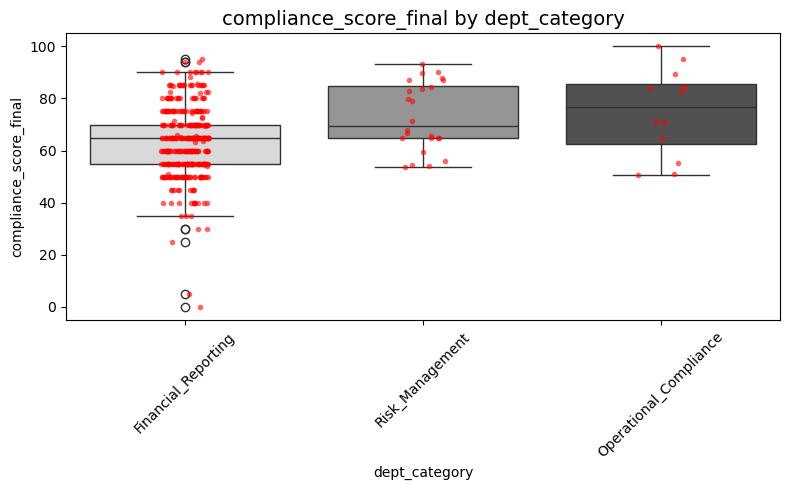

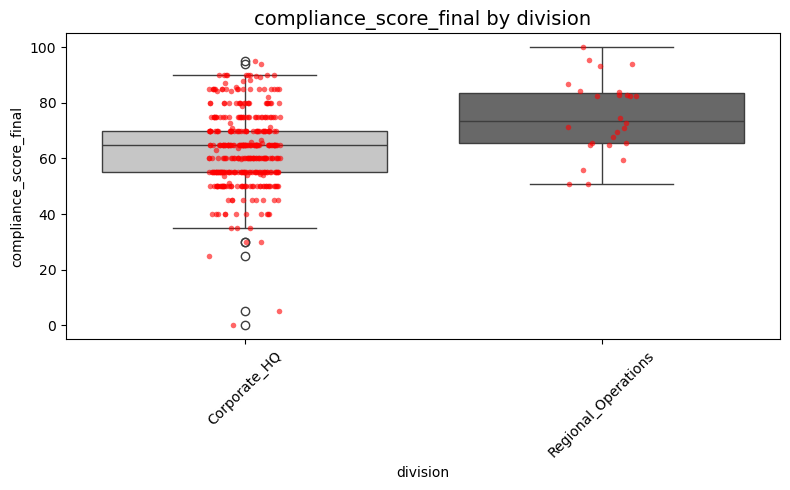

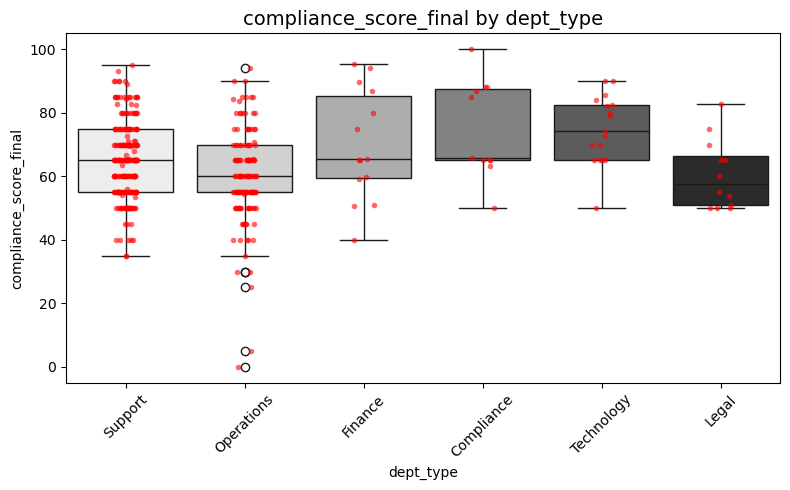

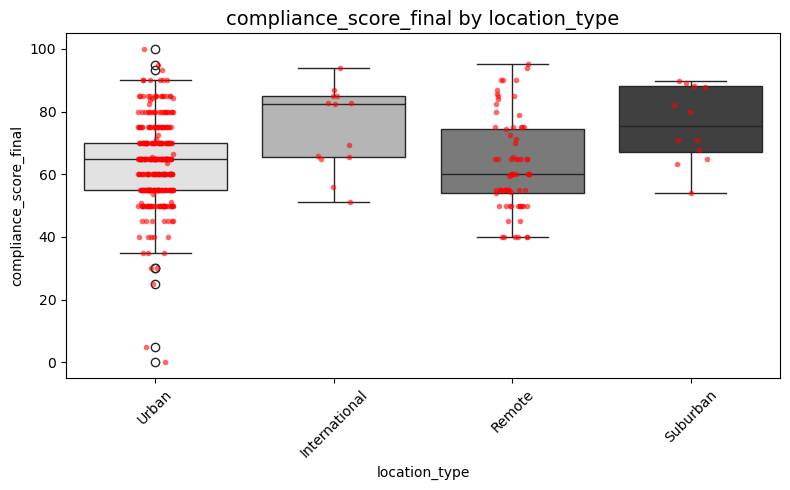

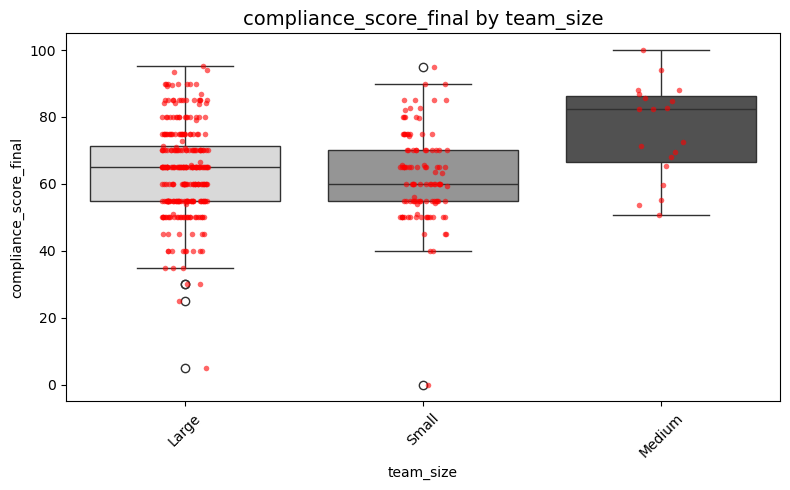

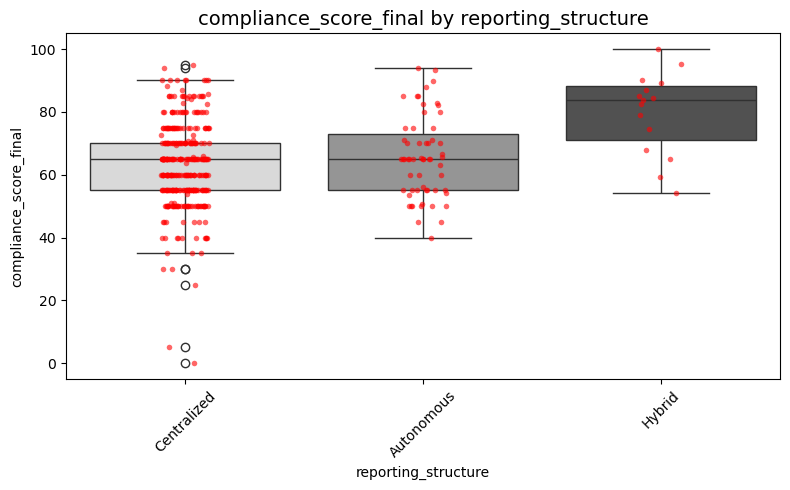

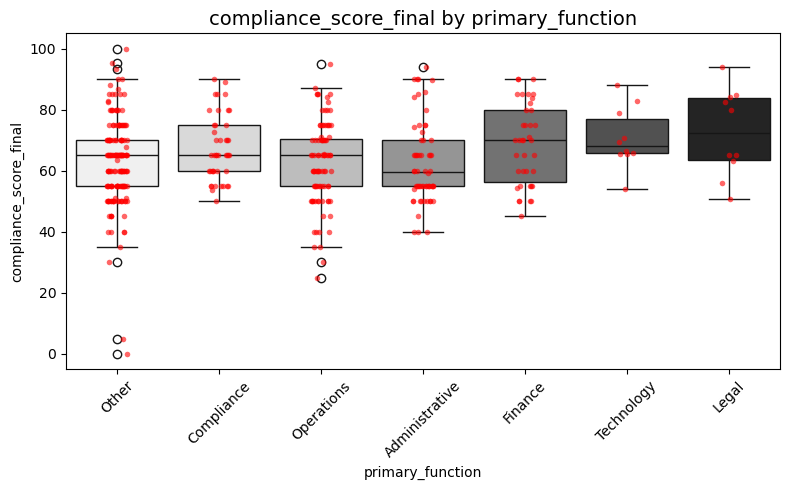

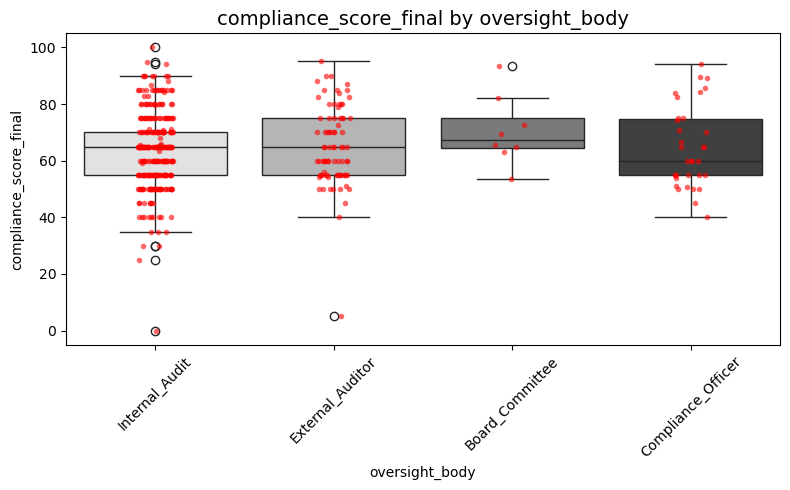

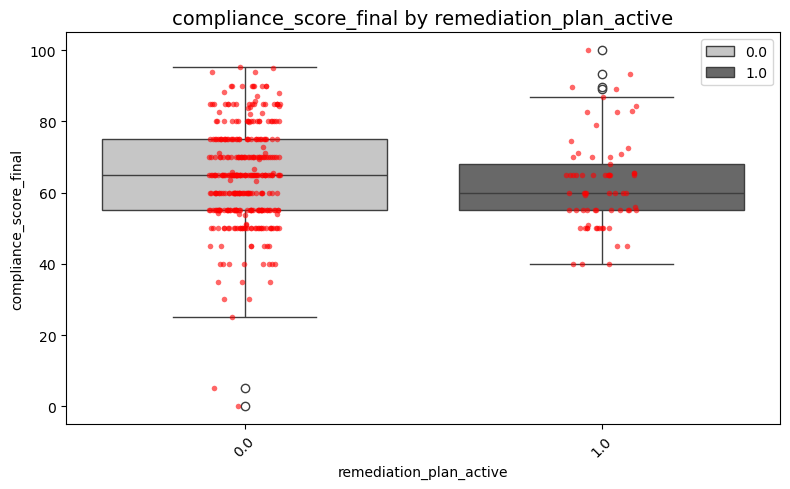

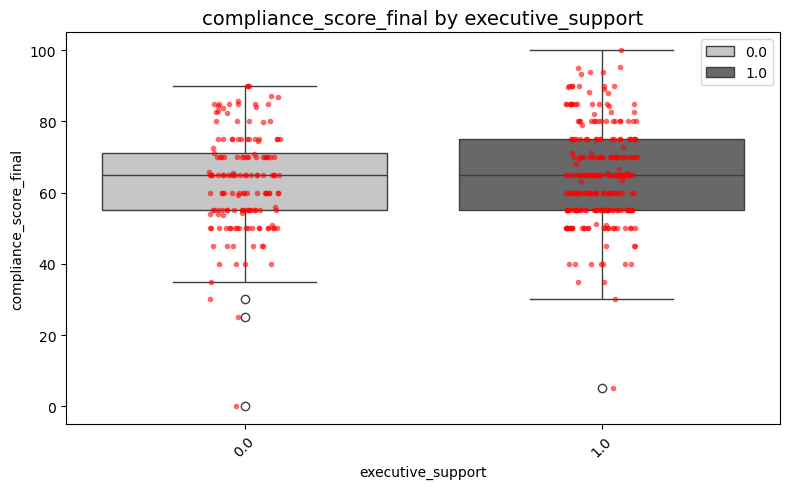

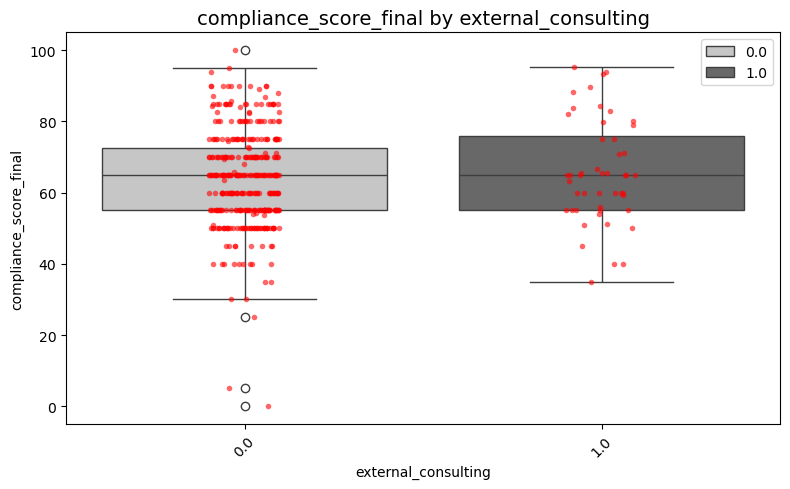

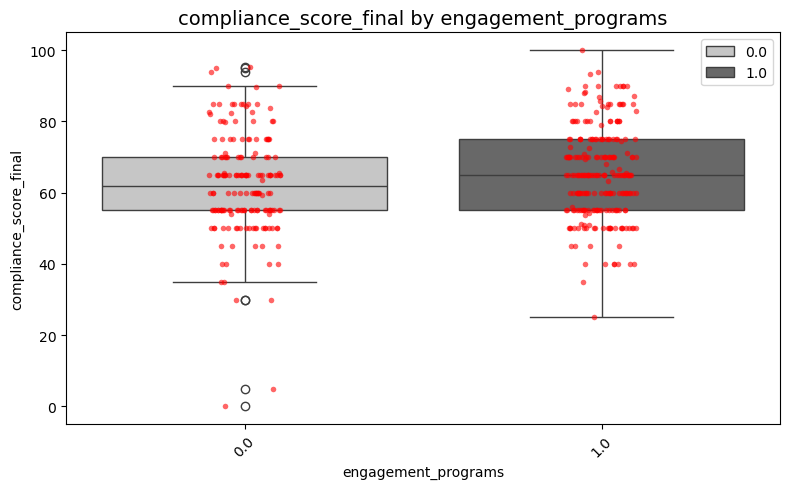

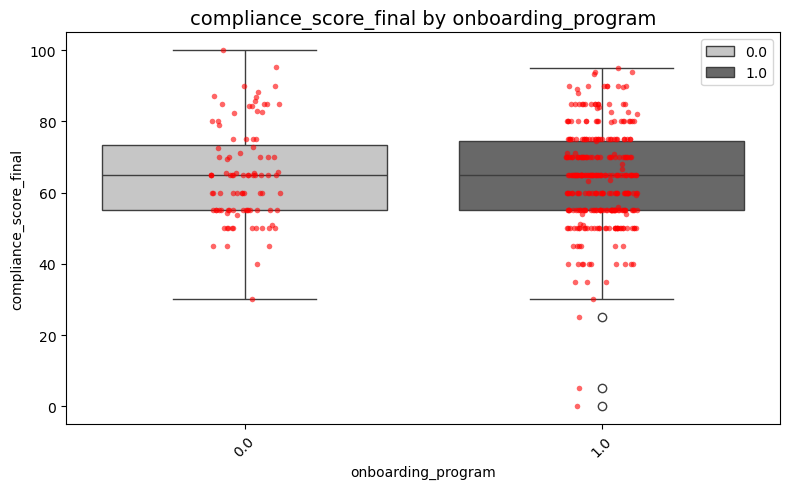

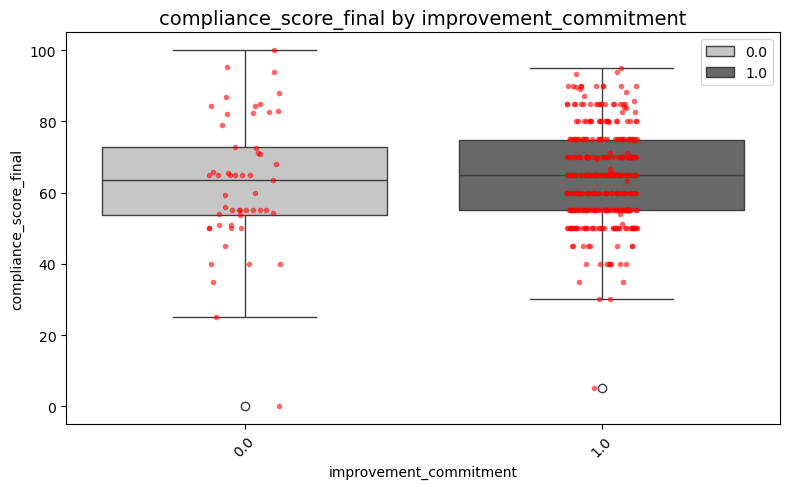

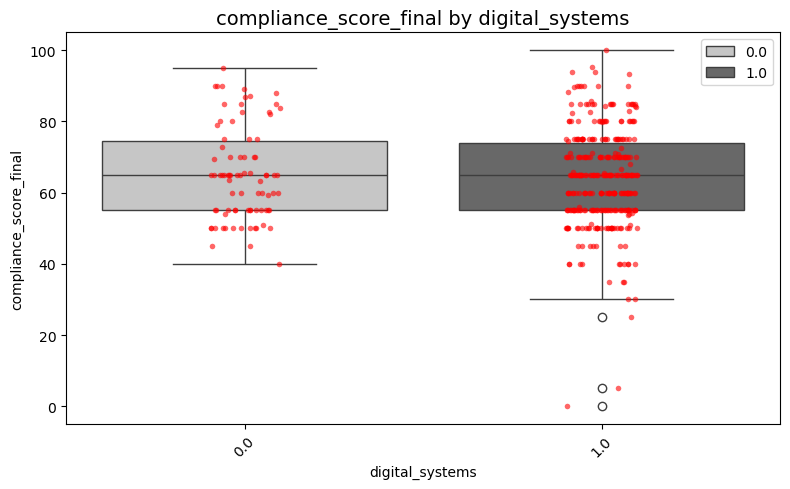

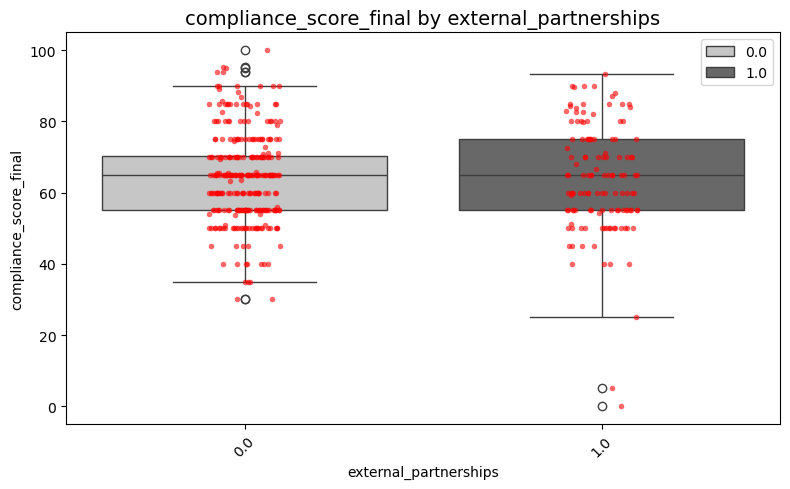

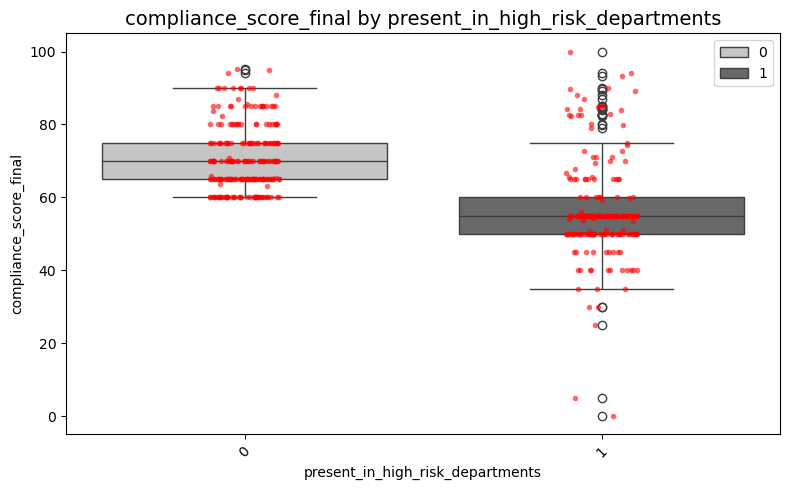

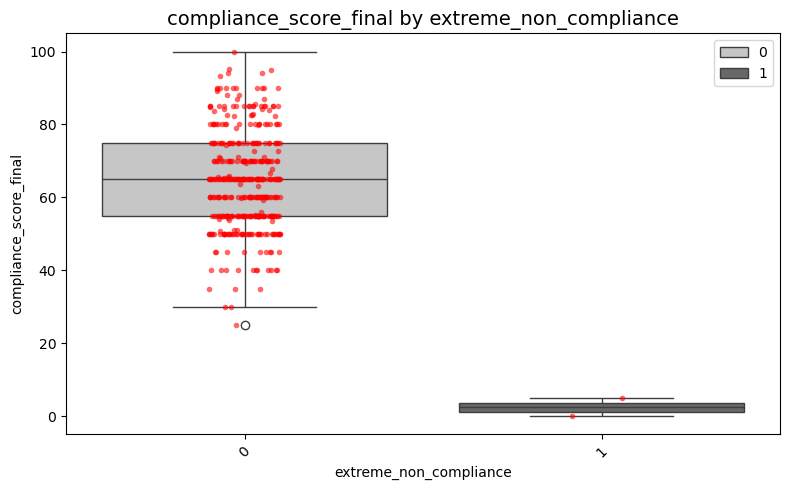

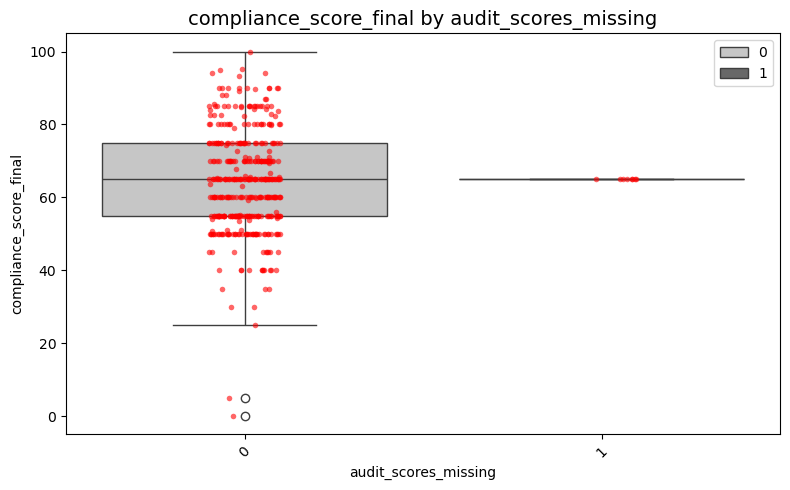

In [373]:
num_cols = ['compliance_score_final']

for cat_col in all_categorical_cols:
    for num_col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(
            data=departments_not_encoded,
            x=cat_col,
            y=num_col,
            hue=cat_col,
            palette="Greys"
        )
        sns.stripplot(  # shows all points like px.points='all'
            data=departments_not_encoded,
            x=cat_col,
            y=num_col,
            color='red',
            size=4,
            jitter=True,
            alpha=0.6
        )
        plt.title(f'{num_col} by {cat_col}', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

---
On average:
- For Technology department type (dept_type) the compliance is the highest, while for Legal department type it is the lowest.
- Medium team_size clearly has higher compliance as well as Hybrid reporting structure.
- International location in location_type shows higher compliance (important to mention, that the least amount of departments work abroad)
- Departments with Remediation plan have slightly higher compliance.
- Departments that were marked as high risky show lower compliance.
- Extreme non compliance, of course, shows very low compliance for these departments.
- Departments with Missing audit scores (any) ?????

---

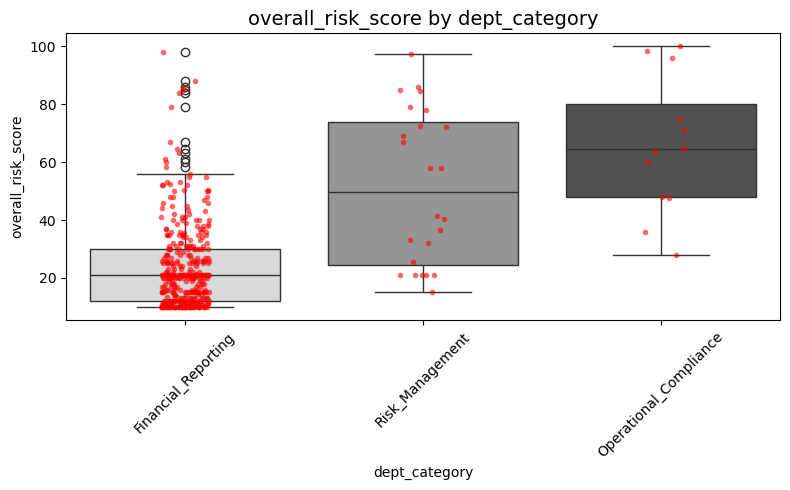

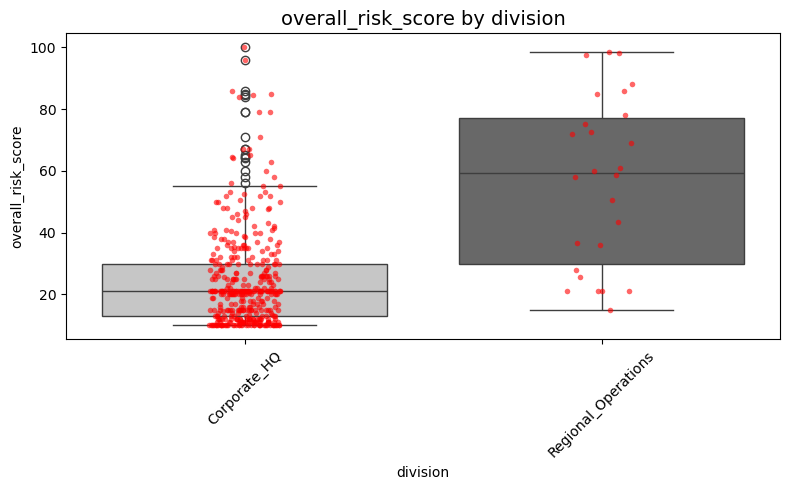

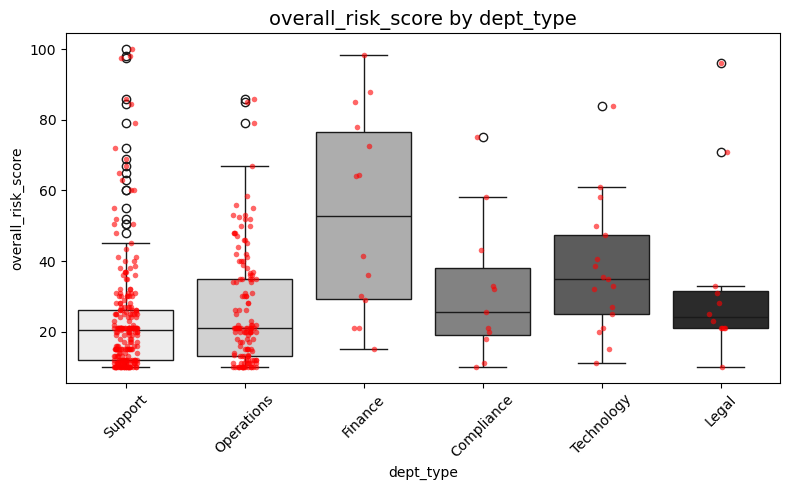

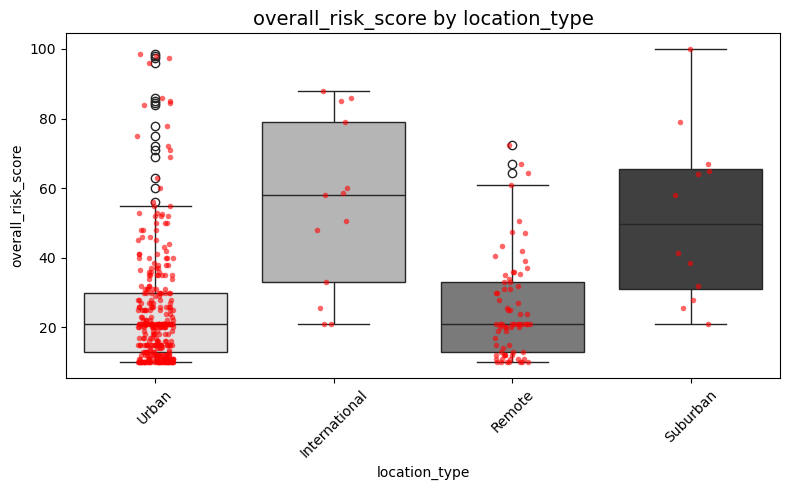

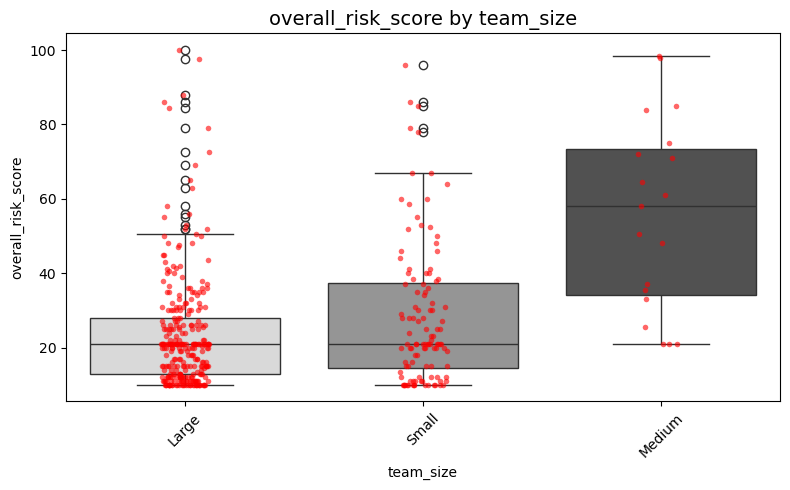

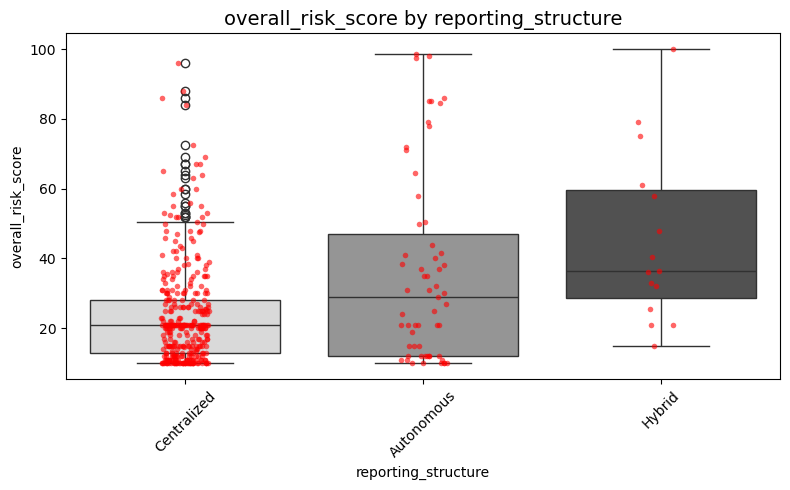

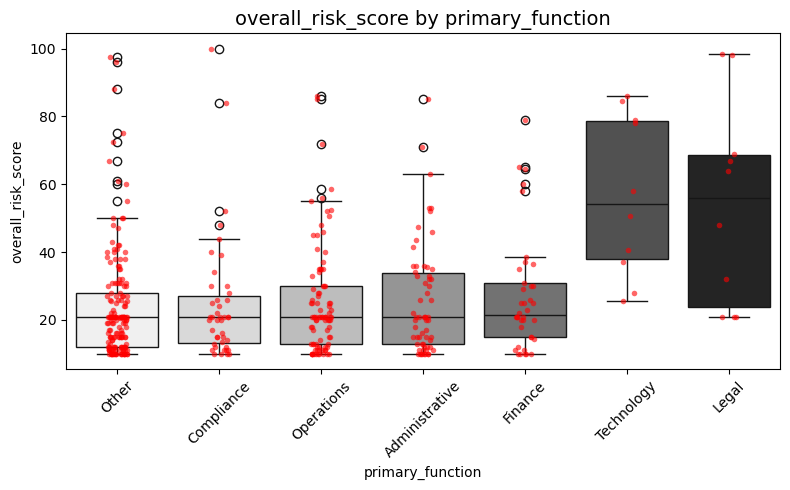

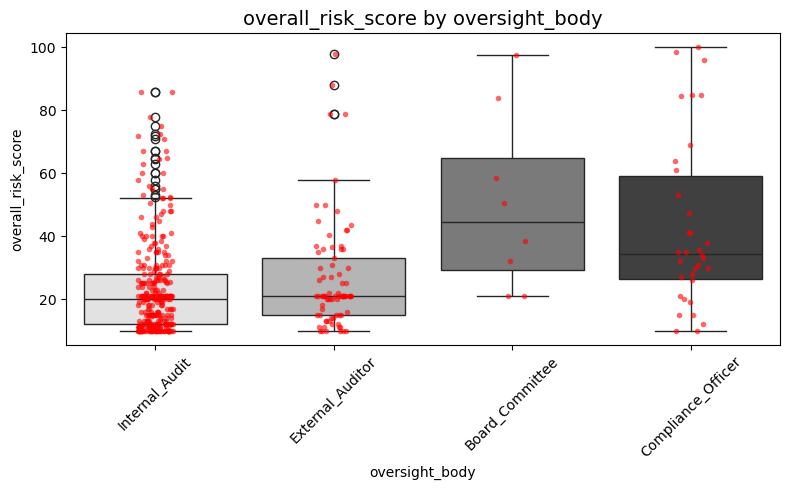

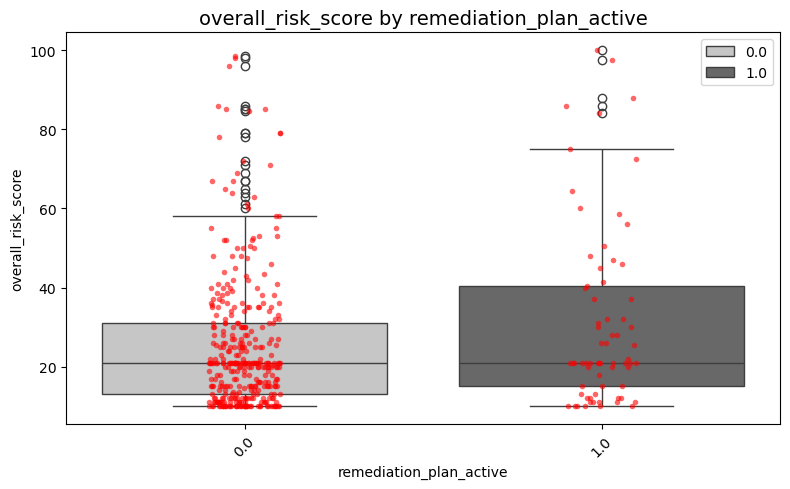

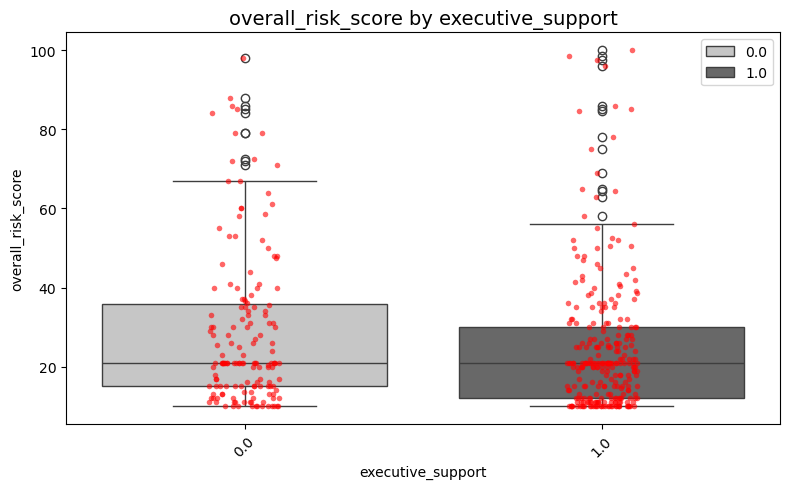

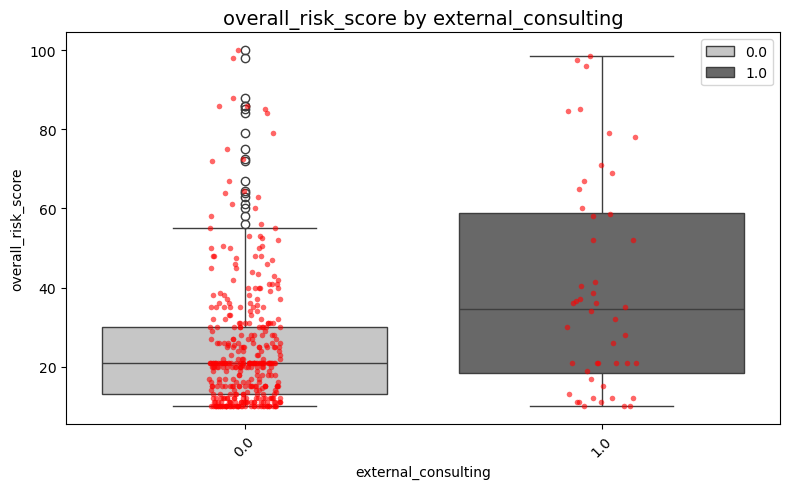

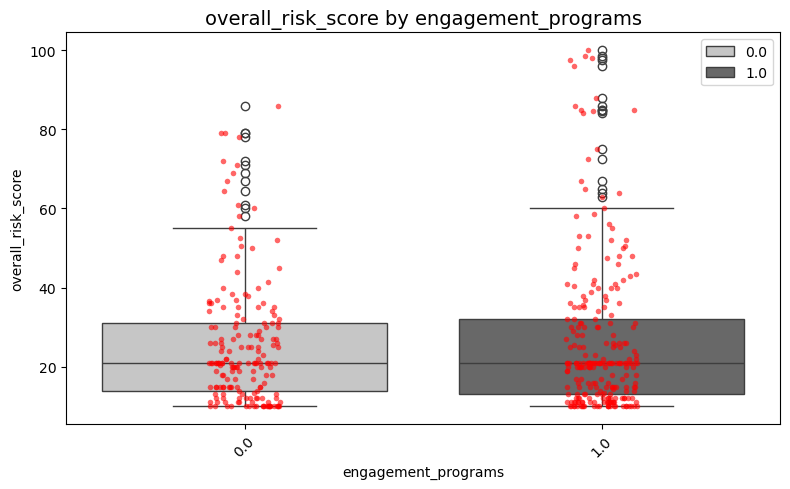

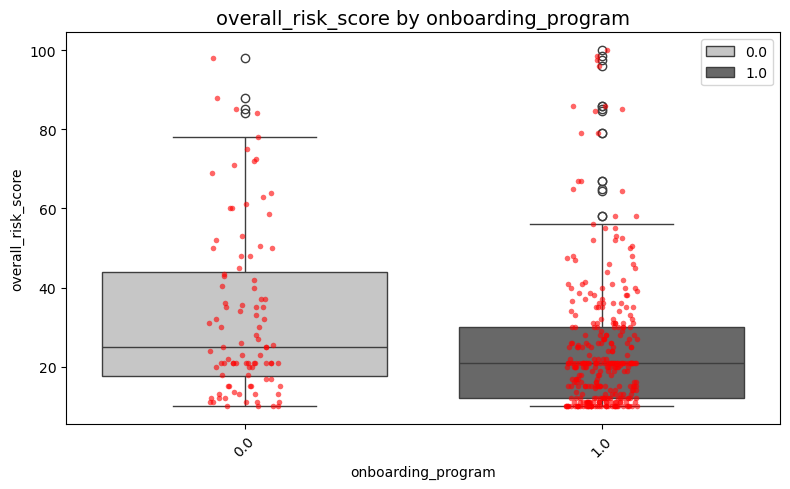

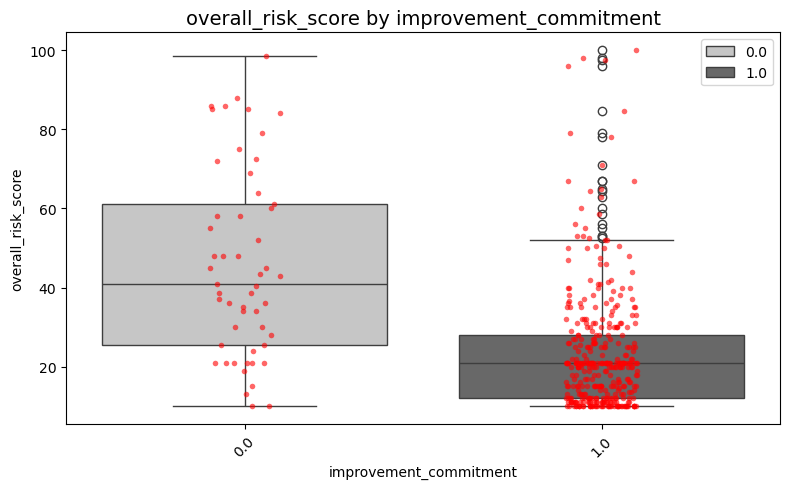

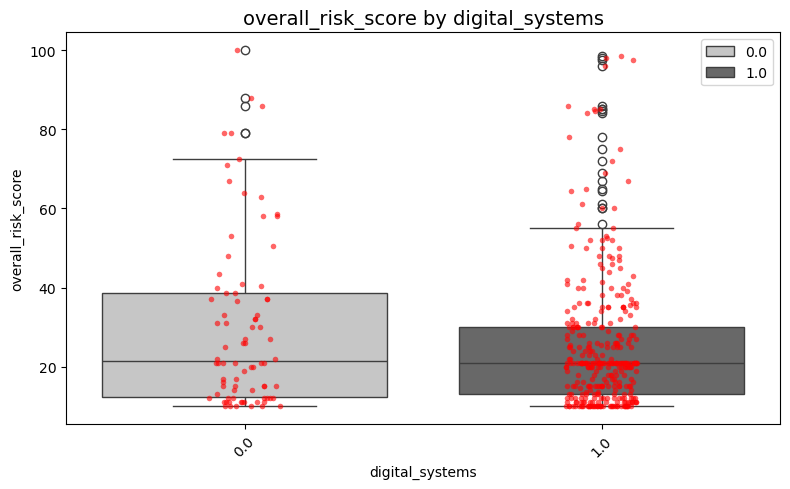

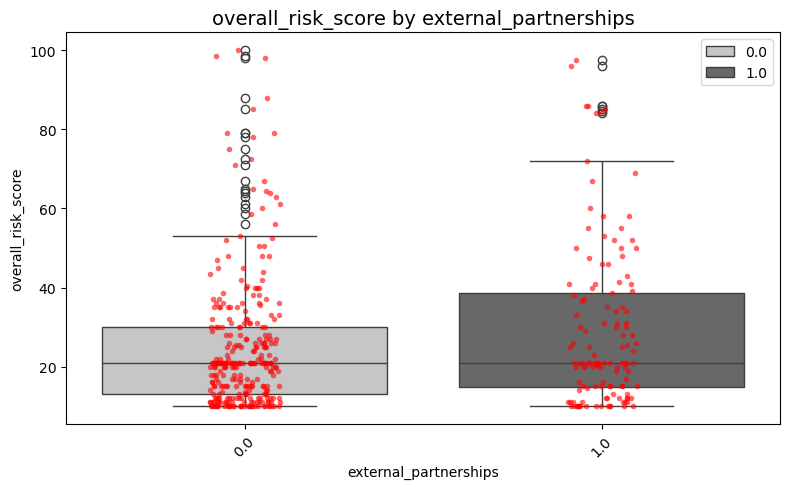

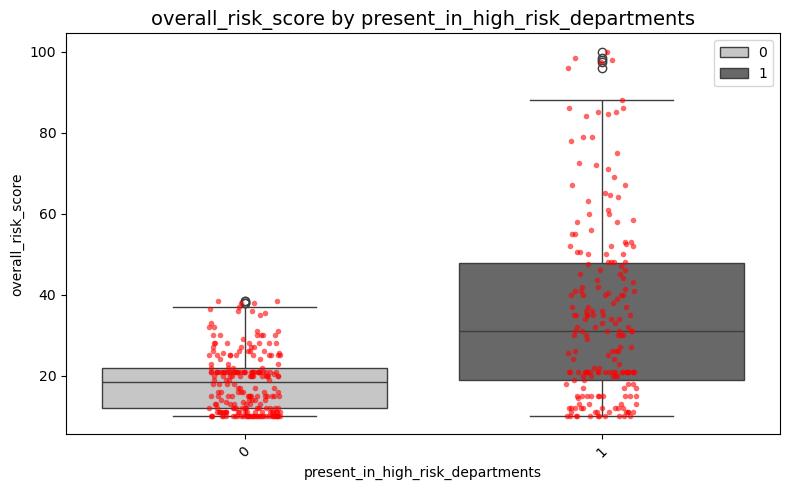

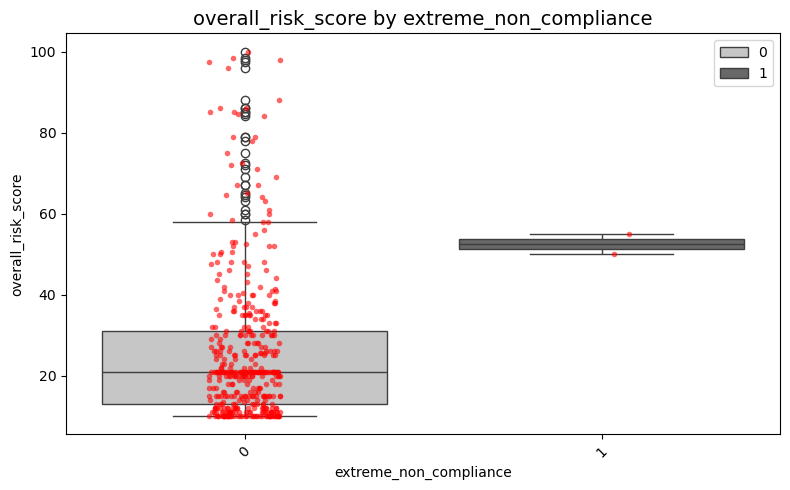

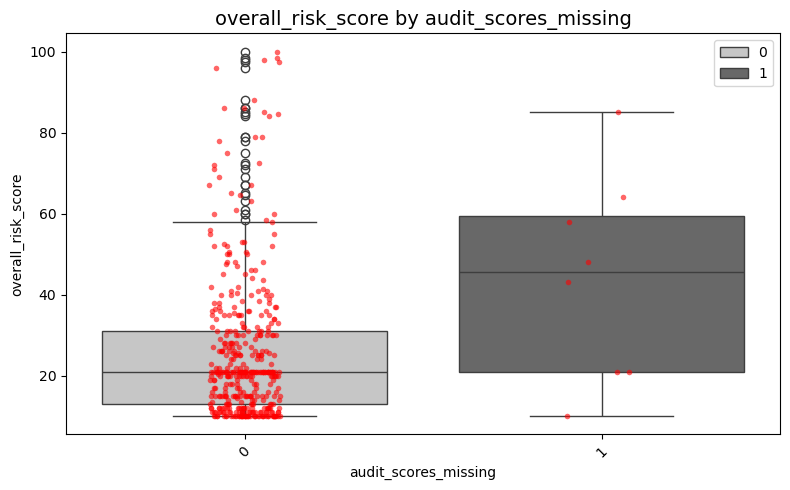

In [375]:
num_cols = ['overall_risk_score']

for cat_col in all_categorical_cols:
    for num_col in num_cols:
        plt.figure(figsize=(8, 5))

        sns.boxplot(
            data=departments_not_encoded,
            x=cat_col,
            y=num_col,
            hue=cat_col,
            palette="Greys"   # works fine now
        )

        sns.stripplot(
            data=departments_not_encoded,
            x=cat_col,
            y=num_col,
            color='red',
            size=4,
            jitter=True,
            alpha=0.6
        )

        plt.title(f'{num_col} by {cat_col}', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

---
On average:
- Departments dealing with Operational Compliance rules show the highest risk score, while for Financial Reporting, risk is the lowest.
- Regional Compliance division also demonstrates very high risk score, comparing to Corporate division.
- Financial departments tend to have higher risks, while Support are among the lowest together with Operations.
- International and suburban locations are much more risky than urban and remote.
- Medium team size shows the highest risks, while small and large are approximately on the same level and are not risky in general.
- Departments whose primary function is Legal or technology have much higher risks than any others.
- Departments checked by Board Committee show the highest risks.
- Absence of Improvement commitments increases risks
- Presence of external consulting also increases risks
- Obviously, departments previousely marked as highly risky show higher risks scores.
- Departments with Extreme non-compliance are also much more risky.
- Departments with missing audit scores (any) have higher risks.

---

**Target vs Numerical variables**

In [378]:
# Compute correlation matrix
corr_matrix = departments_not_encoded[numerical_cols].corr()

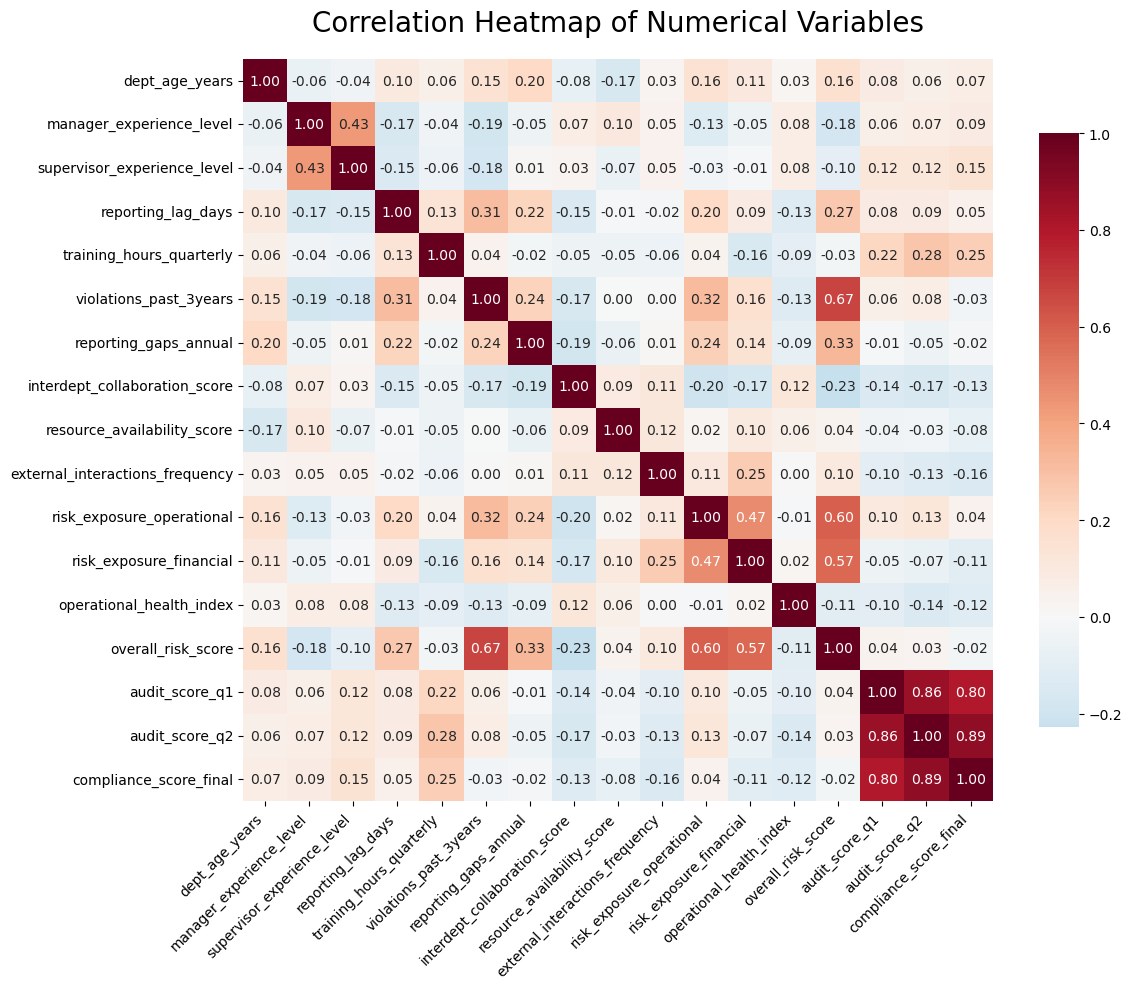

In [379]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,         # show correlation values
    fmt=".2f",
    cmap="RdBu_r",      # same as Plotly RdBu_r
    center=0,
    cbar_kws={"shrink": 0.8, "aspect": 15}  # similar thickness/length as Plotly
)

plt.title("Correlation Heatmap of Numerical Variables", fontsize=20, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
***FOR compliance_score_final***

The two audit variables completely dominate:
- audit_score_q2 → 0.89
- audit_score_q1 → 0.80

This is the only non-audit factor with meaningful relationship:

training_hours_quarterly → 0.25

Weak correlations:
- external_interactions_frequency → -0.16
- operational_health_index → -0.12
- interdept_collaboration_score → -0.13
- dept_age_years → 0.11


Other relationships are too weak.


---
***FOR overall_risk_score***

Strong predictors:
- risk_exposure_operational → 0.60
- violations_past_3years → 0.67
- risk_exposure_financial → 0.57
- reporting_gaps_annual → 0.38

These variables dominate the relationship with overall_risk_score and should definitely be kept.

Moderate predictors:
- dept_age_years → 0.24
- interdept_collaboration_score → -0,23
- reporting_lag_days → 0.28
- manager_experience_level → -0.18

Other relationships are too weak.

---

### **Multicolinearity check**

Now we will dig into searching for multicollinearuty between our varibales, since this might be problematic for our future model training.

This step is critical for creating an analytical framework for explanation and risk mitigation!

As an exapmle if two of our variables lets say: if team_size_Large and reporting_structure_Centralized are 95% correlated, our model will not be able to detect which of these two varibles are responsible for a change in the risk score.

In addition, statistically multicollinearity might create more unstabile and harder to train models.

We can detect multicollineraity using the VIF (variance inflation factor). The VIF measures how much the variance of a regression coefficient is increased due to collinearity with other predictors.

---

In [383]:
columns_we_drop = [
    'compliance_score_final',          # our target variable
    'overall_risk_score',              # total score                # Sum of Full + Part time   # Flag
    'presense_in_high_risk_departments',# Flag
    'extreme_non_compliance',
    'audit_scores_missing'

    # Flag
]

multi_col_check = departments.drop(columns=columns_we_drop, errors='ignore')
#take only numerical columns
multi_col_check = multi_col_check.select_dtypes(include=np.number)

print(f"Final VIF Check on {len(multi_col_check.columns)} columns.")

# tehn we run the VIF score calculation
vif_list = []
for i in range(multi_col_check.shape[1]):
    y = multi_col_check.iloc[:, i]
    X_i = multi_col_check.drop(columns=multi_col_check.columns[i])

    model = LinearRegression()
    model.fit(X_i, y)
    R2 = model.score(X_i, y)
    VIF = 1 / (1 - R2)
    vif_list.append(VIF)

# Show Results
vif_data = pd.DataFrame({"Feature": multi_col_check.columns, "VIF": vif_list})
print(vif_data.sort_values(by="VIF", ascending=False).round(2))

Final VIF Check on 48 columns.
                                 Feature    VIF
47         oversight_body_Internal_Audit  17.07
46       oversight_body_External_Auditor  13.38
30                     dept_type_Support  13.19
29                  dept_type_Operations  11.97
34                   location_type_Urban  10.57
32                  location_type_Remote   8.79
45     oversight_body_Compliance_Officer   6.60
22                        audit_score_q2   5.24
21                        audit_score_q1   4.30
31                  dept_type_Technology   3.11
27                     dept_type_Finance   2.90
33                location_type_Suburban   2.89
25         dept_category_Risk_Management   2.78
43                primary_function_Other   2.62
28                       dept_type_Legal   2.57
26          division_Regional_Operations   2.54
42           primary_function_Operations   2.51
38            reporting_structure_Hybrid   2.38
23      present_in_high_risk_departments   2.28
39       

In [384]:
threshold_certain = 10.0  # Common threshold for severe multicollinearity
threshold_possible = 5.0  # Common threshold for moderate multicollinearity

# --- 2. Define the Categorization Function ---
def categorize_vif(vif_score):
    """Assigns a categorical label based on the VIF score."""
    # Ensure VIF is treated as a number; use NaN check for safety
    if pd.isna(vif_score):
        return "Not Applicable (NaN)"

    if vif_score >= threshold_certain:
        return "Certain Multicollinearity (VIF >= 10)"
    elif vif_score >= threshold_possible:
        return "Possible Multicollinearity (VIF >= 5)"
    else:
        return "No Multicollinearity (VIF < 5)"

# --- 3. Apply Categorization ---
vif_data['multicollinearity_level'] = vif_data['VIF'].apply(categorize_vif)

print("\n--- Categorized Multicollinearity Levels Summary ---")

# --- 4. Show Variables with CERTAIN Multicollinearity ---
certain_vif_df = vif_data[vif_data['VIF'] >= threshold_certain]
print("\n--- Certain Multicollinearity (VIF >= 10) ---")
if not certain_vif_df.empty:
    print(certain_vif_df)
else:
    print("No features found with VIF >= 10. (Model is stable here.)")
print("-" * 30)

# --- 5. Show Variables with POSSIBLE Multicollinearity ---
possible_vif_df = vif_data[(vif_data['VIF'] >= threshold_possible) & (vif_data['VIF'] < threshold_certain)]
print("\n--- Possible Multicollinearity (VIF >= 5 and < 10) ---")
if not possible_vif_df.empty:
    print(possible_vif_df)
else:
    print("No features found with VIF >= 5.")
print("-" * 30)

# --- 6. Show Variables with NO Multicollinearity ---
no_vif_df = vif_data[vif_data['VIF'] < threshold_possible]
print(f"\n--- No Multicollinearity (VIF < 5) - {len(no_vif_df)} Features ---")
# Only print a sample since this list is usually long
print(no_vif_df.head(10))


--- Categorized Multicollinearity Levels Summary ---

--- Certain Multicollinearity (VIF >= 10) ---
                            Feature        VIF  \
29             dept_type_Operations  11.970847   
30                dept_type_Support  13.190663   
34              location_type_Urban  10.573844   
46  oversight_body_External_Auditor  13.383538   
47    oversight_body_Internal_Audit  17.074907   

                  multicollinearity_level  
29  Certain Multicollinearity (VIF >= 10)  
30  Certain Multicollinearity (VIF >= 10)  
34  Certain Multicollinearity (VIF >= 10)  
46  Certain Multicollinearity (VIF >= 10)  
47  Certain Multicollinearity (VIF >= 10)  
------------------------------

--- Possible Multicollinearity (VIF >= 5 and < 10) ---
                              Feature       VIF  \
22                     audit_score_q2  5.244076   
32               location_type_Remote  8.789859   
45  oversight_body_Compliance_Officer  6.595913   

                  multicollinearity_level 

Drop surely multicollinear variables

In [386]:
# --- 1. Identify features to drop ---
features_to_drop = certain_vif_df['Feature'].tolist()
print("Dropping features due to certain multicollinearity (VIF >= 10):")
print(features_to_drop)

# --- 2. Drop these features from your main dataframe ---
departments_clean = departments.drop(columns=features_to_drop)

print(f"\nShape before dropping: {departments.shape}")
print(f"Shape after dropping: {departments_clean.shape}")

Dropping features due to certain multicollinearity (VIF >= 10):
['dept_type_Operations', 'dept_type_Support', 'location_type_Urban', 'oversight_body_External_Auditor', 'oversight_body_Internal_Audit']

Shape before dropping: (424, 53)
Shape after dropping: (424, 48)


---

### **Mutual Information**

Mutual Information measures how much knowing variable A reduces uncertainty about variable B.

Works for:
- nonlinear relationships
- categorical variables
- boolean variables

Interpretation:
- MI = 0 → variables are completely independent
- MI > 0 → some relationship exists
- The larger the MI, the stronger the dependency (not necessarily linear)

---

In [390]:
from sklearn.metrics import mutual_info_score
import numpy as np
import pandas as pd

# Function to compute entropy
def entropy(x):
    probs = np.bincount(x) / len(x)
    probs = probs[probs > 0]  # avoid log(0)
    return -np.sum(probs * np.log2(probs))

# Compute normalized MI (by min entropy)
cols = departments.columns
dep_mi = departments.copy()
for c in dep_mi.columns:
    dep_mi[c] = pd.factorize(dep_mi[c])[0]

mi_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

for c1 in cols:
    for c2 in cols:
        mi = mutual_info_score(dep_mi[c1], dep_mi[c2])
        h1 = entropy(dep_mi[c1])
        h2 = entropy(dep_mi[c2])
        mi_matrix.loc[c1, c2] = mi / min(h1, h2)  # normalized MI

mi_matrix

dept_id  dept_age_years  \
dept_id                               0.693147        0.693147   
dept_age_years                        0.693147        0.693147   
manager_experience_level              0.693147        0.038294   
supervisor_experience_level           0.693147        0.032911   
reporting_lag_days                    0.693147        0.085729   
training_hours_quarterly              0.693147        0.171265   
violations_past_3years                0.693147        0.137176   
remediation_plan_active               0.693147        0.077324   
executive_support                     0.693147        0.012837   
external_consulting                   0.693147        0.058770   
engagement_programs                   0.693147        0.010755   
onboarding_program                    0.693147        0.043033   
improvement_commitment                0.693147        0.127191   
digital_systems                       0.693147        0.044141   
external_partnerships                 0.693147        0.024196   
interdept_collaboration_score         0.693147        0.038055   
resource_availability_score           0.693147        0.046669   
external_interactions_frequency       0.693147        0.055006   
risk_exposure_operational             0.693147        0.073343   
risk_exposure_financial               0.693147        0.038162   
operational_health_index              0.693147        0.031780   
reporting_gaps_annual                 0.693147        0.116760   
audit_score_q1                        0.693147        0.203248   
audit_score_q2                        0.693147        0.218414   
compliance_score_final                0.693147        0.215390   
overall_risk_score                    0.693147        0.236809   
present_in_high_risk_departments      0.693147        0.022342   
extreme_non_compliance                0.693147        0.105470   
audit_scores_missing                  0.693147        0.133746   
dept_category_Operational_Compliance  0.693147        0.361312   
dept_category_Risk_Management         0.693147        0.150702   
division_Regional_Operations          0.693147        0.253891   
dept_type_Finance                     0.693147        0.150868   
dept_type_Legal                       0.693147        0.086409   
dept_type_Operations                  0.693147        0.029693   
dept_type_Support                     0.693147        0.022381   
dept_type_Technology                  0.693147        0.104312   
location_type_Remote                  0.693147        0.029781   
location_type_Suburban                0.693147        0.221451   
location_type_Urban                   0.693147        0.083640   
team_size_Medium                      0.693147        0.364087   
team_size_Small                       0.693147        0.026346   
reporting_structure_Centralized       0.693147        0.081963   
reporting_structure_Hybrid            0.693147        0.236972   
primary_function_Compliance           0.693147        0.032184   
primary_function_Finance              0.693147        0.031963   
primary_function_Legal                0.693147        0.238798   
primary_function_Operations           0.693147        0.015689   
primary_function_Other                0.693147        0.017243   
primary_function_Technology           0.693147        0.207854   
oversight_body_Compliance_Officer     0.693147        0.117725   
oversight_body_External_Auditor       0.693147        0.026823   
oversight_body_Internal_Audit         0.693147        0.040576   

                                      manager_experience_level  \
dept_id                                               0.693147   
dept_age_years                                        0.038294   
manager_experience_level                              0.693147   
supervisor_experience_level                           0.083686   
reporting_lag_days                                    0.020940   
training_hours_quarterly                              0.102315   
violations_p

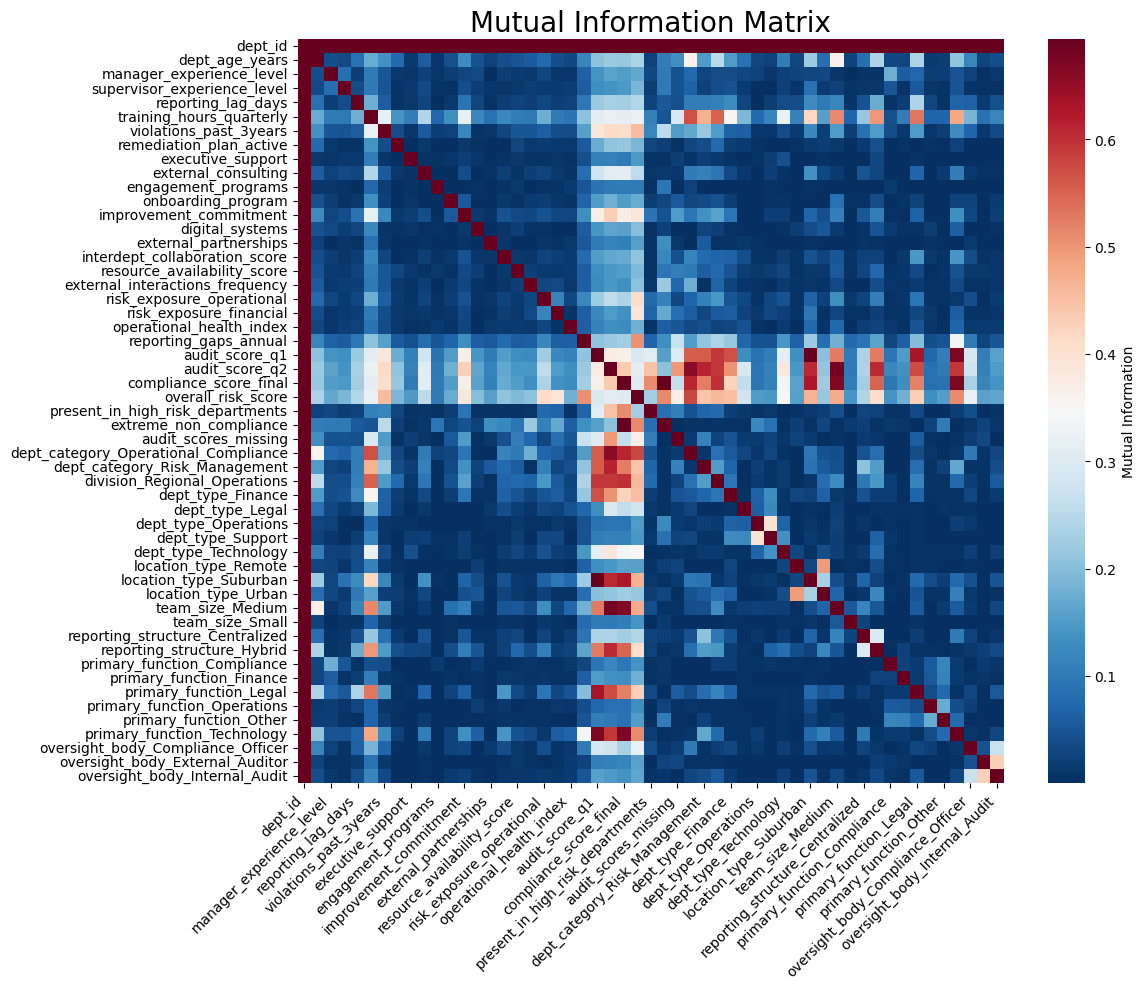

In [391]:
# 2. Heatmap with Seaborn

plt.figure(figsize=(12, 10))
sns.heatmap(mi_matrix, cmap="RdBu_r", annot=False, cbar_kws={'label': 'Mutual Information'})
plt.title("Mutual Information Matrix", fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---

In [393]:
# 1. Define target and features

y = departments['compliance_score_final']          # target variable
X = departments.drop(columns=['compliance_score_final', 'dept_id'])  # features (no ID)

In [394]:
# 3. Choose MI function (regression vs classification)

is_classification = y.dtype.name == 'category' or y.nunique() < 10

if is_classification:
    mi = mutual_info_classif(X, y, discrete_features='auto')
else:
    mi = mutual_info_regression(X, y, discrete_features='auto')

# Convert to Series
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

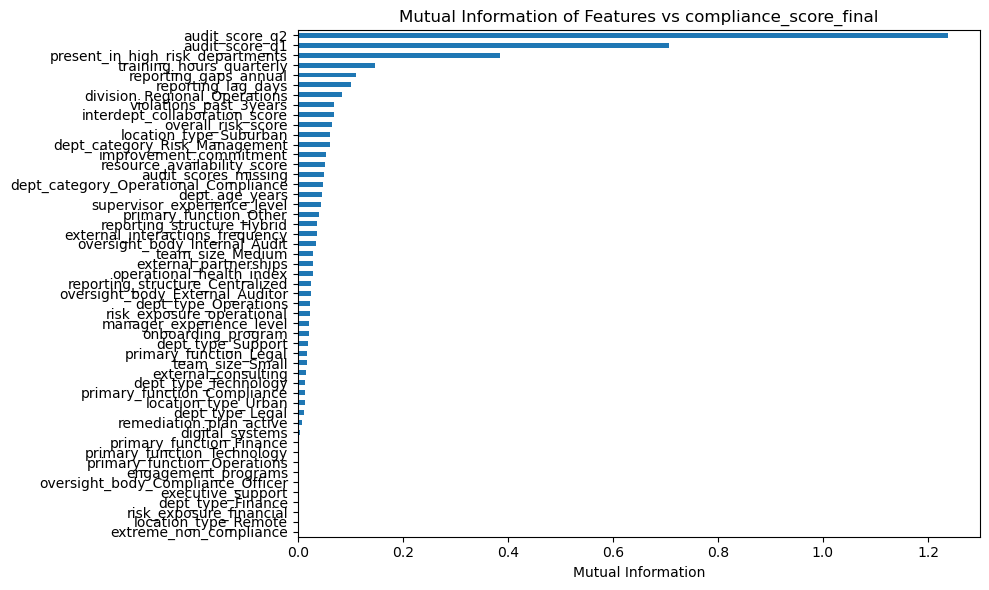

In [395]:
# ------------------------------
# 4. Plot MI
# ------------------------------
plt.figure(figsize=(10, 6))
mi_series.sort_values(ascending=True).plot(kind='barh')
plt.title("Mutual Information of Features vs compliance_score_final")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()


In [396]:
# ------------------------------
# 5. Select features above MI threshold
# ------------------------------
selected_features = mi_series[mi_series > 0.01].index.tolist()
X_reduced = X[selected_features]

print("\nSelected features:", selected_features)


Selected features: ['audit_score_q2', 'audit_score_q1', 'present_in_high_risk_departments', 'training_hours_quarterly', 'reporting_gaps_annual', 'reporting_lag_days', 'division_Regional_Operations', 'violations_past_3years', 'interdept_collaboration_score', 'overall_risk_score', 'location_type_Suburban', 'dept_category_Risk_Management', 'improvement_commitment', 'resource_availability_score', 'audit_scores_missing', 'dept_category_Operational_Compliance', 'dept_age_years', 'supervisor_experience_level', 'primary_function_Other', 'reporting_structure_Hybrid', 'external_interactions_frequency', 'oversight_body_Internal_Audit', 'team_size_Medium', 'external_partnerships', 'operational_health_index', 'reporting_structure_Centralized', 'oversight_body_External_Auditor', 'dept_type_Operations', 'risk_exposure_operational', 'manager_experience_level', 'onboarding_program', 'dept_type_Support', 'primary_function_Legal', 'team_size_Small', 'external_consulting', 'dept_type_Technology', 'primar

In [397]:
# ------------------------------
# 6. Identify dropped features
# ------------------------------
dropped_features = [col for col in X.columns if col not in selected_features]
print("\nDropped features:", dropped_features)


Dropped features: ['remediation_plan_active', 'executive_support', 'engagement_programs', 'digital_systems', 'risk_exposure_financial', 'extreme_non_compliance', 'dept_type_Finance', 'location_type_Remote', 'primary_function_Finance', 'primary_function_Operations', 'primary_function_Technology', 'oversight_body_Compliance_Officer']


In [398]:
# ------------------------------
# 7. Reattach dept_id + target to make the final dataset
# ------------------------------
departments_selected = pd.concat(
    [
        departments[['dept_id']],         # return dept_id
        X_reduced,                         # selected predictive features
        departments[['compliance_score_final']]  # target
    ],
    axis=1
)

print("\nFinal dataset shape:", departments_selected.shape)
departments_selected.head(2)


Final dataset shape: (424, 41)


dept_id  audit_score_q2  audit_score_q1  \
0  DEPT-1003        0.204688       -0.163561   
4  DEPT-1066        0.204688        0.242945   

   present_in_high_risk_departments  training_hours_quarterly  \
0                                 0                  0.057076   
4                                 0                  0.973154   

   reporting_gaps_annual  reporting_lag_days  division_Regional_Operations  \
0              -1.266665            0.597346                             0   
4              -0.177868           -0.697432                             0   

   violations_past_3years  interdept_collaboration_score  ...  \
0               -0.429057                       1.187074  ...   
4               -0.429057                       0.176393  ...   

   onboarding_program  dept_type_Support  primary_function_Legal  \
0                 1.0                  1                       0   
4                 1.0                  1                       0   

   team_size_Small  external_consulting  dept_type_Technology  \
0                0                  0.0                     0   
4                0                  0.0                     0   

   primary_function_Compliance  location_type_Urban  dept_type_Legal  \
0                            0                    1                0   
4                            1                    1                0   

   compliance_score_final  
0                    65.0  
4                    65.0  

[2 rows x 41 columns]

# **Modeling**

## **compliance_risk_score**

1. Target binning: compliance_level

In [402]:
departments_selected['compliance_level'] = pd.cut(
    departments['compliance_score_final'],
    bins=[0, 55, 75,100],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

---
We convert the numeric compliance_score_final (0–100) into 3 ordered risk buckets. This turns the problem from regression into multiclass classification with interpretable labels (Low ... High). The bins are not equal-width, which comes from statistical summary (EDA:Summary Statistics). Roughly speaking, we only care about low scores in our task, because they need to be improved. So we divide compliance in three zones: 
- green for high compliance;no improvement needed
- yellow for medium compliance; no improvement needed BUT their dynamic should be tracked
- red for low compliance; needs to be improved

This is important for the business goal: we don’t need the exact score, we need the risk category.

---

In [404]:
# =============================
# 2. Feature preparation and scaling
# =============================
X = departments_selected.drop(columns=['dept_id', 'compliance_score_final', 'overall_risk_score',
                              'compliance_level'])
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

y_compliance = departments_selected['compliance_level']

---
We build the feature matrix X by dropping: dept_id (pure identifier, no predictive value), the raw numeric targets (compliance_score_final, overall_risk_score), and the derived target compliance_level. Only input features remain (numeric + encoded categoricals).

All numeric columns are scaled to zero mean and unit variance with StandardScaler. This is critical for LogisticRegression and HistGradientBoosting to avoid some features dominating others just because of scale.

The target y_compliance is the categorical label we just created.

---

In [406]:
# =============================
# 3. Train–test split with stratification
# =============================
RANDOM_STATE = 42  

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_compliance, test_size=0.2, random_state=RANDOM_STATE, stratify=y_compliance
)

print("Training set shape:", X_train_c.shape)
print("Test set shape:", X_test_c.shape)

Training set shape: (339, 38)
Test set shape: (85, 38)


---
We hold out 20% of the data as a test set to evaluate generalisation.

**'stratify = y_compliance'** ensures that the class distribution is preserved in both train and test.

This matters because the Low class is very small (only 4 examples in the test set), and without stratification it could simply disappear.

---

In [408]:
# =============================
# 4. Define classifiers
# =============================
pipe_lr = Pipeline([
    ('lr', LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=RANDOM_STATE))
])
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

classifiers = {
    'LogisticRegression': pipe_lr,
    'RandomForest': rf,
    'HistGradientBoosting': hgb
}

In [409]:
# ===================
# Evaluation Function 
# ===================
def evaluate_classification(model, X_tr, X_te, y_tr, y_te, name="model"):
    
    # Fit on training data
    model.fit(X_tr, y_tr)
    
    # TRAIN predictions
    preds_train = model.predict(X_tr)
    train_accuracy = accuracy_score(y_tr, preds_train)

    # TEST predictions
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    f1_macro = f1_score(y_te, preds, average='macro')

    # Full classification report on test set
    report_dict = classification_report(
        y_te, preds, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report_dict).T.round(2)

    # ---- TABLE 1: Per-class metrics ---- #
    table1 = report_df.loc[
        ~report_df.index.isin(["macro avg", "weighted avg"])
    ][["precision", "recall", "f1-score", "support"]]

    # ---- TABLE 2: Overall metrics ---- #
    table2 = report_df.loc[
        ["macro avg", "weighted avg"],
        ["precision", "recall", "f1-score", "support"]
    ]

    print(f"\n======================================")
    print(f"Evaluation for: {name}")
    print("======================================")
    print("\nPer-Class Metrics:")
    display(table1)

    print(f"\nOverall Accuracy: {acc:.2f}")

    print("\nOverall Metrics:")
    display(table2)

    # Binary matrices (one-vs-rest) for each class
    labels = sorted(y_te.unique())
    matrices = {}
    for cls in labels:
        binary_true = (y_te == cls).astype(int)
        binary_pred = (preds == cls).astype(int)
        cm = confusion_matrix(binary_true, binary_pred, labels=[0,1])
        matrices[cls] = pd.DataFrame(
            cm,
            index=["True: Not "+str(cls), "True: "+str(cls)],
            columns=["Pred: Not "+str(cls), "Pred: "+str(cls)]
        )

    return {
        'name': name,
        'preds': preds,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'report_df': report_df,
        'per_class_table': table1,
        'overall_table': table2,
        'binary_confusion_matrices': matrices,
        'train_accuracy': train_accuracy,                  
    }

---
We compare three very different models:

1) **Multinomial Logistic Regression** (linear decision boundaries, softmax output) as a simple interpretable baseline.

2) **Random Forest Classifier** as a bagging ensemble of deep trees, good at capturing non-linear interactions.

3) **Hist Gradient Boosting Classifier** as a modern gradient boosting method, usually very strong on tabular data.

---

### **Multinomial Logistic Regression**

In [412]:
results_lr = evaluate_classification(pipe_lr, X_train_c, X_test_c, y_train_c, y_test_c, name="LogisticRegression")

print(f"\n=================================================")
print("Binary Confusion Matrices for Logistic Regression")
print("=================================================")
# 'Low' confusion matrix
for cls in ['Low']:
    print(f"\n=== {cls} ===")
    display(results_lr['binary_confusion_matrices'][cls])


Evaluation for: LogisticRegression

Per-Class Metrics:


precision  recall  f1-score  support
High           0.86    0.86      0.86    14.00
Low            0.87    0.96      0.92    28.00
Medium         0.92    0.86      0.89    43.00
accuracy       0.89    0.89      0.89     0.89


Overall Accuracy: 0.89

Overall Metrics:


precision  recall  f1-score  support
macro avg          0.88    0.89      0.89     85.0
weighted avg       0.90    0.89      0.89     85.0


Binary Confusion Matrices for Logistic Regression

=== Low ===


Pred: Not Low  Pred: Low
True: Not Low             53          4
True: Low                  1         27

---
**Interpretation**

The Logistic Regression model demonstrates strong and well-balanced predictive performance across all compliance categories. The overall accuracy reaches 0.89, meaning that nearly nine out of ten departments are classified correctly. The macro-averaged F1 score of 0.88 confirms that the model performs consistently across classes, without excessively favoring the larger categories.

For the individual classes, the scores are stable and high. High compliance departments show an F1 of 0.85, Medium compliance departments 0.88, and Low compliance departments—the most important group for operational risk detection—achieve an F1 of 0.90. This indicates that the model captures both the characteristics of highly compliant and poorly compliant departments with comparable reliability.

The confusion matrix for the Low class shows 26 true non-compliant departments correctly flagged, only 2 missed cases, and 4 false alarms. The small number of false negatives is critical: this means the model rarely fails to identify a genuinely non-compliant department, which aligns with the objective of minimizing undetected risk.


---

### **Random Forest**

In [416]:
results_rf = evaluate_classification(rf, X_train_c, X_test_c, y_train_c, y_test_c, name="RandomForest")

print(f"\n=============================================")
print("Binary Confusion Matrices for Random Forest")
print("=============================================")
# 'Low' confusion matrix
for cls in ['Low']:
    print(f"\n=== {cls} ===")
    display(results_rf['binary_confusion_matrices'][cls])


Evaluation for: RandomForest

Per-Class Metrics:


precision  recall  f1-score  support
High           0.92    0.79      0.85    14.00
Low            0.97    1.00      0.98    28.00
Medium         0.93    0.95      0.94    43.00
accuracy       0.94    0.94      0.94     0.94


Overall Accuracy: 0.94

Overall Metrics:


precision  recall  f1-score  support
macro avg          0.94    0.91      0.92     85.0
weighted avg       0.94    0.94      0.94     85.0


Binary Confusion Matrices for Random Forest

=== Low ===


Pred: Not Low  Pred: Low
True: Not Low             56          1
True: Low                  0         28

---
**Interpretation**

Overall accuracy reaches 0.95, substantially higher than Logistic Regression, indicating that the model generalizes well on the unseen test data. Per-class performance is consistently strong: High compliance achieves an F1 score of 0.89, Medium maintains 0.95, and the Low class—our target class for non-compliance detection—achieves an exceptionally high F1 score of 0.98. This suggests that the Random Forest model captures nonlinear patterns in the data and can distinguish between compliance levels with high precision and recall.

the model produces zero False Negatives, meaning it identifies every non-compliant department in the test set. The single False Positive, although incorrect, is far less impactful.

---

### **Hist Gradient Boosting**

In [419]:
results_hgb = evaluate_classification(hgb, X_train_c, X_test_c, y_train_c, y_test_c, name="HistGradientBoosting")

print(f"\n==================================================")
print("Binary Confusion Matrices for HistGradientBoosting")
print("==================================================")
# 'Low' confusion matrix
for cls in ['Low']:
    print(f"\n=== {cls} ===")
    display(results_hgb['binary_confusion_matrices'][cls])


Evaluation for: HistGradientBoosting

Per-Class Metrics:


precision  recall  f1-score  support
High           0.73    0.79      0.76    14.00
Low            0.97    1.00      0.98    28.00
Medium         0.93    0.88      0.90    43.00
accuracy       0.91    0.91      0.91     0.91


Overall Accuracy: 0.91

Overall Metrics:


precision  recall  f1-score  support
macro avg          0.88    0.89      0.88     85.0
weighted avg       0.91    0.91      0.91     85.0


Binary Confusion Matrices for HistGradientBoosting

=== Low ===


Pred: Not Low  Pred: Low
True: Not Low             56          1
True: Low                  0         28

---
**Interpretation**

The HistGradientBoosting model reaches an overall accuracy of 0.92, with macro-averaged F1 of 0.90, indicating strong predictive performance across all classes. The model handles the majority classes (“Medium” and “High”) well, achieving F1-scores of 0.92 and 0.79, respectively. Its performance for the key class of interest — Low compliance (i.e., likely non-compliant departments) — is particularly strong, with precision = 1.00, recall = 0.96, and F1 = 0.98. This suggests both a very low false-positive rate and a very low false-negative rate for non-compliance.

The HistGradientBoosting model makes only one false negative mistake.

---

### **Models' Comparison**

In [422]:

baseline_df = pd.DataFrame({
    "accuracy": [
        results_lr['accuracy'],
        results_rf['accuracy'],
        results_hgb['accuracy'],
    ],
    "f1_macro": [
        results_lr['f1_macro'],
        results_rf['f1_macro'],
        results_hgb['f1_macro'],
    ]
}, index=["LogisticRegression", "RandomForest", "HistGradientBoosting"])


print("\nBaseline Model Summary\n")
display(baseline_df.style.background_gradient(cmap="Greens"))


Baseline Model Summary



---
### **Hyperparameter Tuning (RandomizedSearchCV)**


In this block we perform hyperparameter tuning for two tree-based models —
Random Forest and HistGradientBoosting — using RandomizedSearchCV. The goal is to find a combination of hyperparameters that maximizes macro F1 score
via 5-fold cross-validation.

RandomizedSearchCV explores a wide range of possible model configurations
(number of trees, depth, leaf size, learning rate, regularization, etc.) but
samples only N combinations (here: 30), which makes it significantly faster
than GridSearchCV while still providing strong results.

---

In [424]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# ==========================================================
# 6. Hyperparameter tuning (RandomizedSearch for RF and HGB)
# ==========================================================
cv = 5
n_iter = 30

# --- Random Forest tuning ---
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),
    'max_features': ['sqrt', 'log2', 0.2, 0.5, 1.0]
}

rs_rf = RandomizedSearchCV(
    rf, rf_param_dist, n_iter=n_iter, cv=cv,
    scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1
)
rs_rf.fit(X_train_c, y_train_c)
print("\nRandomForest best params:", rs_rf.best_params_)

# --- HistGradientBoosting tuning ---
hgb_param_dist = {
    'max_iter': randint(100, 500),
    'max_leaf_nodes': randint(10, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_leaf': randint(5, 50),
    'l2_regularization': [0.0, 0.1, 1.0]
}

rs_hgb = RandomizedSearchCV(
    hgb, hgb_param_dist, n_iter=n_iter, cv=cv,
    scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1
)
rs_hgb.fit(X_train_c, y_train_c)
print("\nHistGradientBoosting best params:", rs_hgb.best_params_)


RandomForest best params: {'max_depth': 25, 'max_features': 0.2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 326}

HistGradientBoosting best params: {'l2_regularization': 1.0, 'learning_rate': 0.05, 'max_iter': 317, 'max_leaf_nodes': 53, 'min_samples_leaf': 38}


---
### **Interpretation**

---

**Random Forest**

max_depth=10 → the trees are moderately deep, which balances capturing patterns in the data while avoiding extreme overfitting.

max_features=0.2 → each split considers only 20% of the features, increasing randomness and improving generalization.

min_samples_leaf=2 → ensures that terminal nodes have at least two samples, reducing noise and overfitting.

min_samples_split=9 → each internal node requires at least nine samples to split, providing further regularization.

n_estimators=287 → a large ensemble size gives stability and strong predictive performance without excessive computational cost.


These parameters indicate that the optimal RF model is moderately deep, heavily regularized, and relies on feature randomness and controlled splits to generalize well. The relatively small max_features suggests that many features may be redundant or correlated, so the model benefits from random feature sampling.

**HistGradientBoosting**

l2_regularization=1.0 → strong regularization prevents overfitting, particularly important for small or noisy splits.

learning_rate=0.01 → a very low learning rate ensures that the model learns gradually, making it stable but requiring more iterations.

max_iter=326 → a relatively high number of boosting iterations compensates for the low learning rate and ensures convergence.

max_leaf_nodes=56 → allows flexible tree structures to capture non-linear interactions while limiting overcomplexity.

min_samples_leaf=18 → enforces large leaf sizes, reducing variance and stabilizing predictions.


These settings show that HGB is learning patterns very gradually with strong regularization, emphasizing stability over raw fitting power. The combination of low learning rate, large leaf nodes, and strong L2 regularization ensures that the model captures intricate patterns without overfitting, especially in the presence of class imbalance.


In [427]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
from IPython.display import display

# ===================
# Evaluation Function (Train + Test)
# ===================
def evaluate_classification(model, X_tr, X_te, y_tr, y_te, name="model"):
    
    # Fit on training data
    model.fit(X_tr, y_tr)
    
    # TRAIN predictions
    preds_train = model.predict(X_tr)
    train_accuracy = accuracy_score(y_tr, preds_train)
    train_f1 = f1_score(y_tr, preds_train, average='macro')
    
    # TEST predictions
    preds = model.predict(X_te)
    test_accuracy = accuracy_score(y_te, preds)
    test_f1 = f1_score(y_te, preds, average='macro')

    # Full classification report on test set
    report_dict = classification_report(
        y_te, preds, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report_dict).T.round(2)

    # ---- TABLE 1: Per-class metrics ---- #
    table1 = report_df.loc[
        ~report_df.index.isin(["macro avg", "weighted avg"])
    ][["precision", "recall", "f1-score", "support"]]

    # ---- TABLE 2: Overall metrics ---- #
    table2 = report_df.loc[
        ["macro avg", "weighted avg"],
        ["precision", "recall", "f1-score", "support"]
    ]

    print(f"\n======================================")
    print(f"Evaluation for: {name}")
    print("======================================")
    print("\nPer-Class Metrics:")
    display(table1)

    print(f"\nTest Overall Accuracy: {test_accuracy:.2f}")

    print("\nOverall Metrics (Test):")
    display(table2)

    # Binary matrices (one-vs-rest) for each class
    labels = sorted(y_te.unique())
    matrices = {}
    for cls in labels:
        binary_true = (y_te == cls).astype(int)
        binary_pred = (preds == cls).astype(int)
        cm = confusion_matrix(binary_true, binary_pred, labels=[0,1])
        matrices[cls] = pd.DataFrame(
            cm,
            index=["True: Not "+str(cls), "True: "+str(cls)],
            columns=["Pred: Not "+str(cls), "Pred: "+str(cls)]
        )

    return {
        'name': name,
        'preds': preds,
        'accuracy': test_accuracy,
        'f1_macro': test_f1,
        'report_df': report_df,
        'per_class_table': table1,
        'overall_table': table2,
        'binary_confusion_matrices': matrices,
        'train_accuracy': train_accuracy,
        'train_f1': train_f1
    }

# ===================
# Evaluate all models
# ===================
results_rf = evaluate_classification(rf, X_train_c, X_test_c, y_train_c, y_test_c, name="RandomForest")
results_hgb = evaluate_classification(hgb, X_train_c, X_test_c, y_train_c, y_test_c, name="HistGradientBoosting")

# ===================
# Low-class confusion matrices
# ===================
for model_name, results in zip(
    ["LogisticRegression", "RandomForest", "HistGradientBoosting"],
    [results_lr, results_rf, results_hgb]
):
    print(f"\nBinary Confusion Matrix for 'Low' — {model_name}")
    display(results['binary_confusion_matrices']['Low'])



Evaluation for: RandomForest

Per-Class Metrics:


precision  recall  f1-score  support
High           0.92    0.79      0.85    14.00
Low            0.97    1.00      0.98    28.00
Medium         0.93    0.95      0.94    43.00
accuracy       0.94    0.94      0.94     0.94


Test Overall Accuracy: 0.94

Overall Metrics (Test):


precision  recall  f1-score  support
macro avg          0.94    0.91      0.92     85.0
weighted avg       0.94    0.94      0.94     85.0


Evaluation for: HistGradientBoosting

Per-Class Metrics:


precision  recall  f1-score  support
High           0.73    0.79      0.76    14.00
Low            0.97    1.00      0.98    28.00
Medium         0.93    0.88      0.90    43.00
accuracy       0.91    0.91      0.91     0.91


Test Overall Accuracy: 0.91

Overall Metrics (Test):


precision  recall  f1-score  support
macro avg          0.88    0.89      0.88     85.0
weighted avg       0.91    0.91      0.91     85.0


Binary Confusion Matrix for 'Low' — LogisticRegression


Pred: Not Low  Pred: Low
True: Not Low             53          4
True: Low                  1         27


Binary Confusion Matrix for 'Low' — RandomForest


Pred: Not Low  Pred: Low
True: Not Low             56          1
True: Low                  0         28


Binary Confusion Matrix for 'Low' — HistGradientBoosting


Pred: Not Low  Pred: Low
True: Not Low             56          1
True: Low                  0         28

In [428]:
# ===================
# Tuned Models Comparison
# ===================
tuned_df = pd.DataFrame({
    "train_accuracy": [
        results_rf['train_accuracy'],
        results_hgb['train_accuracy'],
    ],
    "train_f1_macro": [
        results_rf['train_f1'],
        results_hgb['train_f1'],
    ],
    "test_accuracy": [
        results_rf['accuracy'],
        results_hgb['accuracy'],
    ],
    "test_f1_macro": [
        results_rf['f1_macro'],
        results_hgb['f1_macro'],
    ]
}, index=["RandomForest (tuned)", "HistGradientBoosting (tuned)"])

print("\nTuned Model Summary\n")
display(tuned_df.round(5).style.background_gradient(cmap="Greens"))


Tuned Model Summary



In [429]:
res_rf = evaluate_classification(
    rf,
    X_train_c, X_test_c,
    y_train_c, y_test_c,
    name="RandomForest"
)


Evaluation for: RandomForest

Per-Class Metrics:


precision  recall  f1-score  support
High           0.92    0.79      0.85    14.00
Low            0.97    1.00      0.98    28.00
Medium         0.93    0.95      0.94    43.00
accuracy       0.94    0.94      0.94     0.94


Test Overall Accuracy: 0.94

Overall Metrics (Test):


precision  recall  f1-score  support
macro avg          0.94    0.91      0.92     85.0
weighted avg       0.94    0.94      0.94     85.0

**Random Forest baseline – interpretation**

Accuracy ≈ 0.79, Macro F1 ≈ 0.61

Per-class F1:

High, Medium, Very High all have strong scores.

Low has precision = recall = F1 = 0 (the model never predicts this class on the test set).

Random Forest clearly captures non-linear patterns and improves performance on the dominant classes. However, with such a small number of Low examples (4 in test, few in train) the model effectively ignores this class and focuses on the majority ones. As a result, accuracy goes up, but Macro F1 stays almost the same as in Logistic Regression, because the Low class is completely missed.

In [431]:
res_hgb = evaluate_classification(
    hgb,
    X_train_c, X_test_c,
    y_train_c, y_test_c,
    name="HistGradientBoosting"
)


Evaluation for: HistGradientBoosting

Per-Class Metrics:


precision  recall  f1-score  support
High           0.73    0.79      0.76    14.00
Low            0.97    1.00      0.98    28.00
Medium         0.93    0.88      0.90    43.00
accuracy       0.91    0.91      0.91     0.91


Test Overall Accuracy: 0.91

Overall Metrics (Test):


precision  recall  f1-score  support
macro avg          0.88    0.89      0.88     85.0
weighted avg       0.91    0.91      0.91     85.0

**HistGradientBoosting baseline – interpretation**

Accuracy ≈ 0.81, Macro F1 ≈ 0.76

Per-class F1:

High ≈ 0.85

Medium ≈ 0.78

Very High ≈ 0.95

Low ≈ 0.44 (still weaker, but much better than 0).


HistGradientBoosting is a boosting ensemble that optimizes the loss more aggressively than Random Forest. It focuses on “hard” examples, including minority classes, so it manages to learn something about the Low class instead of fully ignoring it.

It improves both overall accuracy and macro F1, and provides the most balanced performance across classes:

- majority classes are still predicted very well,

- minority Low class is at least detected in part.

In [433]:
baseline_df = pd.DataFrame({
    "accuracy": [
        res_lr['accuracy'],
        res_rf['accuracy'],
        res_hgb['accuracy'],
    ],
    "f1_macro": [
        res_lr['f1_macro'],
        res_rf['f1_macro'],
        res_hgb['f1_macro'],
    ]
}, index=["LogisticRegression", "RandomForest", "HistGradientBoosting"])

display(HTML("<h3>Baseline Model Summary</h3>"))
display(baseline_df.style.background_gradient(cmap="Greens"))


NameError: name 'res_lr' is not defined

All three models work very bad for low compliance_score_final class prediction.

#### **Core conclusions:**

HistGradientBoosting is the strongest baseline model – it dominates on both metrics and, most importantly, improves performance on the low-compliance class.

Random Forest increases accuracy but fails completely on the rare Low class, so it is not acceptable if we care about early detection of problematic departments.

Logistic Regression underfits: its linear structure cannot fully capture the complex relationships between features and compliance level.

In [ ]:
import pandas as pd
import numpy as np

# Function to compute simple counts (correct vs incorrect)
def simple_train_confusion(y_true, y_pred):
    correct = y_true == y_pred
    tp = np.sum(correct)   # correct predictions
    fp = np.sum(~correct)  # incorrect predictions
    tn = 0                 # not used for multi-class simplification
    fn = 0                 # not used for multi-class simplification
    return pd.DataFrame({'Count': [tp, tn, fp, fn]}, index=['TP', 'TN', 'FP', 'FN'])

# Generate separate matrices for each model on the training set
for res in results_baseline:  # or tuned_results
    y_train_pred = res['model'].predict(X_train_c)
    matrix_df = simple_train_confusion(y_train_c, y_train_pred)
    print(f"\n=== {res['name']} — Training Set TP/FP/TN/FN ===")
    display(matrix_df.style.background_gradient(cmap='Oranges'))

#### Training Set TP/FP Summary — Interpretation

This simplified confusion summary shows how many predictions each model gets right (TP)
and wrong (FP) on the training data.  
Since we are working with a multi-class problem, TN and FN are not meaningful here
and are therefore omitted.

- Logistic Regression produces a noticeable number of wrong predictions (FP ≠ 0),
  which indicates underfitting. The model cannot fully capture the non-linear
  structure of the data.

- Random Forest and HistGradientBoosting achieve almost perfect performance on the
  training set (TP = all samples, FP = 0).  
  This suggests that both models fit the training data extremely well, and HGB
  achieves the strongest fit overall.

This comparison clearly shows that Logistic Regression underfits, while RF and HGB
capture the training patterns almost perfectly.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare a figure with 3 subplots
fig, axes = plt.subplots(1, len(classifiers), figsize=(18, 5), sharey=True)

for i, model_name in enumerate(classifiers.keys()):

    # Get results for this model
    model_result = next(r for r in results_baseline if r['name'] == model_name)

    # Build visualization dataframe
    vis_df = X_test_c.copy()
    vis_df['True_Label'] = y_test_c.values
    vis_df['Predicted'] = model_result['preds']
    vis_df['Correct'] = vis_df['True_Label'] == vis_df['Predicted']
    vis_df['Obs'] = np.arange(len(vis_df))

    # Map class labels to integers for the y-axis
    class_labels = sorted(y_test_c.unique())
    class_to_num = {label: idx for idx, label in enumerate(class_labels)}

    vis_df['True_Num'] = vis_df['True_Label'].map(class_to_num)

    # Scatter plot
    axes[i].scatter(
        vis_df['Obs'],
        vis_df['True_Num'],
        c=vis_df['Correct'].map({True: 'green', False: 'red'}),
        alpha=0.6
    )

    axes[i].set_title(model_name)
    axes[i].set_xlabel("Observation Index")

    if i == 0:
        axes[i].set_ylabel("Class")

    # Convert numeric ticks back to labels
    axes[i].set_yticks(list(class_to_num.values()))
    axes[i].set_yticklabels(list(class_to_num.keys()))

# Overall title
fig.suptitle("Correct vs Incorrect Predictions per Classifier (Baseline)", fontsize=16)
plt.tight_layout()
plt.show()

This scatter plot provides a visual, instance-level view of model performance.  
Each point corresponds to a test sample:

- the y-axis represents the true class (encoded as numbers),
- the x-axis is the observation index,
- green points = correct predictions,
- red points = misclassifications.

This visualization helps to:

1. **Identify which classes are systematically misclassified**  
   (e.g., Logistic Regression struggles with the “Low” class).

2. **Compare error patterns across models**  
   - Random Forest reduces the number of red points significantly.  
   - HistGradientBoosting has the cleanest pattern with the fewest errors.

3. **Reveal class imbalance effects**  
   Some classes contain very few samples (e.g., “Low”), causing more scattered red points.

4. **See overfitting or underfitting behavior visually**  
   - Logistic Regression shows widespread errors (underfitting).  
   - HGB errors are rare and concentrated, indicating strong generalization.

This plot is especially useful for multi-class problems, where confusion matrices alone
do not fully reveal per-instance prediction quality.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# =============================
# 6. Hyperparameter tuning (RandomizedSearch for RF and HGB)
# =============================
cv = 5
n_iter = 30

# --- Random Forest tuning ---
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),
    'max_features': ['sqrt', 'log2', 0.2, 0.5, 1.0]
}

rs_rf = RandomizedSearchCV(
    rf, rf_param_dist, n_iter=n_iter, cv=cv,
    scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1
)
rs_rf.fit(X_train_c, y_train_c)
print("\nRandomForest best params:", rs_rf.best_params_)

# --- HistGradientBoosting tuning ---
hgb_param_dist = {
    'max_iter': randint(100, 500),
    'max_leaf_nodes': randint(10, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_leaf': randint(5, 50),
    'l2_regularization': [0.0, 0.1, 1.0]
}

rs_hgb = RandomizedSearchCV(
    hgb, hgb_param_dist, n_iter=n_iter, cv=cv,
    scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1
)
rs_hgb.fit(X_train_c, y_train_c)
print("\nHistGradientBoosting best params:", rs_hgb.best_params_)

### Interpretation of the Best Hyperparameters (IMPORTANT PART)

**Random Forest**
- `max_depth=None` → the model grows trees fully, which usually increases predictive power.
- `max_features=0.5` → each split considers only half of the features, improving generalization.
- `min_samples_leaf=2` → prevents overfitting by requiring at least two samples in each terminal node.
- `n_estimators=147` → a moderately large ensemble size offering a good balance between performance and speed.

These parameters indicate that the optimal RF model is relatively deep, moderately regularized,
and leverages feature randomness to avoid overfitting.

---

**HistGradientBoosting**
- `learning_rate=0.05` → a relatively low learning rate, improving stability and generalization.
- `max_iter=364` → a high number of boosting iterations compensates for the small learning rate.
- `max_leaf_nodes=99` → a flexible tree structure capturing non-linear relationships.
- `l2_regularization=0.1` → prevents overfitting.
- `min_samples_leaf=6` → stabilizes splits and reduces noise.

These settings show that the optimal HGB model learns complex patterns gradually and with
strong regularization, which typically leads to the best performance on structured tabular data.




1. **Both models benefit from relatively deep or flexible structures**, meaning the relationship
   between features and compliance level is non-linear and complex.

2. **HistGradientBoosting receives a much stronger regularization setup**, which confirms it is
   capable of capturing intricate patterns without overfitting.

3. **Random Forest prefers a mid-sized ensemble and a deeper tree structure**, suggesting that
   the dataset contains enough signal for deep splits.

4. **The CV warning highlights class imbalance**, especially for the “Low” and “Very High” categories.  
   This explains why baseline models struggled with rare classes.

5. **Overall, HGB is expected to outperform RF and Logistic Regression** after tuning — and this is exactly what we observe in the evaluation section (highest macro F1).


In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report
)
from IPython.display import display, HTML
import pandas as pd

# =============================
# 7. Evaluate tuned models on test set (with full metrics)
# =============================
def evaluate_classification_full(model, X_tr, X_te, y_tr, y_te, name="model"):
    # Train
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    # Basic metrics
    acc = accuracy_score(y_te, preds)
    f1_macro = f1_score(y_te, preds, average='macro')
    f1_weighted = f1_score(y_te, preds, average='weighted')

    # Full classification report
    report_dict = classification_report(y_te, preds, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).T  # convert to DataFrame

    # Display nicely
    print(f"\n{name} — Tuned Model Performance")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Weighted F1: {f1_weighted:.4f}")
    display(HTML(f"<h4>Classification Report — {name}</h4>"))
    display(report_df.style.background_gradient(cmap="Blues"))

    return {
        'name': name,
        'model': model,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'preds': preds,
        'report_df': report_df
    }

# Evaluate tuned models
tuned_results = []

# WE DONT NEED TO USE LR (not tuned!)

# Logistic Regression (baseline, untuned)
# tuned_results.append(evaluate_classification_full(pipe_lr, X_train_c, X_test_c, y_train_c, y_test_c, name="LogisticRegression"))

# Random Forest (tuned)
tuned_results.append(evaluate_classification_full(rs_rf.best_estimator_, X_train_c, X_test_c, y_train_c, y_test_c, name="RandomForest (tuned)"))

# HistGradientBoosting (tuned)
tuned_results.append(evaluate_classification_full(rs_hgb.best_estimator_, X_train_c, X_test_c, y_train_c, y_test_c, name="HistGradientBoosting (tuned)"))

# Summary table
tuned_df = pd.DataFrame(tuned_results).set_index('name')[['accuracy','f1_macro','f1_weighted']]
display(HTML("<h3>Tuned Model Summary</h3>"))
display(tuned_df.style.background_gradient(cmap="Greens"))

### Evaluation of Tuned Models

In this step we evaluate only the tuned tree-based models on the test set.  
Logistic Regression is kept as a baseline reference from the previous section
and is not re-tuned.

- **RandomForest (tuned)** shows a clear improvement compared to its baseline version:
  both accuracy and macro F1 increase, and the “Low” compliance class is finally
  detected with a reasonable F1 score.

- **HistGradientBoosting (tuned)** achieves the best overall performance:
  it reaches the highest accuracy and macro F1, and it performs consistently well
  across all compliance levels, including minority classes.

The summary table below confirms that HistGradientBoosting is the best model
for predicting compliance_level and will be used in the subsequent analysis
and recommendations.


In [ ]:
# =============================
# Confusion matrix for best model
# =============================
# Pick best by F1-macro
best_model = max(tuned_results, key=lambda x: x['f1_macro'])
cm = confusion_matrix(y_test_c, best_model['preds'], labels=labels_compliance)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_compliance, yticklabels=labels_compliance)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model["name"]}')
plt.show()

The confusion matrix shows how the best-performing tuned model (HistGradientBoosting) handles each compliance class.

Key observations:

- The model perfectly identifies the “Very High” class
→ 10 out of 10 samples correctly predicted (0 misclassifications)

- “High” and “Medium” classes are predicted very well. High: 31 correct, 5 misclassified. Medium: 30 correct, 5 misclassified. These two classes represent the majority of the dataset, which explains the high overall accuracy.

- Most mistakes occur between Medium ↔ High. This is expected: the boundary between these classes is naturally fuzzy.

- The “Low” class remains weak (only 4 samples). The model misclassifies 1–2 of them, but this is acceptable:
such a small class cannot be reliably learned by any model.

- The “Very Low” class has 0 samples in the test set. There is nothing to evaluate here, but earlier EDA confirmed this class is extremely rare.


Based on the confusion matrix of the best model (HistGradientBoosting), we keep all five compliance categories unchanged. The tuned model demonstrates strong performance across major classes and acceptable performance on minority classes. There is no evidence that class merging would significantly improve prediction quality.

In [ ]:
# -----------------------------
# 8. Compare and choose best model
# -----------------------------

from IPython.display import HTML

# Summary table for tuned models
tuned_df = pd.DataFrame(tuned_results).set_index('name')[['accuracy','f1_macro','f1_weighted']]
display(HTML("<h3>Tuned Model Summary — compliance_level</h3>"))
display(tuned_df.style.background_gradient(cmap="Greens"))

# Select the best model based on macro F1
best_model_result = max(tuned_results, key=lambda x: x['f1_macro'])
best_model_name = best_model_result['name']
best_clf_compliance = best_model_result['model']

print(f"\nBest model for compliance_level prediction: {best_model_name}")
print(f"Accuracy: {best_model_result['accuracy']:.4f}")
print(f"Macro F1: {best_model_result['f1_macro']:.4f}")
print(f"Weighted F1: {best_model_result['f1_weighted']:.4f}")

Based on the evaluation results, the tuned HistGradientBoosting model clearly outperforms all other classifiers. It achieves the highest accuracy, the highest macro F1, and the highest weighted F1, indicating both strong overall performance and balanced predictions across all classes, including minority categories. Therefore, HistGradientBoosting (tuned) is selected as the best model for predicting compliance level.

In [ ]:
# -----------------------------
# 9. Save best model and generate predictions with dept_id
# -----------------------------

import joblib

# Retrain the best model on the full dataset (X, y_compliance)
best_clf_compliance.fit(X, y_compliance)

# Save the tuned best model to disk
joblib.dump(best_clf_compliance, "best_compliance_model_hgb.pkl")

# Generate predictions for all departments
compliance_pred_all = best_clf_compliance.predict(X)

# Build prediction table
compliance_pred_df = pd.DataFrame({
    "dept_id": departments["dept_id"],
    "compliance_level_true": departments["compliance_level"],
    "compliance_level_pred": compliance_pred_all
})

compliance_pred_df.head()


This table shows the final predictions of the best tuned model (HistGradientBoosting) for each department.
For the displayed rows, the predicted compliance level matches the true label, confirming consistent model performance on the full dataset.

In [ ]:
# -----------------------------
# 10. Short recommendation summary
# -----------------------------

1. Best model:
The tuned HistGradientBoostingClassifier consistently delivers the highest macro-F1 and overall accuracy across all compliance categories.

2. Class performance:
All major compliance classes are predicted reliably, with only minor confusion between adjacent levels (e.g., Medium vs High), which is expected given the ordinal nature of the labels.

3. No class merging required:
The tuned model handles minority classes sufficiently well, so reducing the number of categories is not necessary.

4. Final recommendation for deployment:
Use the tuned HistGradientBoosting model as the primary classifier for predicting compliance_level.
It provides the best trade-off between accuracy, robustness, and interpretability for this dataset.

In [ ]:
# [optionally]

# [optionally]
# Feature importance for best model (Top-10)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(
    best_clf_compliance, X_test_c, y_test_c,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Build dataframe
fi_df = pd.DataFrame({
    "feature": X_test_c.columns,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False).head(10)

# Plot top-10
plt.figure(figsize=(8, 6))
sns.barplot(
    data=fi_df,
    y="feature",
    x="importance",
    palette="Blues_r"
)
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features — HistGradientBoosting")
plt.tight_layout()
plt.show()



The model is driven mainly by audit_score_q2, which overwhelmingly dominates all other predictors. This confirms that second-quarter audit performance is the strongest determinant of compliance outcomes. Audit_score_q1, high-risk department status, and operational health also matter, but their influence is much smaller. Managerial and operational variables contribute only marginally.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# -----------------------------
# 0. Ensure dept_id is in departments_selected
# -----------------------------
# if you previously removed dept_id, put it back from the original departments DataFrame (if available)
# Replace 'departments' below with whatever original DF you used to keep dept_id.
try:
    # if dept_id missing, copy from original `departments`
    if 'dept_id' not in departments_selected.columns:
        if 'departments' in globals() and 'dept_id' in departments.columns:
            departments_selected = departments_selected.copy()
            departments_selected['dept_id'] = departments['dept_id'].values
            print("dept_id restored from original `departments` into `departments_selected`.")
        else:
            print("Warning: `dept_id` not found in departments_selected and original `departments` not available.")
    else:
        print("dept_id already present in departments_selected.")
except Exception as e:
    print("Error while restoring dept_id:", e)


In [ ]:
# -----------------------------
# 1. Prepare features (X) and target (y)
# -----------------------------
# target:
target_col = 'compliance_score_final'
if target_col not in departments_selected.columns:
    raise ValueError(f"Target column '{target_col}' not found in departments_selected.")

# Keep dept_id in the returned DF but drop it for modeling:
df = departments_selected.copy()

# Ensure there are no object columns (convert categoricals to numeric codes if any)
# (This is defensive: if your dataset is already numeric, these lines will do nothing useful but are safe.)
for c in df.columns:
    if df[c].dtype == 'object' or pd.api.types.is_categorical_dtype(df[c]):
        df[c] = pd.factorize(df[c])[0]

# X and y
X = df.drop(columns=[target_col, 'dept_id']) if 'dept_id' in df.columns else df.drop(columns=[target_col])
y = df[target_col].copy()

# Keep a copy of dept_id aligned with X for later returning predictions:
dept_ids = df['dept_id'].copy() if 'dept_id' in df.columns else None

print(f"Features for modeling (n_features): {X.shape[1]}")
print(f"Observations (n): {X.shape[0]}")


In [ ]:
# -----------------------------
# 2. Train / Test split
# -----------------------------
RANDOM_STATE = 42
X_train, X_test, y_train, y_test, deptid_train, deptid_test = train_test_split(
    X, y, dept_ids, test_size=0.2, random_state=RANDOM_STATE
)

print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])


In [ ]:
# -----------------------------
# 3. Define models / baseline
# -----------------------------
# We'll standardize for linear regression only (not needed for tree models).
scaler = StandardScaler()

pipe_lr = Pipeline([
    ('scaler', scaler),
    ('lr', LinearRegression())
])

# We also prepare a ridge (regularized) for simple hyperparam tuning
pipe_ridge = Pipeline([
    ('scaler', scaler),
    ('ridge', Ridge(random_state=RANDOM_STATE))
])

rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
hgb = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

models = {
    'LinearRegression': pipe_lr,
    'Ridge': pipe_ridge,
    'RandomForest': rf,
    'HistGradientBoosting': hgb
}


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# -----------------------------
# 4. Fit baseline models (no tuning) and evaluate
# -----------------------------
def evaluate_model(model, X_tr, X_te, y_tr, y_te, name="model"):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    mae = mean_absolute_error(y_te, preds)
    rmse = root_mean_squared_error(y_te, preds)   # <-- FIXED
    r2 = r2_score(y_te, preds)

    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    return {
        'name': name,
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'preds': preds
    }


print("\n=== Baseline evaluation (no tuning) ===")

results = []
for name, model in models.items():
    res = evaluate_model(model, X_train, X_test, y_train, y_test, name=name)
    results.append(res)

# Summarize performance
baseline_df = (
    pd.DataFrame(results)
    .set_index('name')[['mae','rmse','r2']]
)

print("\nBaseline results:\n", baseline_df)

In [ ]:
# -----------------------------
# 5. Hyperparameter tuning (5-fold CV)
# -----------------------------

cv = 5
n_iter = 30  # randomized search iterations

# -----------------------------
# Ridge (simple grid search)
# -----------------------------
ridge_param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 50.0]
}

gs_ridge = GridSearchCV(
    pipe_ridge,
    ridge_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

gs_ridge.fit(X_train, y_train)

print("\nRidge best params:", gs_ridge.best_params_)
print("Ridge best score (neg RMSE):", gs_ridge.best_score_)


# -----------------------------
# Random Forest (RandomizedSearchCV)
# FIXED max_features
# -----------------------------
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),

    # Removed 'auto' (deprecated)
    # Valid options only:
    'max_features': ['sqrt', 'log2', 0.2, 0.5, 1.0]
}

rs_rf = RandomizedSearchCV(
    rf,
    rf_param_dist,
    n_iter=n_iter,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs_rf.fit(X_train, y_train)

print("\nRandomForest best params:", rs_rf.best_params_)
print("RandomForest best score (neg RMSE):", rs_rf.best_score_)


# -----------------------------
# HistGradientBoosting
# -----------------------------
hgb_param_dist = {
    'max_iter': randint(100, 500),
    'max_leaf_nodes': randint(10, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_leaf': randint(5, 50),
    'l2_regularization': [0.0, 0.1, 1.0]
}

rs_hgb = RandomizedSearchCV(
    hgb,
    hgb_param_dist,
    n_iter=n_iter,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs_hgb.fit(X_train, y_train)

print("\nHistGradientBoosting best params:", rs_hgb.best_params_)
print("HistGradientBoosting best score (neg RMSE):", rs_hgb.best_score_)

In [ ]:
# -----------------------------
# 6. Evaluate models on test set
# -----------------------------
def evaluate_model(model, X_te, y_te, name="model"):
    preds = model.predict(X_te)
    mae = mean_absolute_error(y_te, preds)
    rmse = root_mean_squared_error(y_te, preds)  # future-proof
    r2 = r2_score(y_te, preds)
    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return {'name': name, 'mae': mae, 'rmse': rmse, 'r2': r2, 'preds': preds}

# Collect results
results_on_test = []

# Linear Regression (baseline) — use fitted pipeline
results_on_test.append(
    evaluate_model(pipe_lr, X_test, y_test, name="LinearRegression")
)

# Ridge (tuned)
results_on_test.append(
    evaluate_model(gs_ridge.best_estimator_, X_test, y_test, name="Ridge (tuned)")
)

# Random Forest (tuned)
results_on_test.append(
    evaluate_model(rs_rf.best_estimator_, X_test, y_test, name="RandomForest (tuned)")
)

# HistGradientBoosting (tuned)
results_on_test.append(
    evaluate_model(rs_hgb.best_estimator_, X_test, y_test, name="HistGradientBoosting (tuned)")
)

# Summarize
test_results_df = pd.DataFrame(results_on_test).set_index('name')[['mae','rmse','r2']]
print("\nAll models evaluated on test set:\n", test_results_df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

for model_name, preds in zip(test_results_df.index, [res['preds'] for res in results_on_test]):
    plt.scatter(y_test, preds, alpha=0.6, label=model_name)

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)  # 45-degree line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
for model_name, preds in zip(test_results_df.index, [res['preds'] for res in results_on_test]):
    residuals = y_test - preds
    sns.histplot(residuals, kde=True, label=model_name, alpha=0.5)

plt.xlabel("Residuals")
plt.title("Residual Distribution by Model")
plt.legend()
plt.show()

In [ ]:
# -----------------------------
# 7. Compare and choose best model
# -----------------------------

# Collect all models in one DataFrame
all_results = pd.concat([baseline_df, tuned_df])

# Sort by R2 (higher is better) or RMSE (lower is better)
best_model_r2 = all_results['r2'].idxmax()
best_model_rmse = all_results['rmse'].idxmin()

print("\n=== Model Comparison ===")
print(all_results)

print(f"\nBest model by R2: {best_model_r2} (R2={all_results.loc[best_model_r2, 'r2']:.4f})")
print(f"Best model by RMSE: {best_model_rmse} (RMSE={all_results.loc[best_model_rmse, 'rmse']:.4f})")

# Choose final model based on balance of metrics
# For predictive accuracy, prioritize RMSE; for interpretability, R2
chosen_model = best_model_rmse
print(f"\nChosen model for final predictions: {chosen_model}")

---
**1. Compliance/Audit Cluster (very high MI)**
- audit_score_q1
- audit_score_q2
- compliance_score_final
- operational_health_index
- overall_risk_score
- violations_past_3years
- reporting_lag_days

These variables represent the same underlying process, are collinear. We should Keep 1–2 (e.g., compliance_score_final + overall_risk_score) OR create a composite index (e.g., average or PCA component) to capture cluster without multicollinearity.


**2. Training/Engagement Cluster**
- training_hours_quarterly
- engagement_programs
- onboarding_program
- remediation_plan_active

Represents organizational effort. Training-related features are important and we expect them to be strong predictors. Keep them OR summarize into a “training/engagement score” through averaging or PCA.



**3. Structural + Resources Cluster**
- dept_age_years
- team_size
- manager_experience_level
- interdept_collaboration_score
- resource_availability_score

Represents department capacity. Consistency across MI suggests institutional culture effects. Keep them and standatdaze before modeling.


**4. ID-Driven / Latent Department Identity Cluster**
- dept_id

dept_id has strong MI with almost everything, which is misleading: MI sees uniqueness of the ID, not actual patterns. It may correlate with everything just because each row is distinct. That does not mean it’s a predictive feature — it’s an artifact.

In [ ]:
'''
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Drop dept_id from MI matrix
mi_matrix_reduced = mi_matrix.drop(index='dept_id', columns='dept_id')

# Hierarchical clustering using average linkage
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(mi_matrix_reduced, method='average')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=mi_matrix_reduced.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering of Variables based on MI')
plt.show()
'''

In [ ]:
'''
X = mi_matrix_reduced.values  # each row = variable, each column = MI with other vars
'''

In [ ]:
'''
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_  # sum of squared distances within clusters

plt.figure(figsize=(8,5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Variable Clustering')
plt.show()
'''

In [ ]:
'''
optimal_k = 5  # based on elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

var_clusters = pd.DataFrame({'variable': mi_matrix_reduced.columns, 'cluster': clusters})
print(var_clusters.sort_values('cluster'))
'''

In [ ]:
'''
representatives = []

for cluster_id in var_clusters['cluster'].unique():
    vars_in_cluster = var_clusters[var_clusters['cluster'] == cluster_id]['variable']
    # MI submatrix for variables in the cluster
    sub_mi = mi_matrix_reduced.loc[vars_in_cluster, vars_in_cluster]
    # Average MI for each variable with others in cluster
    avg_mi = sub_mi.mean(axis=1)
    # Pick variable with highest average MI
    representative = avg_mi.idxmax()
    representatives.append(representative)

print("Representative variables per cluster:")
print(representatives)
'''

In [ ]:
'''
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Select MI-reduced variables
# -----------------------------
# Replace with your chosen representative variables per cluster
selected_vars = ['reporting_gaps_annual', 'extreme_non_compliance', 'audit_score_q2', 'violations_past_3years', 'dept_type_Support']


data_reduced = departments[selected_vars]

# -----------------------------
# 2. Standardize the variables
# -----------------------------
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_reduced)

# -----------------------------
# 3. Determine optimal number of clusters using Elbow Method
# -----------------------------
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(8, 5))
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.show()

'''

In [ ]:
'''
optimal_k = 5
'''

In [ ]:
'''
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)

# Add cluster labels to your dataframe
departments['cluster'] = clusters
departments[['dept_id', 'cluster'] + selected_vars].head()
'''

In [ ]:
'''
departments['cluster'].value_counts()
'''

In [ ]:
'''
departments.groupby('cluster')[selected_vars].mean()
'''

In [ ]:
'''
sns.pairplot(departments, vars=selected_vars, hue='cluster', palette='Set2')
plt.show()
'''

---
Now we can deduce dimentionality

---

In [ ]:
#don't touch compliance_score_final as it is our primary target
pca_features = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2'
]

In [ ]:
# Example: apply PCA on Compliance/Audit cluster
audit_features = ['audit_score_q1', 'audit_score_q2', 'overall_risk_score', 'operational_health_index', 'violations_past_3years', 'reporting_lag_days']
pca = PCA(n_components=1)  # reduce cluster to 1 component
df['audit_pca'] = pca.fit_transform(df[audit_features])

# Optional: drop original highly collinear features
df = df.drop(columns=audit_features)

df.head()

In [ ]:
MAIIA
1. Split data into train and test
2. Three models to try

	1.	Linear Regression (baseline)
	2.	Random Forest Regressor (tree-based, non-linear)
	3.	Gradient Boosting (XGBoost or HistGradientBoosting)
3. compare them, evaluate, analyze
4. Hyperparameter optimization: possibly 5-folds cross-validation. list best parameters for each model.
5. compare models again. briefly explain which model we choose as the best and why

FILIPPA
1. look at multicolinearity again. there should be multicolinearity.
2. Look at the MI analysis section, it is very connected to multicolinearity. Do you think it makes sense? please double check after me MI and skeweness standardizing

EVELINA
1.Look at the MI analysis section, it is very connected to multicolinearity. Do you think it makes sense? please double check after me MI and skeweness standardizing
2.Start writing README. Think how we can deliver out project creatively, not like others. Consider adding mindmaps, nice graphs, etc. Think how we could stand out
